In [5]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install --user tensorflow

  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 2.0.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [7]:
!pip install --user torch torchvision opencv-python pillow matplotlib

In [8]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.22.4-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.22.4 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.


## Data Preparation and preprocessing

In [1]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
print("installed")

installed


In [2]:
#importing dataset Neuroface dataset

data = tf.keras.utils.image_dataset_from_directory(
    r"C:\Users\T00733937\Downloads\Final-results (1)\Final-results\Neuroface_Stroke",
    labels='inferred',label_mode='categorical',image_size=(256,256),
    batch_size=1
)

Found 100 files belonging to 2 classes.


In [3]:
class_names = data.class_names
class_names

['Healthy', 'Stroke']

C:\Users\T00733937\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T00733937\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\T00733937/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|████████████████████████████████████████████████████████████████████████████████| 233M/233M [00:02<00:00, 114MB/

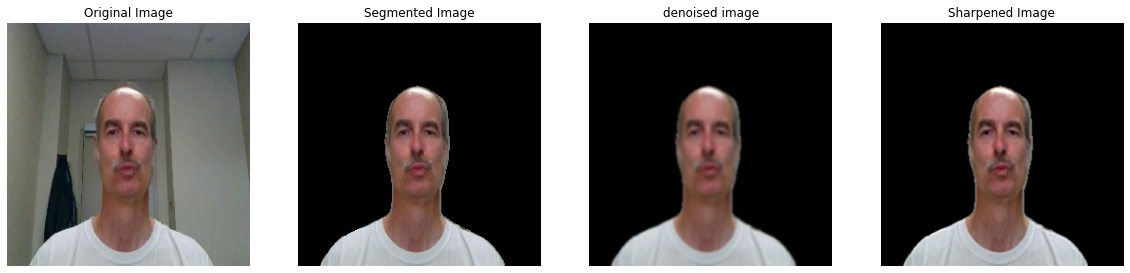

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from torchvision import models
import torch
import torchvision.transforms as transforms
from PIL import Image
import cv2
from skimage.filters import gaussian

# Define a sharpening filter kernel
def sharpening_filter():
    kernel = np.array([[0, -1, 0],
                       [-1,  5, -1],
                       [0, -1, 0]])
    return kernel

# Apply the sharpening filter to the image
def sharpen_image(image):
    kernel = sharpening_filter()
    
    # For grayscale images
    if image.ndim == 2:
        sharpened = convolve(image, kernel)
    
    # For RGB images (3 channels)
    elif image.ndim == 3 and image.shape[2] == 3:
        sharpened = np.zeros_like(image)
        for i in range(3):  # Apply sharpening filter to each channel
            sharpened[:, :, i] = convolve(image[:, :, i], kernel)
    
    else:
        raise ValueError("Unsupported image shape")

    return np.clip(sharpened, 0, 1)  # Ensure pixel values are within [0, 1] range

# Function to load the DeepLabV3 model
def load_model():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
    return model

# Function to predict and remove background from numpy array images
def remove_background(image_np, model):
    # Convert the numpy array to a PIL Image
    image = Image.fromarray(image_np.astype('uint8')).convert('RGB')

    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the transformations
    input_image = transform(image).unsqueeze(0)

    # Predict the segmentation mask
    with torch.no_grad():
        output = model(input_image)['out'][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

    # Resize the mask to the original image size
    output_predictions = cv2.resize(output_predictions, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a binary mask where the object of interest (e.g., person) is 1 and the background is 0
    mask = (output_predictions == 15).astype(np.uint8)

    # Apply the mask to remove the background
    image_np = image_np * mask[:, :, np.newaxis]

    return image_np

# Initialize lists to store preprocessed data
dataX = []
dataY = []

# Assuming `data` is a DataLoader or similar iterable of images and labels
for images, labels in data:
    dataX.append(images.numpy()[0])  # Assuming batch_size=1, extract the image
    dataY.append(labels.numpy()[0])  # Assuming batch_size=1, extract the label

# Convert lists to numpy arrays
dataX = np.array(dataX)
dataY = np.array(dataY)

# Load the segmentation model
model = load_model()

# Apply background removal for each image
dataX_segmented = np.array([remove_background(img, model) for img in dataX])

# Normalize images
dataX_segmented = dataX_segmented / 255.0
# Denoise images using Gaussian filter with updated argument
test_dataX_denoised = np.array([gaussian(img, sigma=1, channel_axis=-1) for img in dataX_segmented])

# Reshape data to match the original shape with a single channel for grayscale
test_dataX_denoised = np.reshape(test_dataX_denoised, (test_dataX_denoised.shape[0], 256, 256, 3))

# Apply sharpening filter to the segmented images
dataX_sharpened = np.array([sharpen_image(img) for img in test_dataX_denoised])

# Randomly select an image index
random_index = random.randint(0, dataX.shape[0] - 1)

# Plot original, segmented, and sharpened images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axs[0].imshow(dataX[random_index].astype('uint8'))
axs[0].set_title('Original Image')
axs[0].axis('off')

# Segmented image
axs[1].imshow(dataX_segmented[random_index])
axs[1].set_title('Segmented Image')
axs[1].axis('off')

# Sharpened image
axs[2].imshow(test_dataX_denoised[random_index])
axs[2].set_title('denoised image')
axs[2].axis('off')

# Sharpened image
axs[3].imshow(dataX_sharpened[random_index])
axs[3].set_title('Sharpened Image')
axs[3].axis('off')

plt.show()



### Note
This code performs the following tasks for image prepocessing:

- Loads and processes images.
- Uses a deep learning model (DeepLabV3) to segment the image and remove the background.
- Denoises the segmented images using a Gaussian filter.
- Sharpens the denoised images using a custom convolution filter.
- Visualizes the various stages of the image processing pipeline.

In [5]:
dataX_sharpened

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the provided CSV file
file_path = r"C:\Users\T00733937\Downloads\Final-results (1)\Final-results\MULTIMODAL_DATA.xlsx"
data = pd.read_excel(file_path)
print(data.head())
print(data.info())

# Drop the unnecessary index column
data = data.drop(columns=['Unnamed: 0'])

# Encode 'gender' and 'risk' as binary variables (0 or 1)
label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])
# data['risk'] = label_encoder.fit_transform(data['risk'])
data['gender'] = data['gender'].astype('category')
data['smoking'] = data['smoking'].astype('category')
data['risk'] = data['risk'].astype('category')


# If 'smoking' is already in numerical form and is ordinal, you can leave it as is
# For example, if 'smoking' is already 0, 1, 2 representing 'never', 'former', 'current'

# Normalize/Standardize the numerical features
scaler = StandardScaler()
numerical_columns = ['age', 'systolic', 'distolic', 'glucose', 'bmi', 'cholestrol']
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Check the data types and the first few rows of the dataframe
print(data.info())
print(data.head())

# Prepare the features (X) and labels (y)
X = data.drop(columns=['risk', 'paralysis', 'mrs'])
y = data['risk']

# Display the first few rows of the preprocessed data
print("Features (X):\n", X.head())
print("\nLabels (y):\n", y.head())


   Unnamed: 0  pid  age  gender  nhiss  mrs  systolic  distolic  glucose  \
0           1  P01   64  Female      5    1       132       119      289   
1           2  P02   73    Male     19    3       141       127      242   
2           3  P03   86    Male     18    3       192        91      268   
3           4  P04   26    Male      1    1       140       117      156   
4           5  P05   59  Female     12    1       167        94      287   

   paralysis  smoking  bmi  cholestrol  risk  
0          1        1   45         236     1  
1          0        0   31         237     1  
2          3        2   40         225     1  
3          1        2   33         239     1  
4          1        0   34         250     1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  25 non-null     int64 
 1   pid         25 non-null     objec

### Note

The code performs essential preprocessing for tabular data.

- Loading the dataset from an Excel file.
- Dropping unnecessary columns.
- Encoding categorical variables.
- Standardizing numerical features.
- Preparing the features and labels for machine learning.

P01_KISS.jpg
P01_NORMAL.jpg
P01_OPEN.jpg
P01_SPREAD.jpg
P02_KISS.jpg
P02_NORMAL.jpg
P02_OPEN.jpg
P02_SPREAD.jpg
P03_KISS.jpg
P03_NORMAL.jpg
P03_OPEN.jpg
P03_SPREAD.jpg
P04_KISS.jpg
P04_NORMAL.jpg
P04_OPEN.jpg
P04_SPREAD.jpg
P05_KISS.jpg
P05_NORMAL.jpg
P05_OPEN.jpg
P05_SPREAD.jpg
P06_KISS.jpg
P06_NORMAL.jpg
P06_OPEN.jpg
P06_SPREAD.jpg
P07_KISS.jpg
P07_Normal.jpg
P07_OPEN.jpg
P07_SPREAD.jpg
P08_KISS.jpg
P08_NORMAL.jpg
P08_OPEN.jpg
P08_SPREAD.jpg
P09_KISS.jpg
P09_NORMAL.jpg
P09_OPEN.jpg
P09_SPREAD.jpg
P10_KISS.jpg
P10_NORMAL.jpg
P10_OPEN.jpg
P10_SPREAD.jpg
P11_KISS.jpg
P11_NORMAL.jpg
P11_OPEN.jpg
P11_SPREAD.jpg
P12_KISS.jpg
P12_NORMAL.jpg
P12_OPEN.jpg
P12_SPREAD.jpg
P13_KISS.jpg
P13_NORMAL.jpg
P13_OPEN.jpg
P13_SPREAD.jpg
P14_KISS.jpg
P14_NORMAL.jpg
P14_OPEN.jpg
P14_SPREAD.jpg
P15_KISS.jpg
P15_NORMAL.jpg
P15_OPEN.jpg
P15_SPREAD.jpg
P16_KISS.jpg
P16_NORMAL.jpg
P16_OPEN.jpg
P16_SPREAD.jpg
P17_KISS.jpg
P17_NORMAL.jpg
P17_OPEN.jpg
P17_SPREAD.jpg
P18_KISS.jpg
P18_NORMAL.jpg
P18_OPEN.jpg
P18_SPR

C:\Users\T00733937\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\T00733937\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PID: P01, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


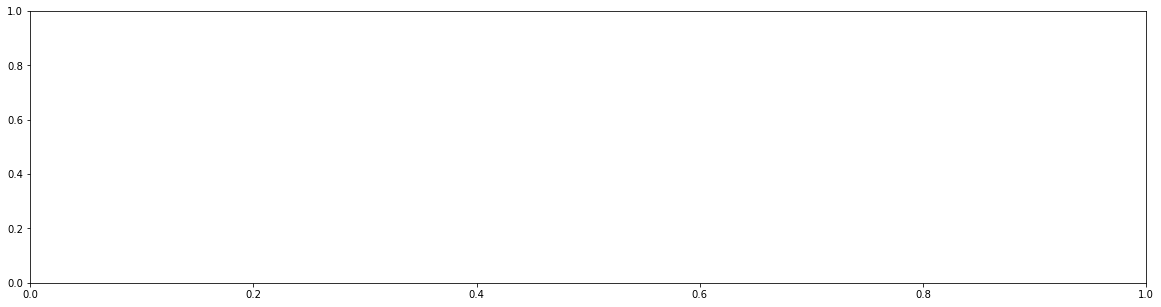

PID: P01, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


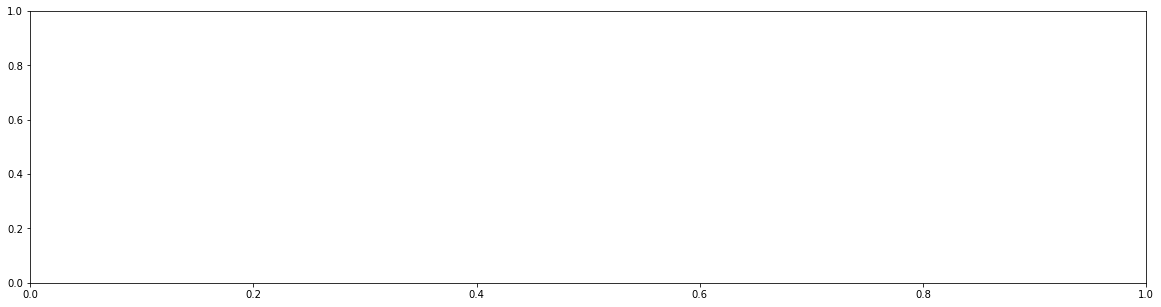

PID: P01, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


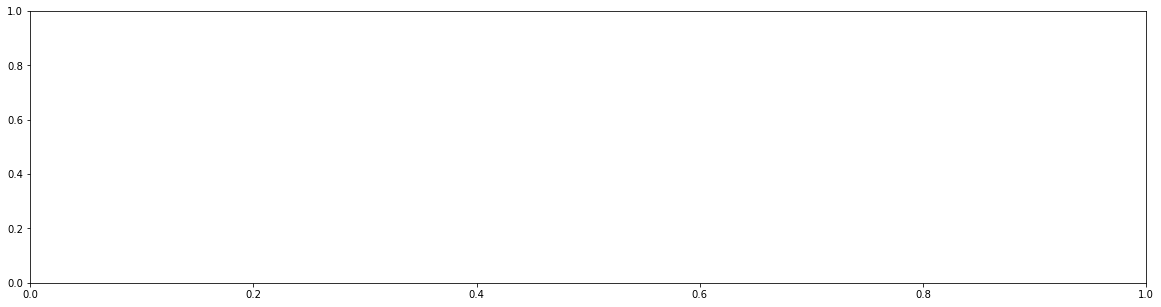

PID: P01, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


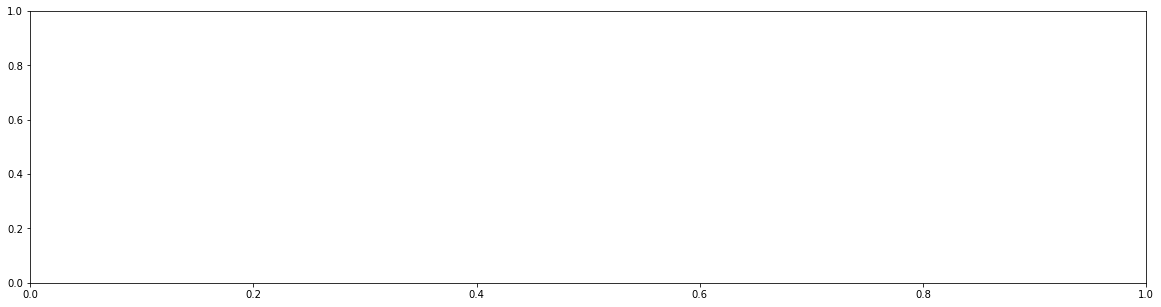

PID: P02, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


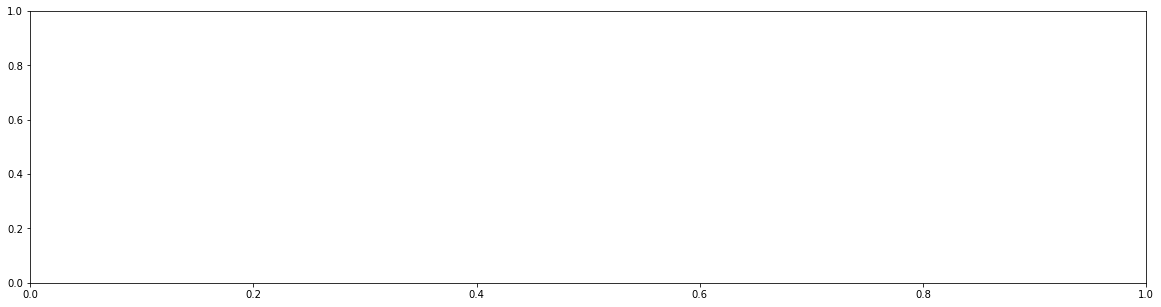

PID: P02, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


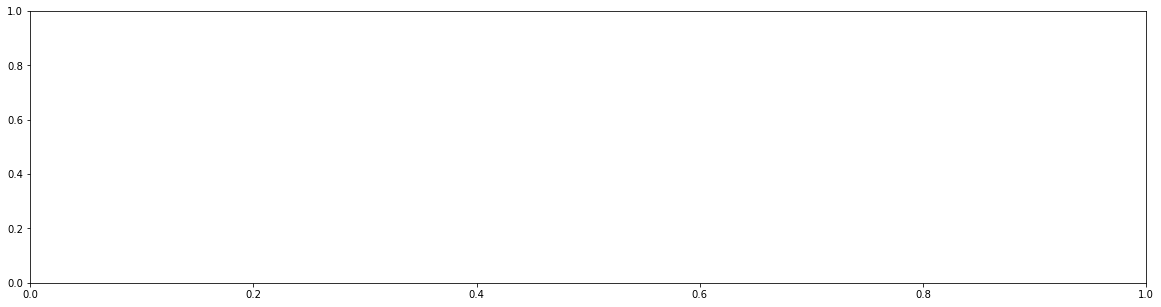

PID: P02, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


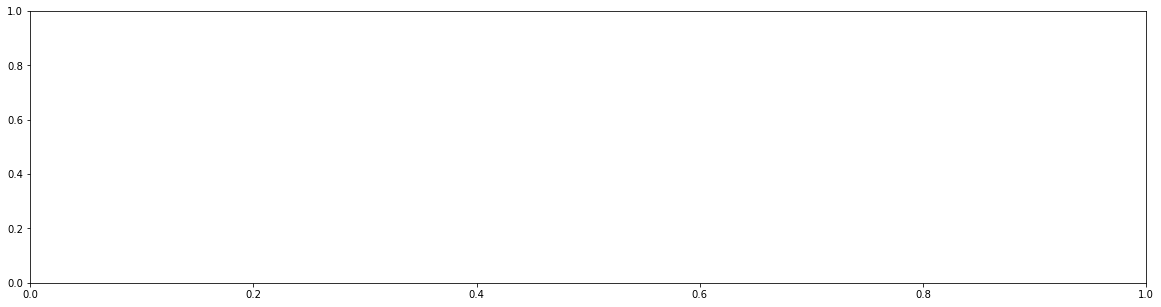

PID: P02, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


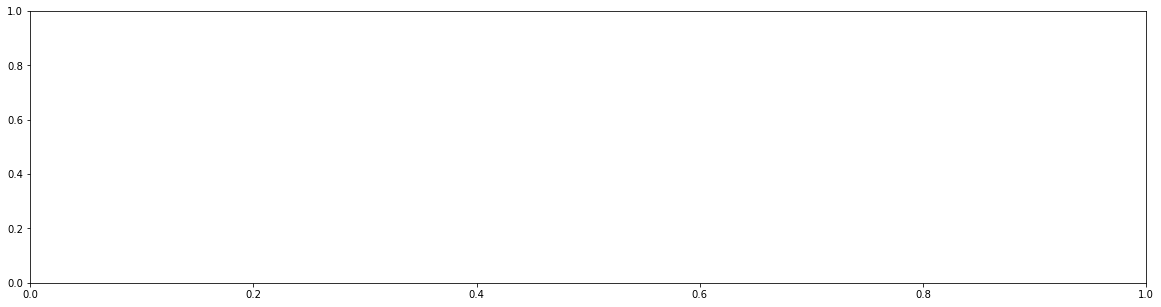

PID: P03, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


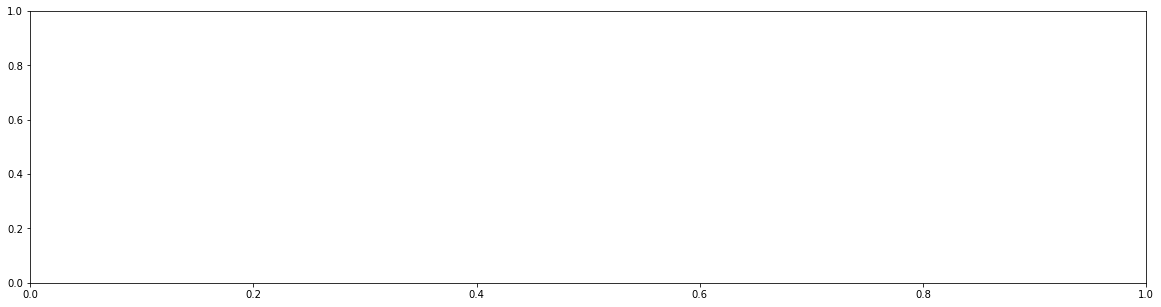

PID: P03, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


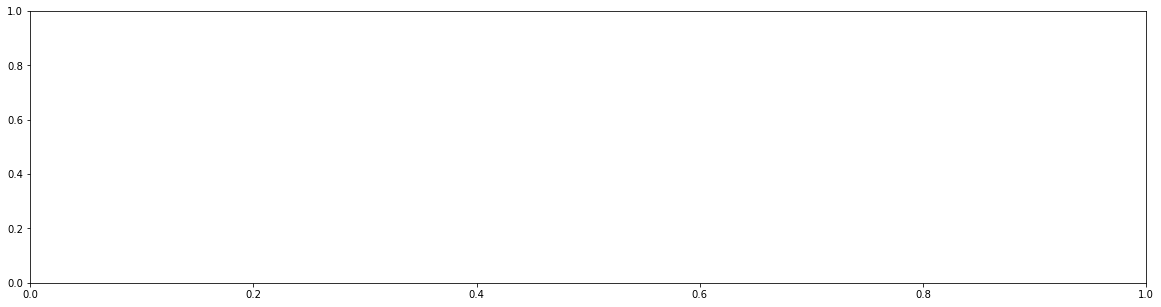

PID: P03, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


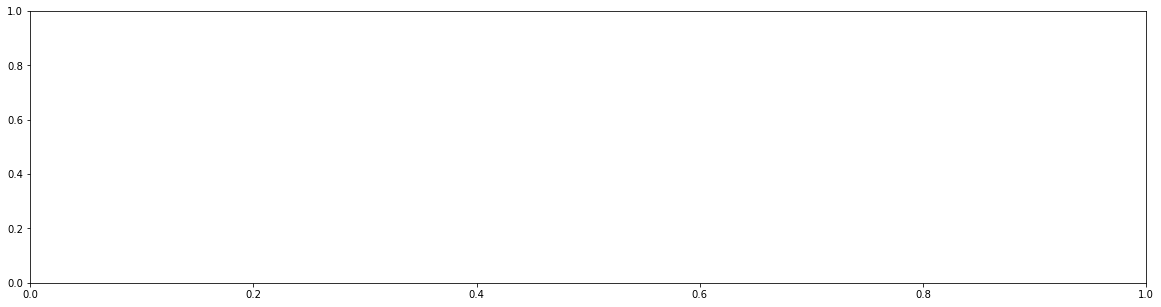

PID: P03, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


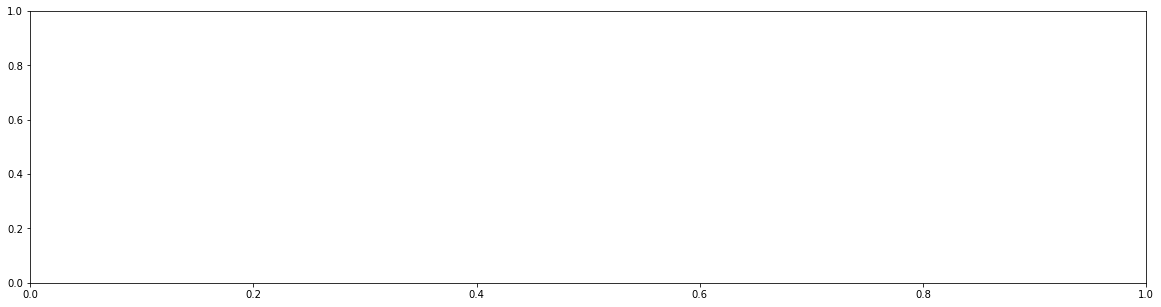

PID: P04, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


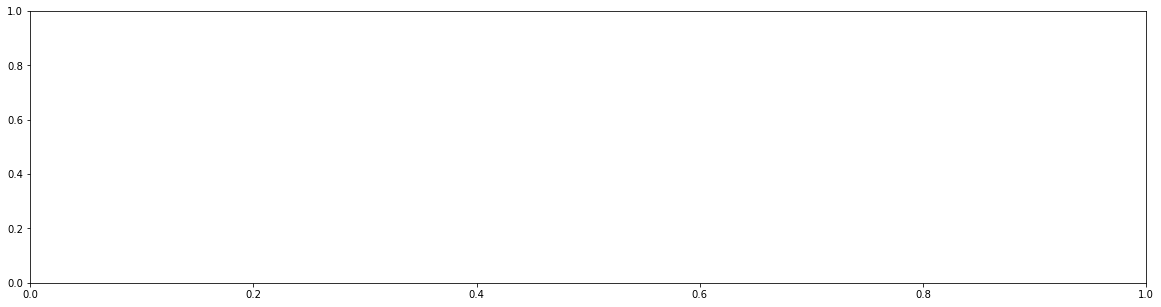

PID: P04, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


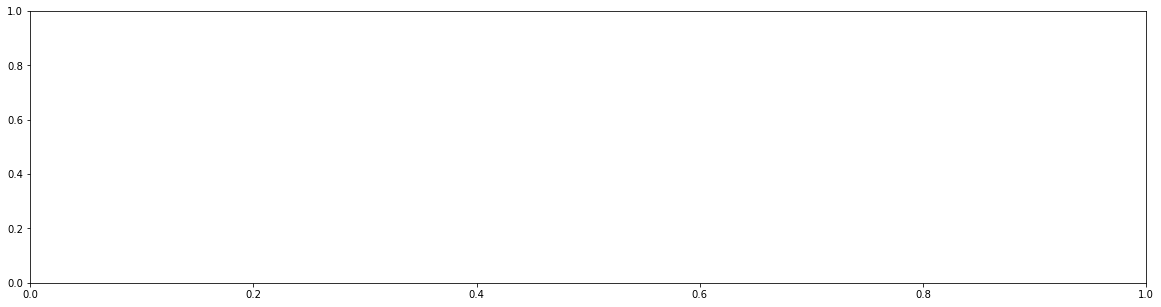

PID: P04, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


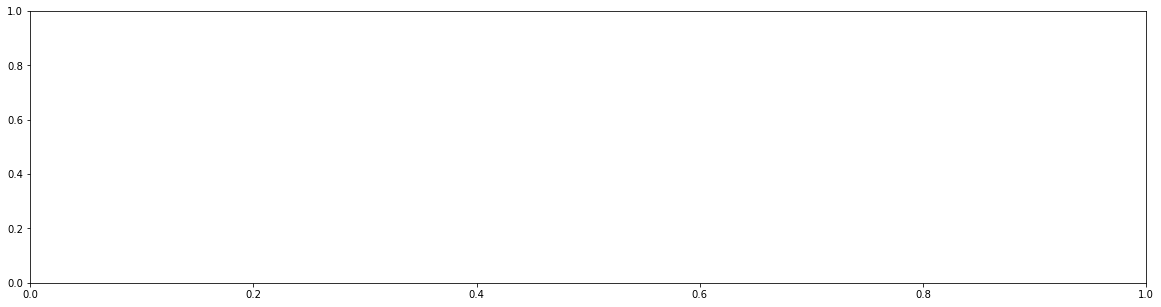

PID: P04, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


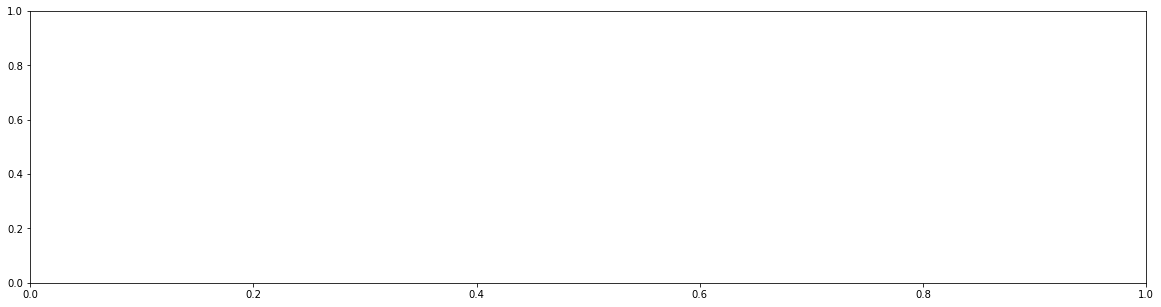

PID: P05, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


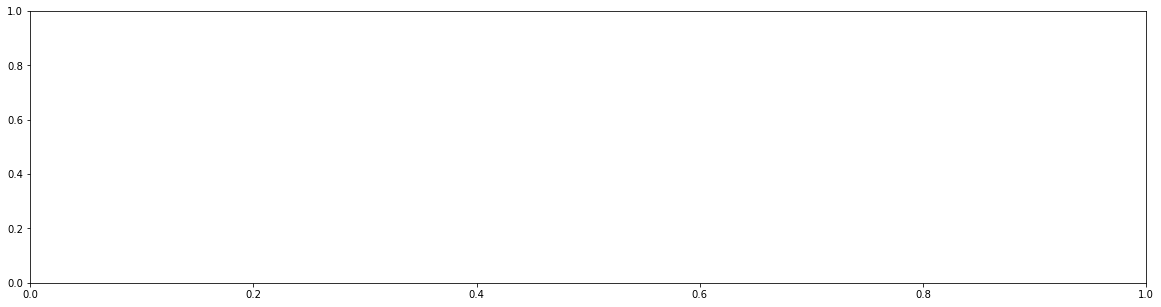

PID: P05, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


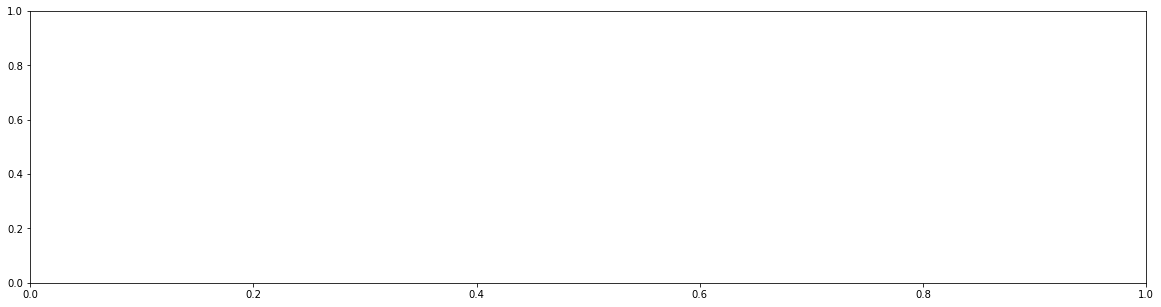

PID: P05, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


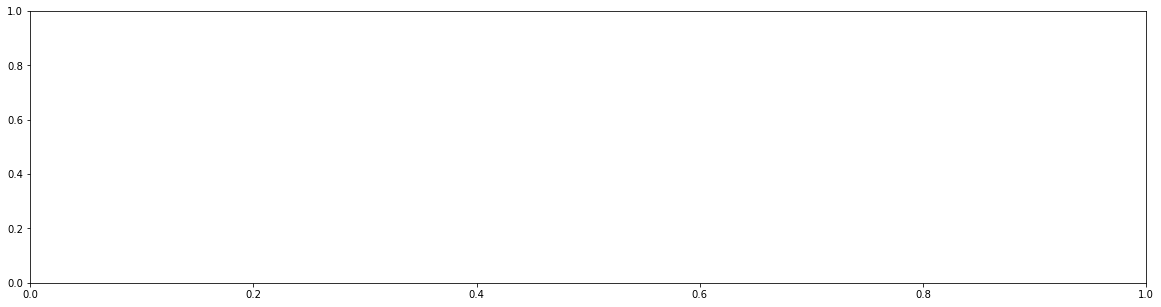

PID: P05, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


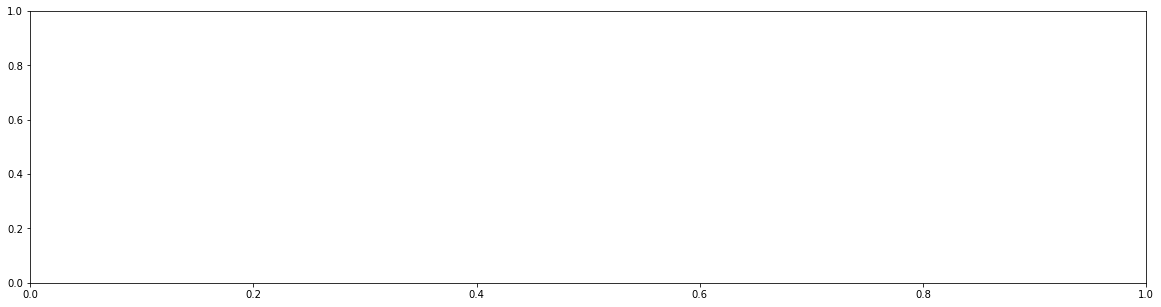

PID: P06, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


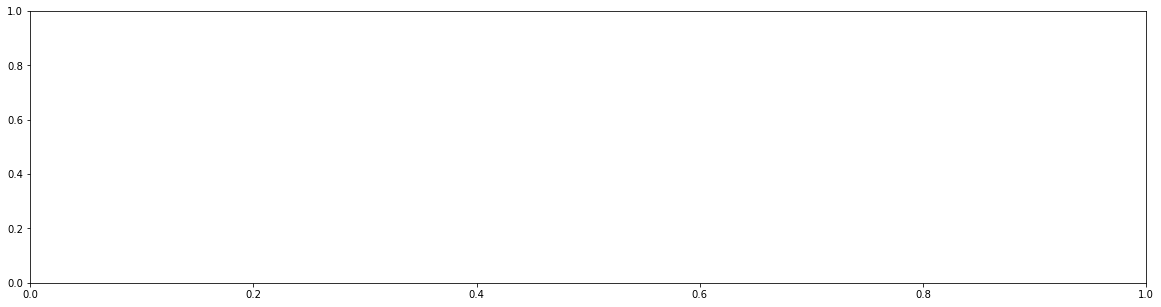

PID: P06, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


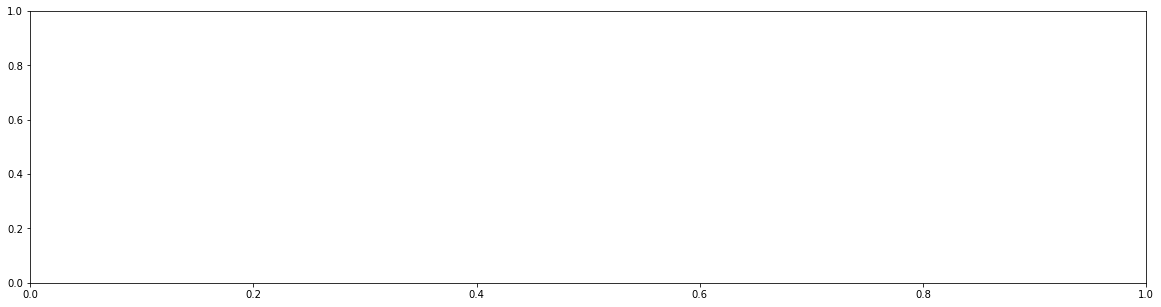

PID: P06, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


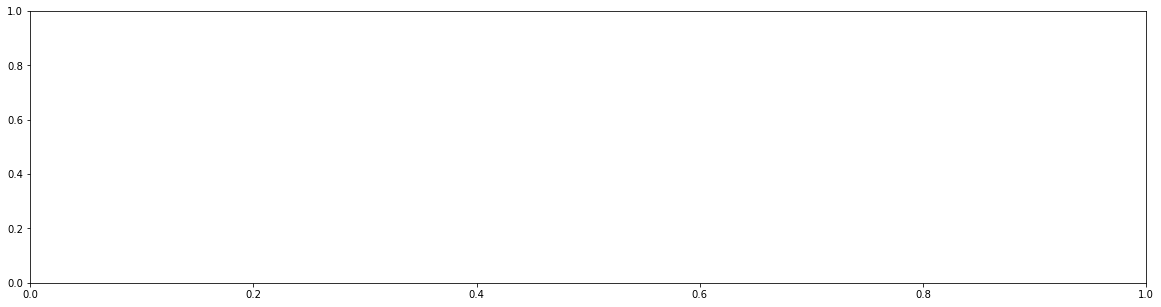

PID: P06, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


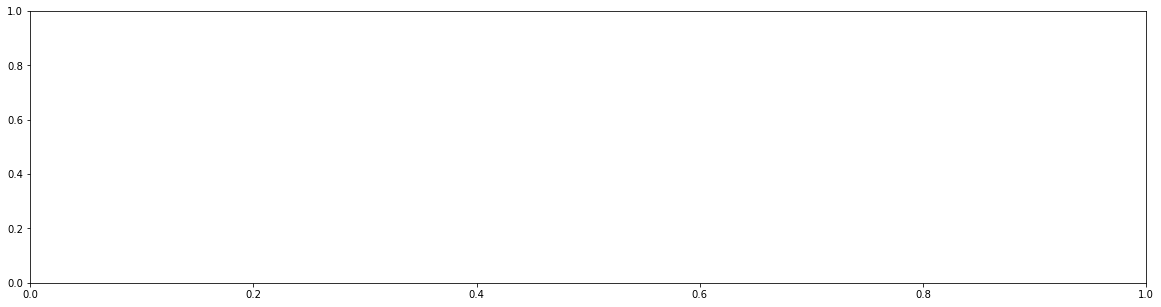

PID: P07, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


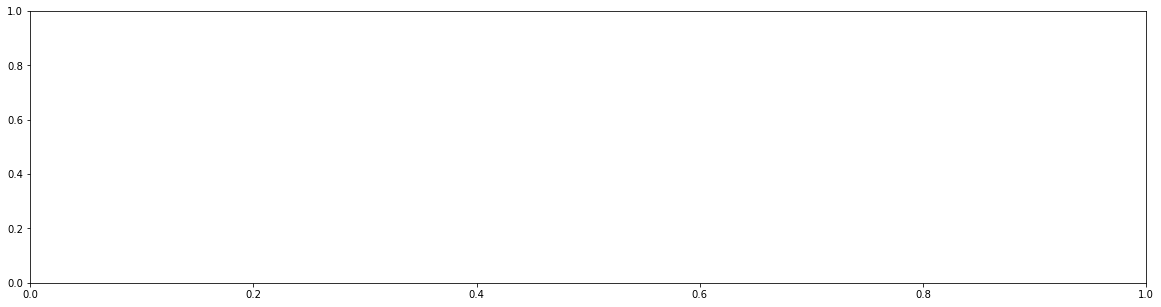

PID: P07, Feature: Normal, Image Shape: (480, 640, 3), Label: Stroke


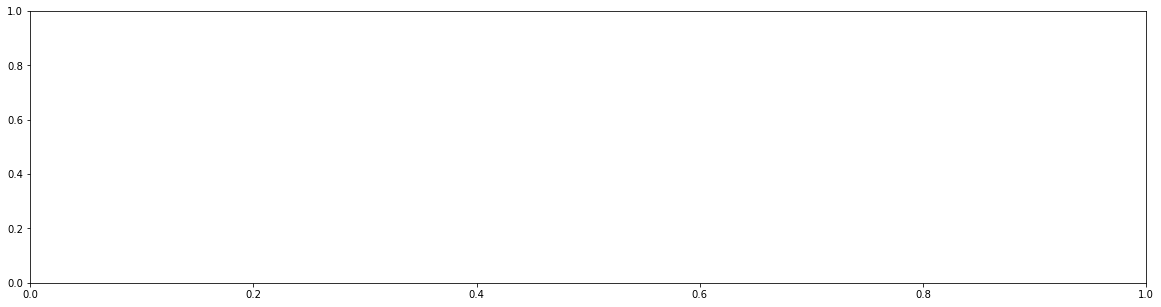

PID: P07, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


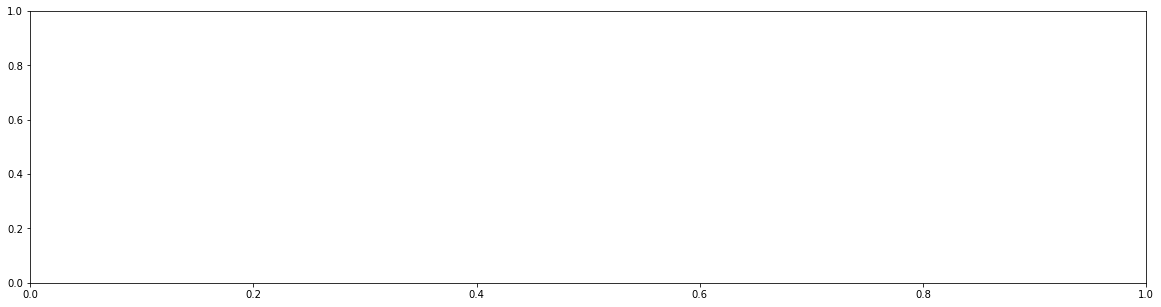

PID: P07, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


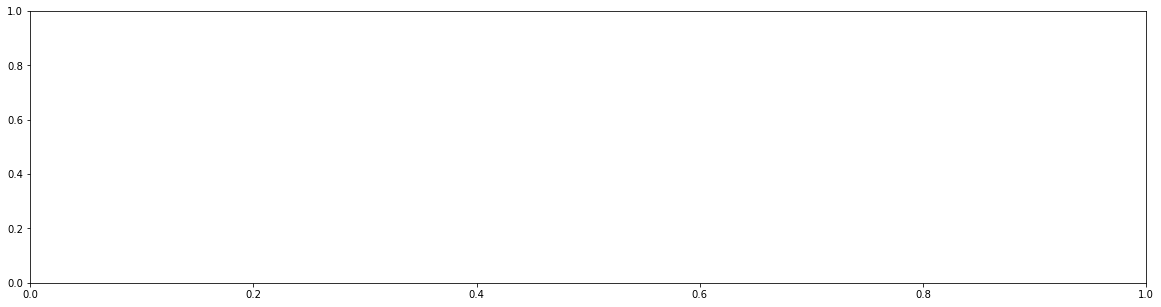

PID: P08, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


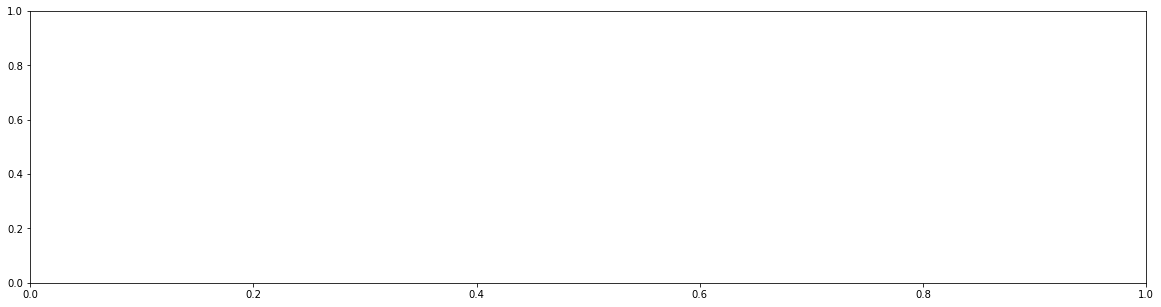

PID: P08, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


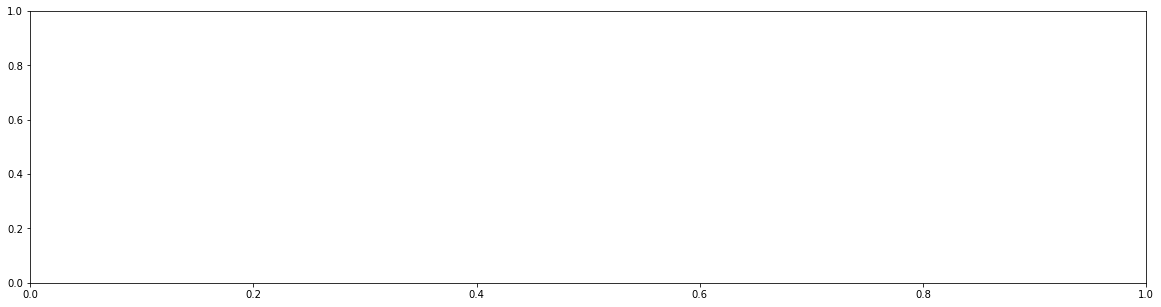

PID: P08, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


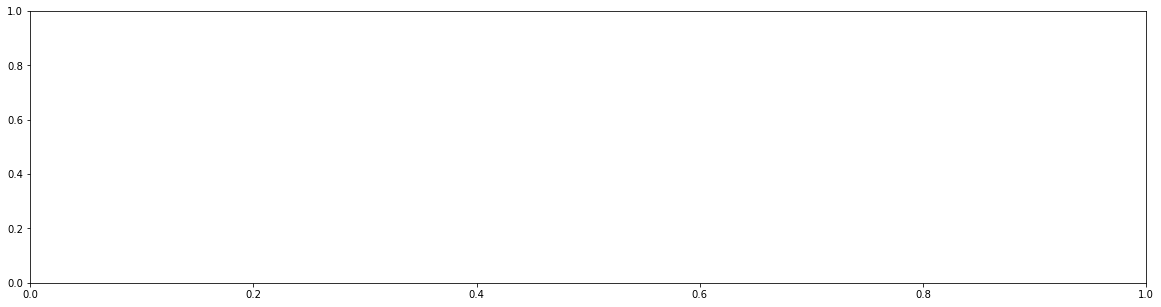

PID: P08, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


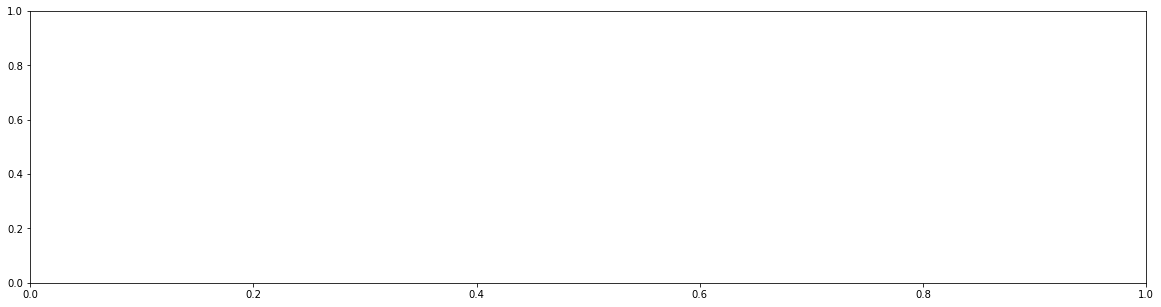

PID: P09, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


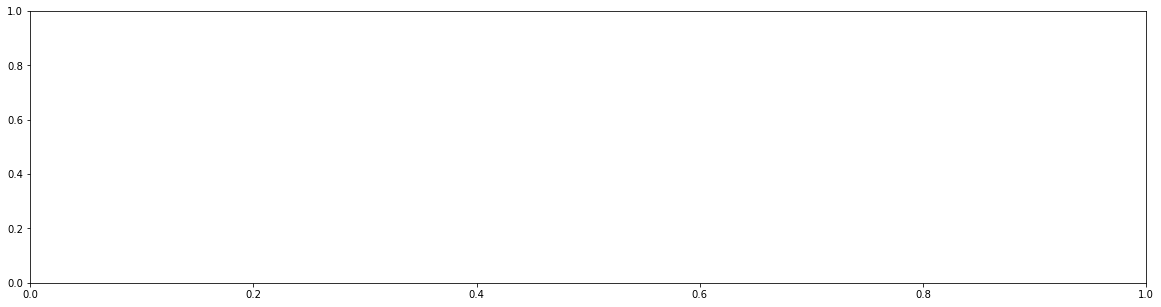

PID: P09, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


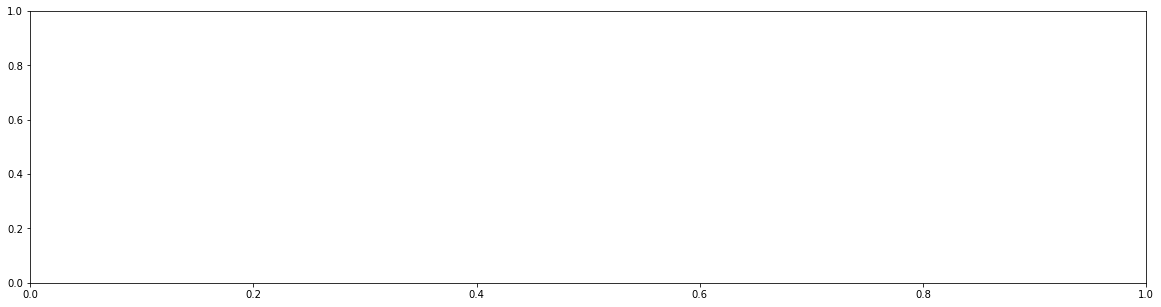

PID: P09, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


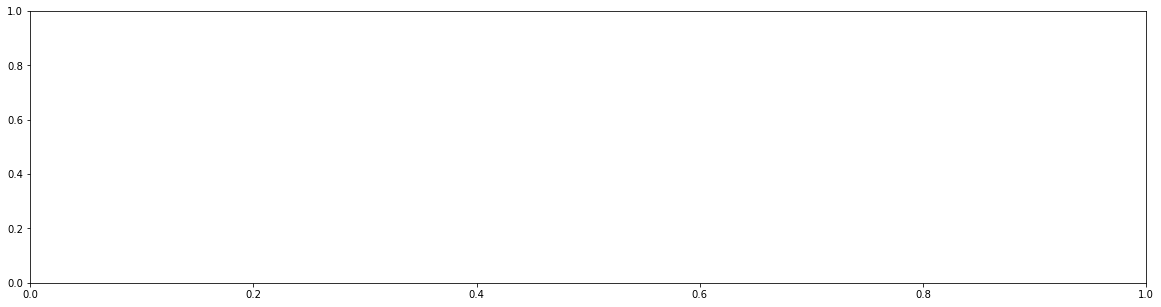

PID: P09, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


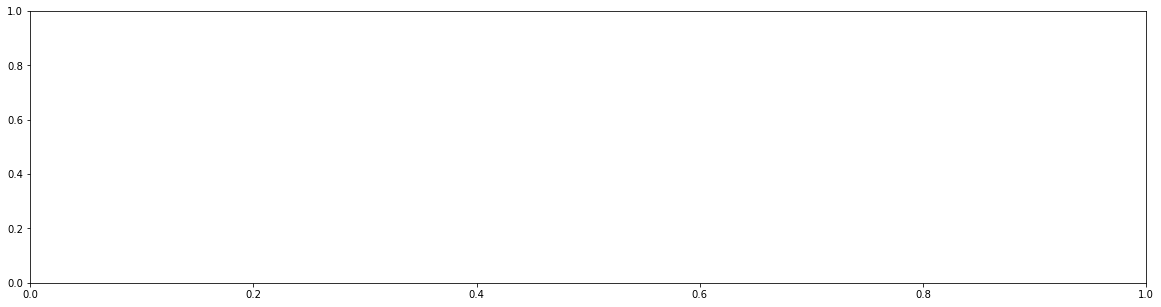

PID: P10, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


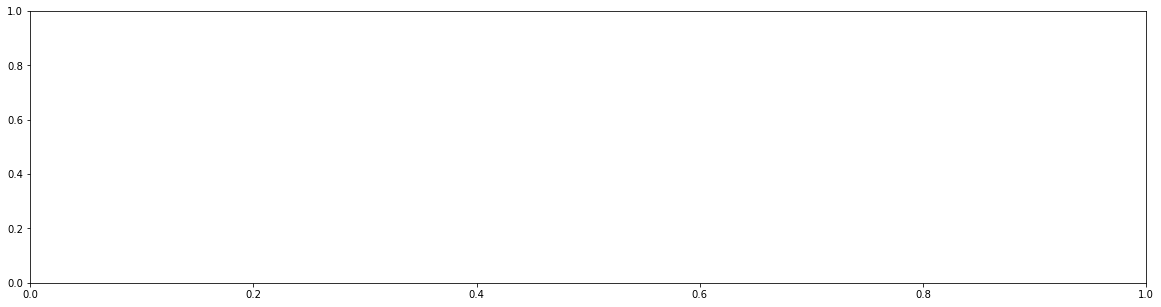

PID: P10, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


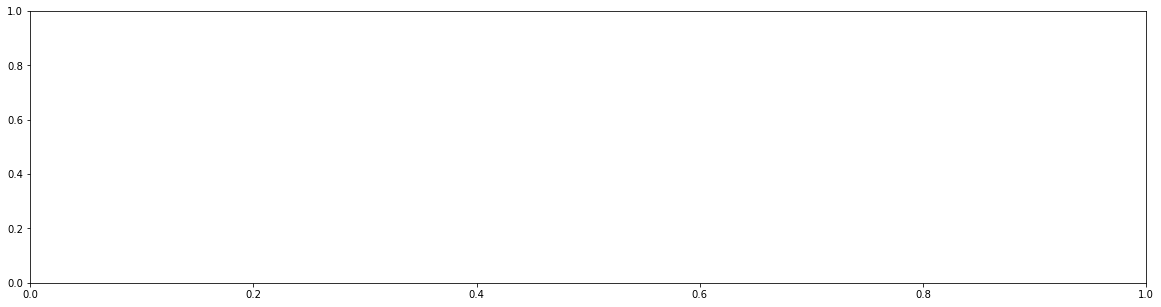

PID: P10, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


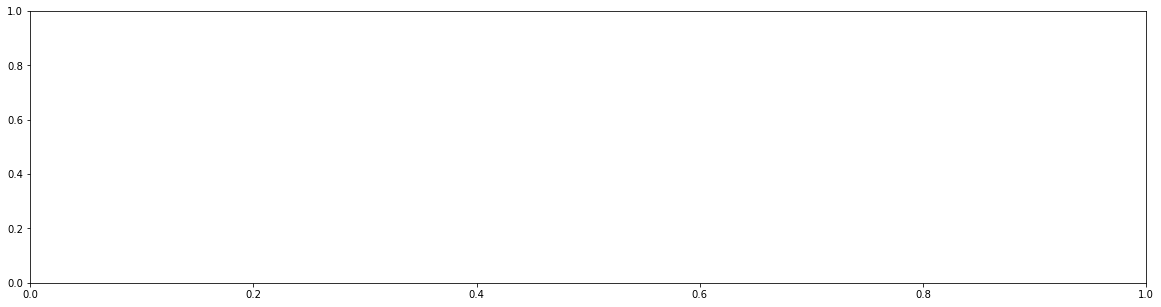

PID: P10, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


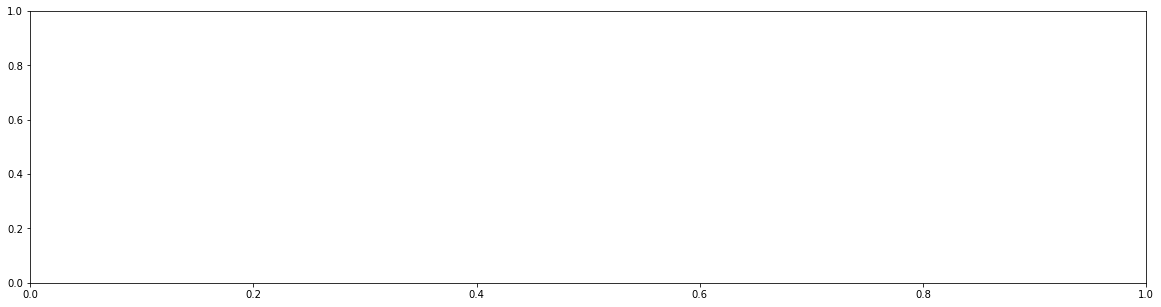

PID: P11, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


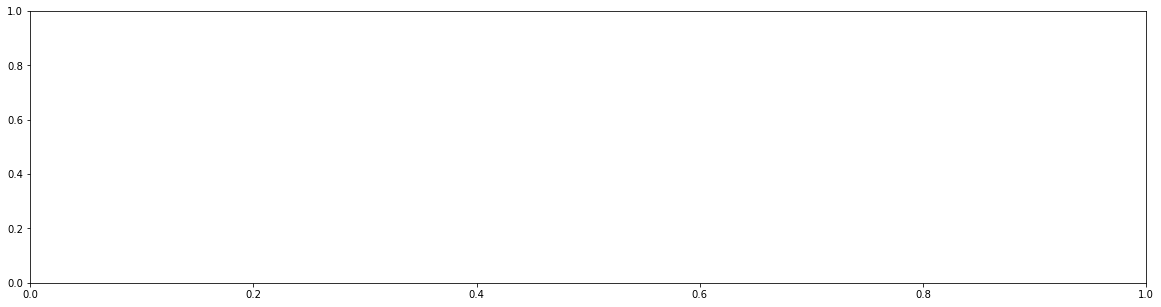

PID: P11, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


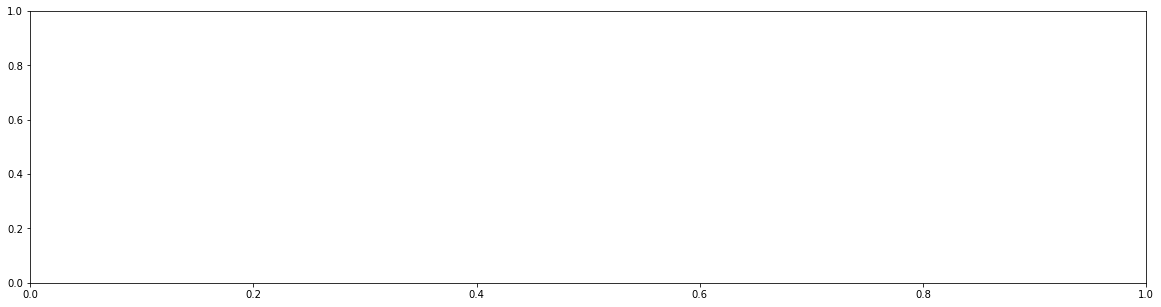

PID: P11, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


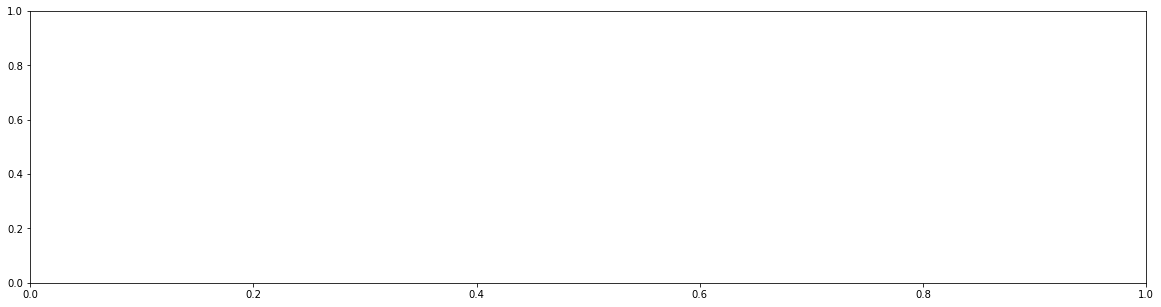

PID: P11, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


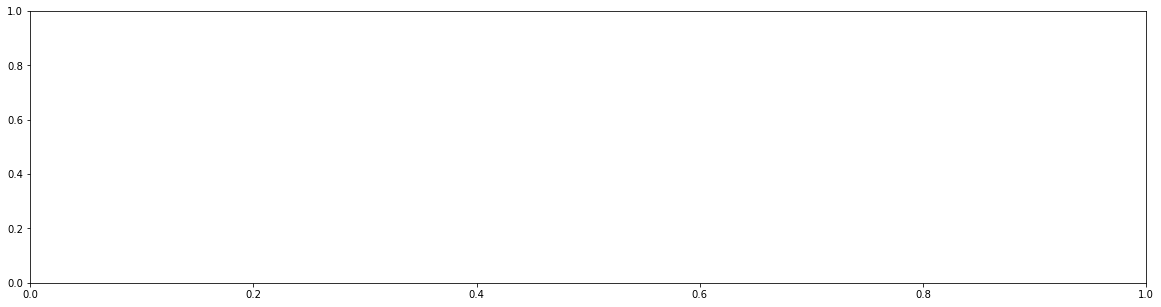

PID: P12, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


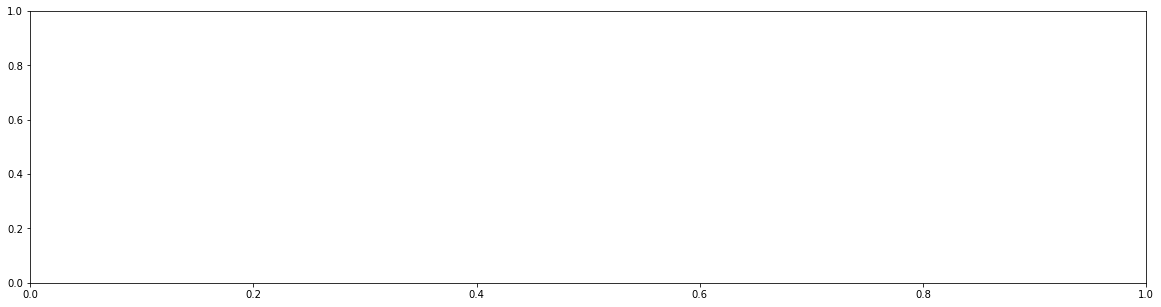

PID: P12, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


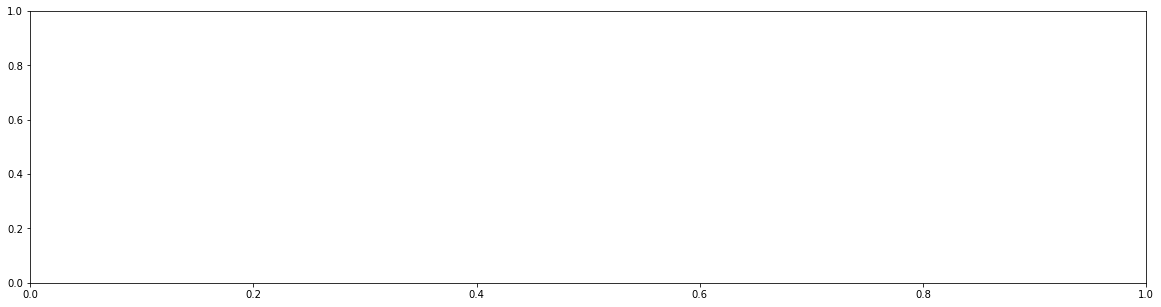

PID: P12, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


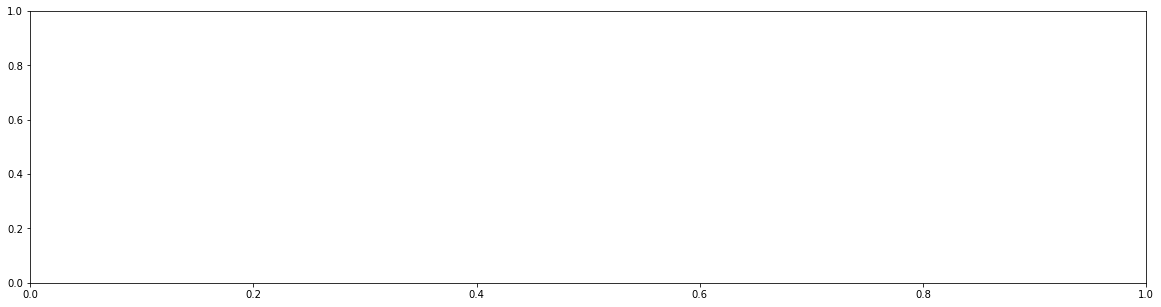

PID: P12, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


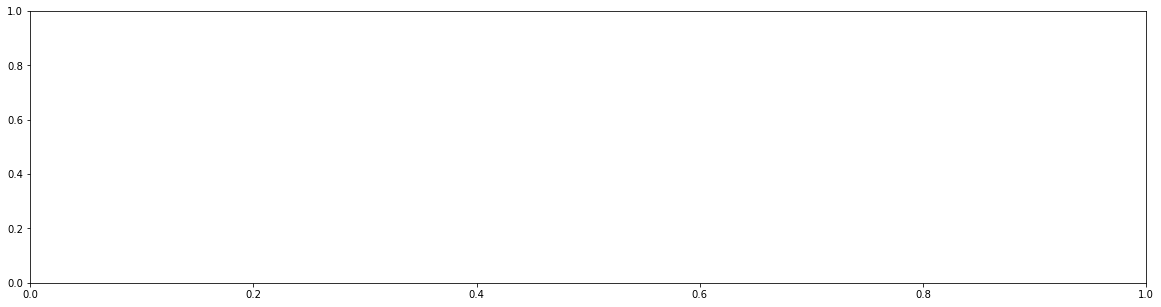

PID: P13, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


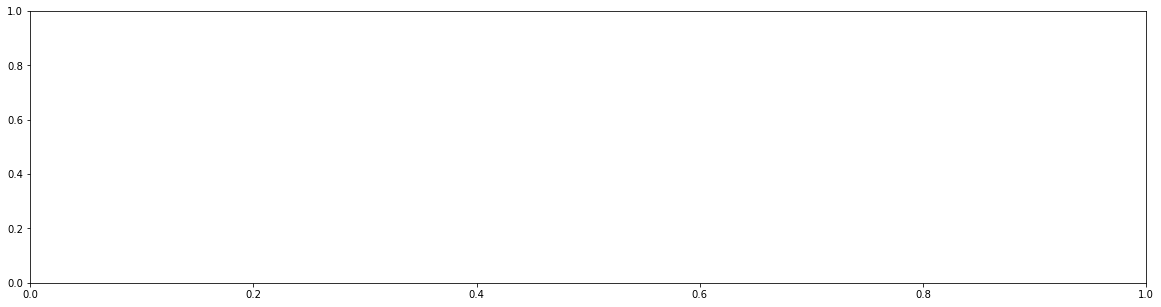

PID: P13, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


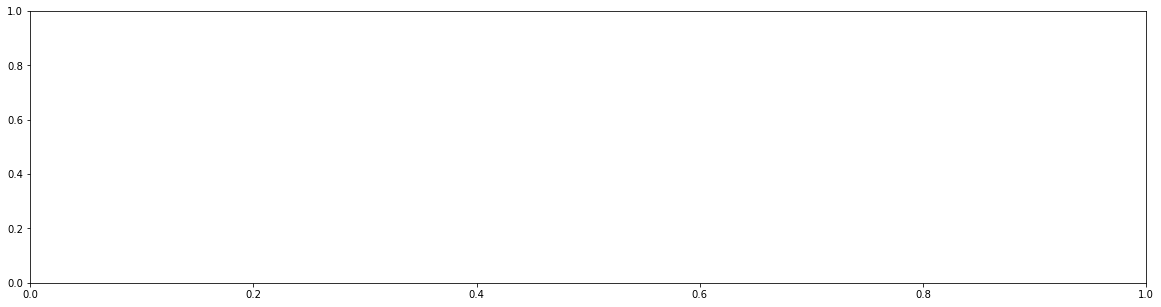

PID: P13, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


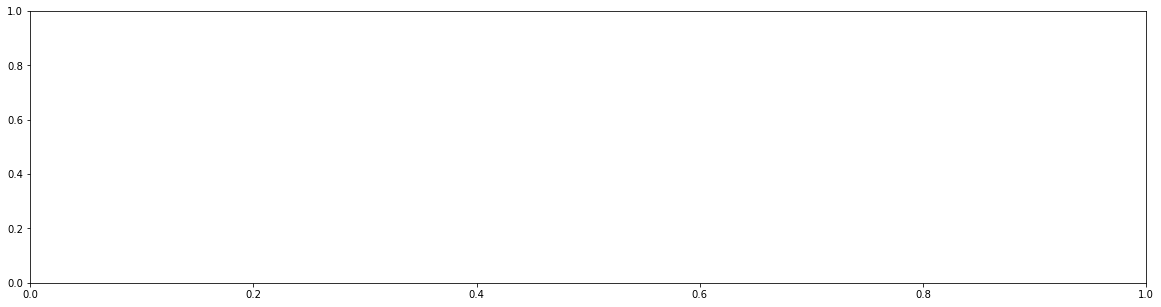

PID: P13, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


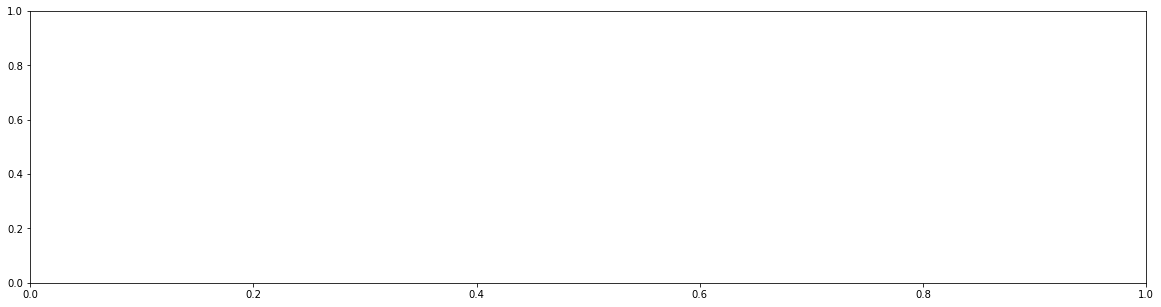

PID: P14, Feature: KISS, Image Shape: (480, 640, 3), Label: Stroke


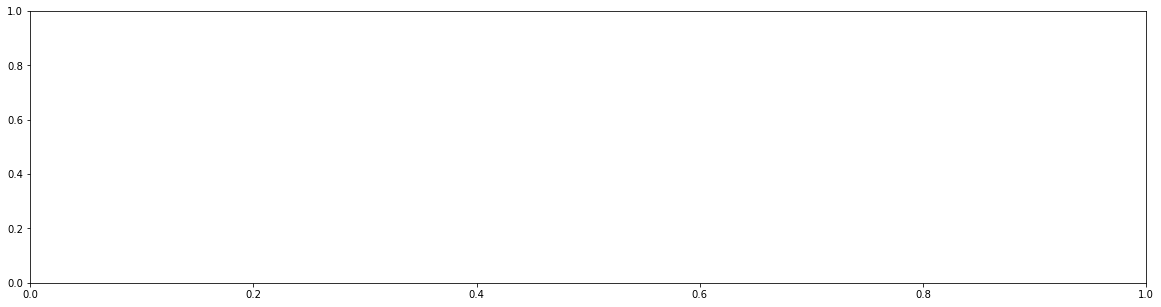

PID: P14, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Stroke


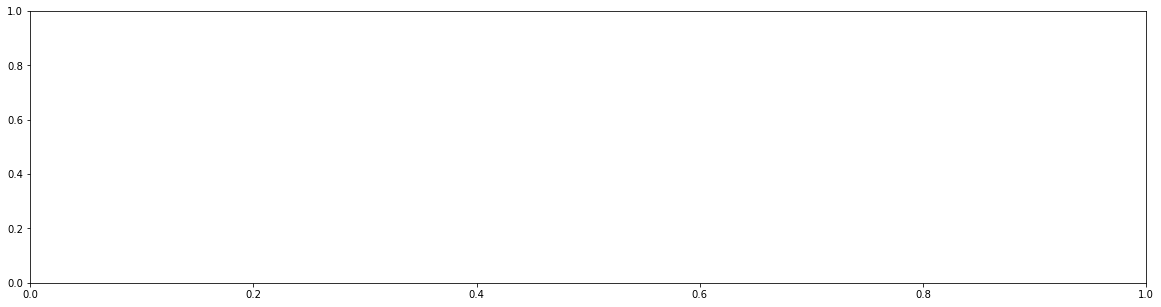

PID: P14, Feature: OPEN, Image Shape: (480, 640, 3), Label: Stroke


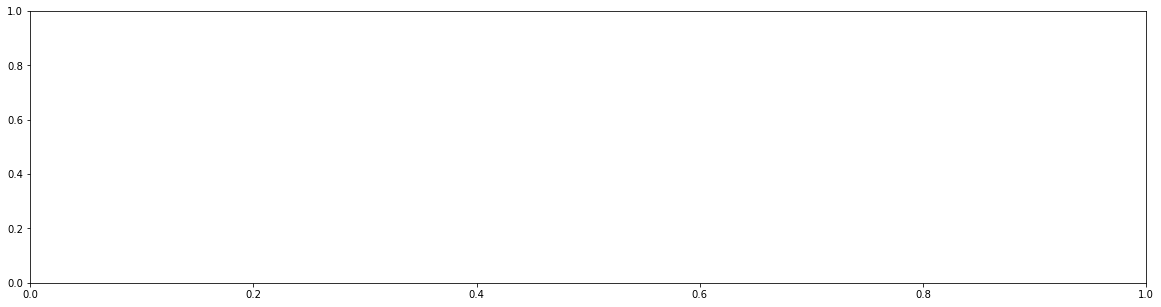

PID: P14, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Stroke


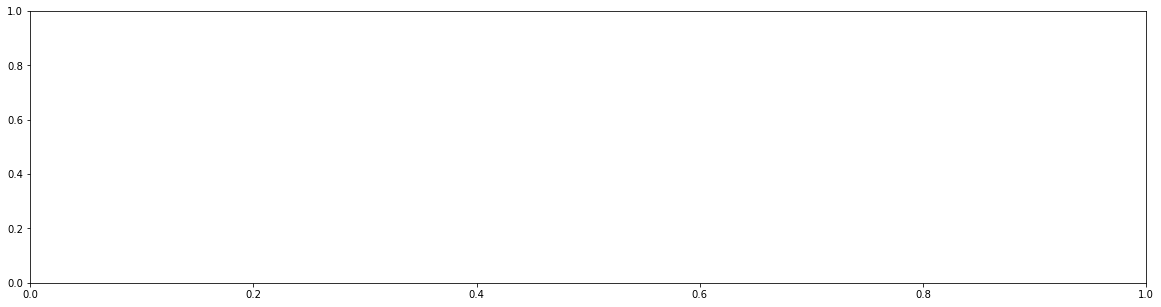

PID: P15, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


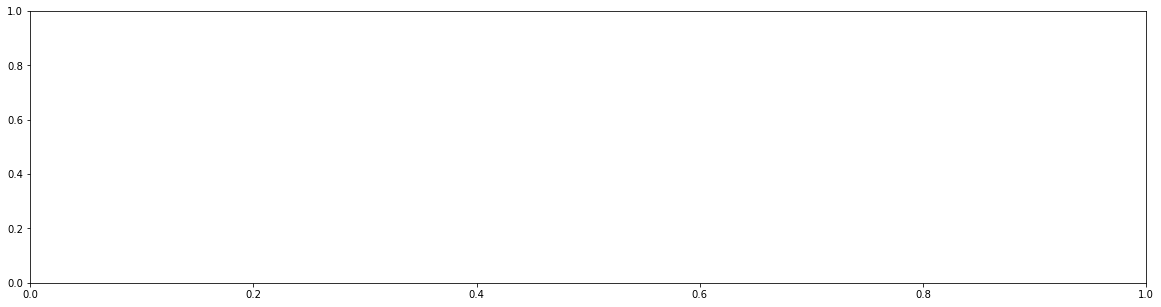

PID: P15, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


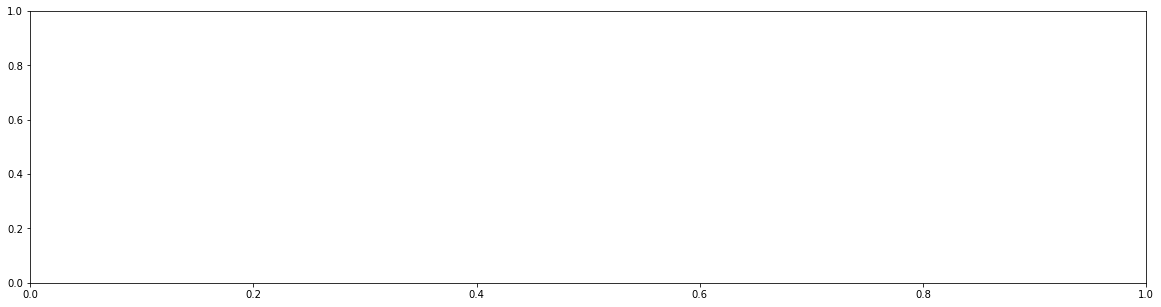

PID: P15, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


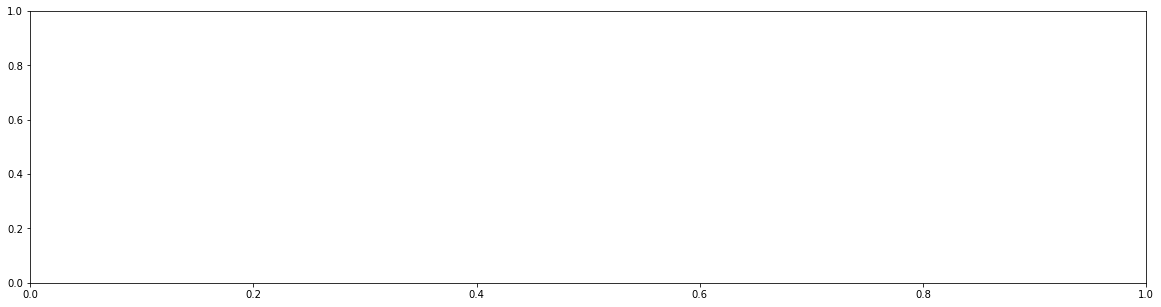

PID: P15, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


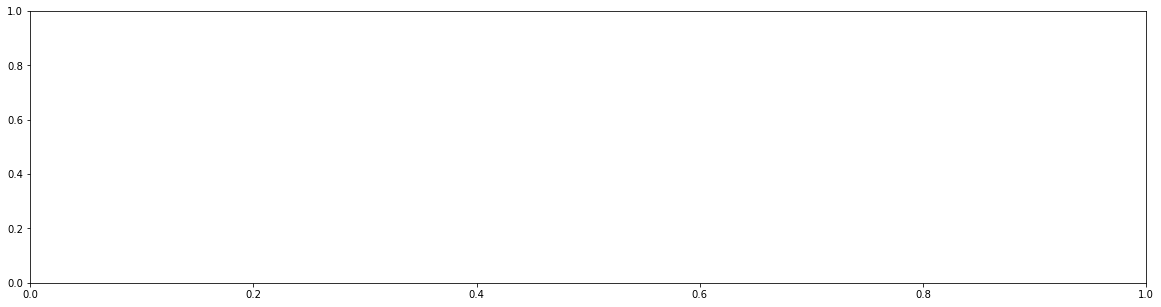

PID: P16, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


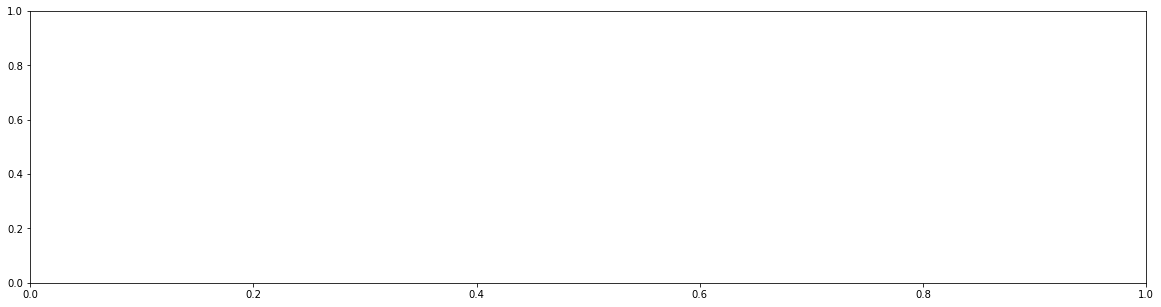

PID: P16, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


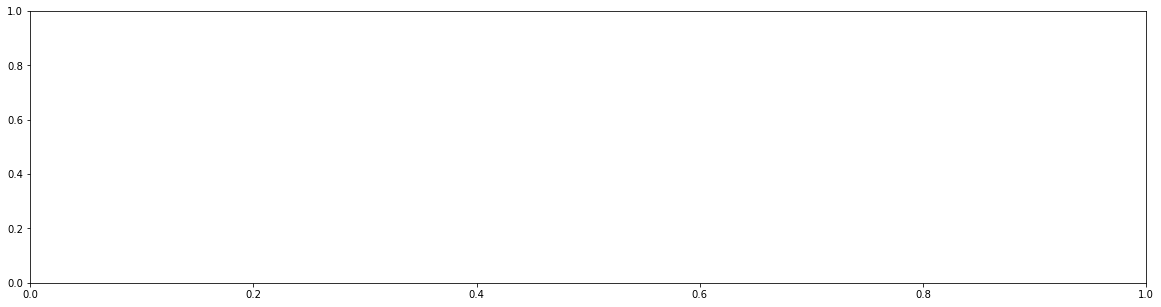

PID: P16, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


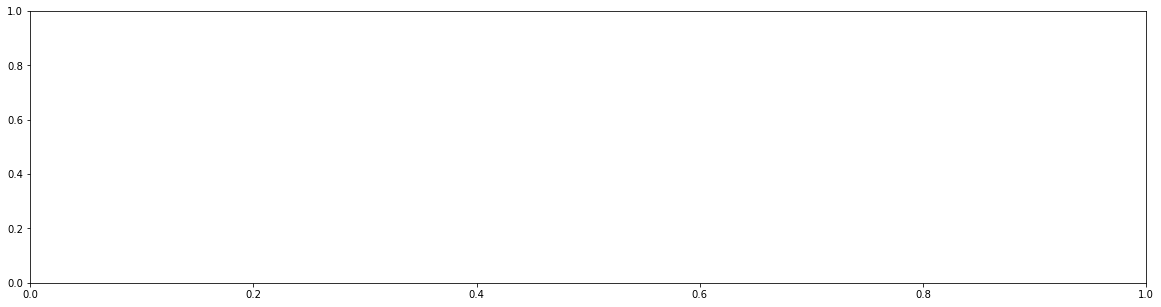

PID: P16, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


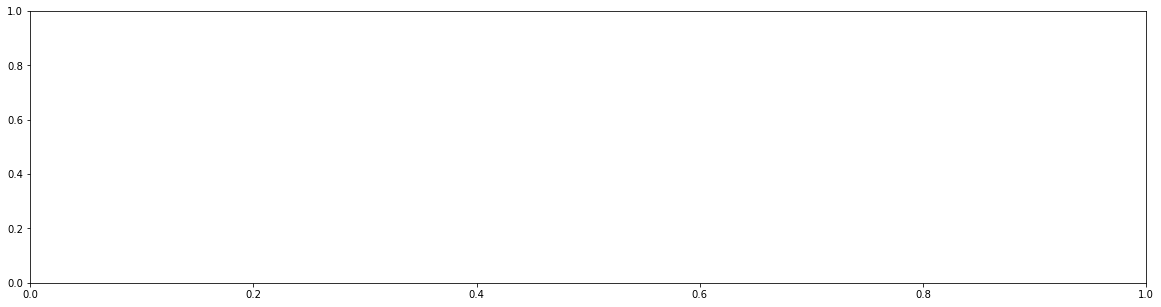

PID: P17, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


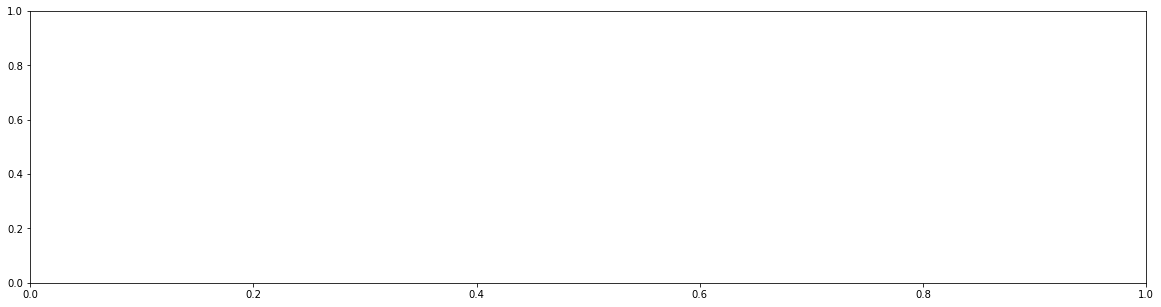

PID: P17, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


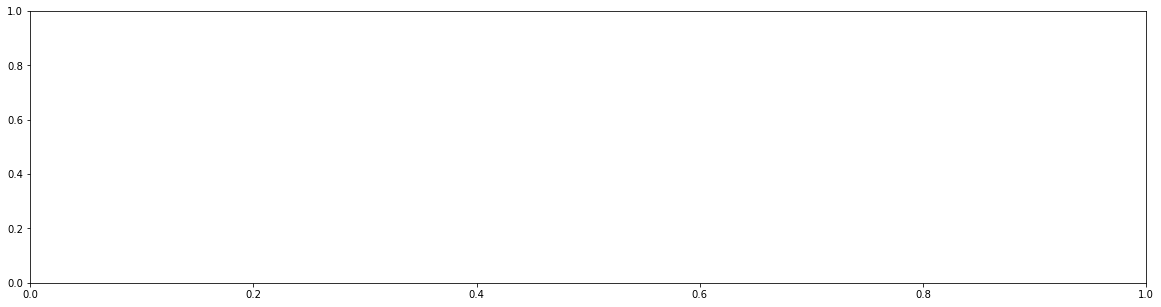

PID: P17, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


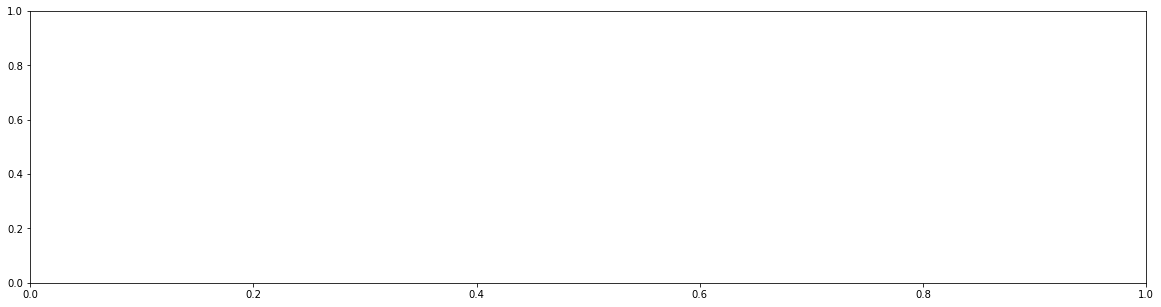

PID: P17, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


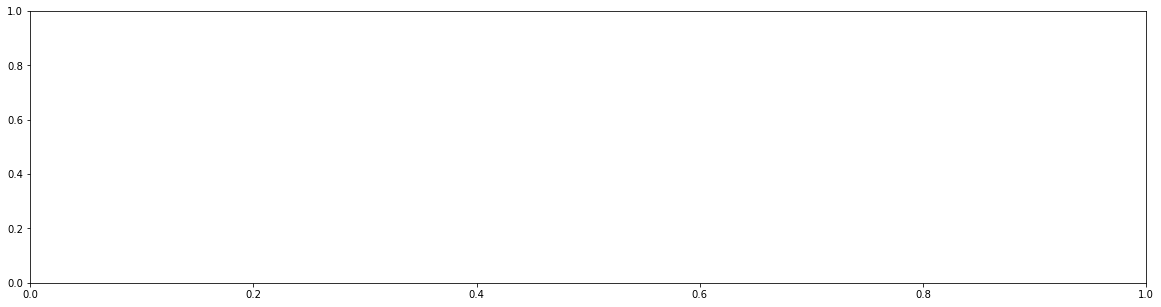

PID: P18, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


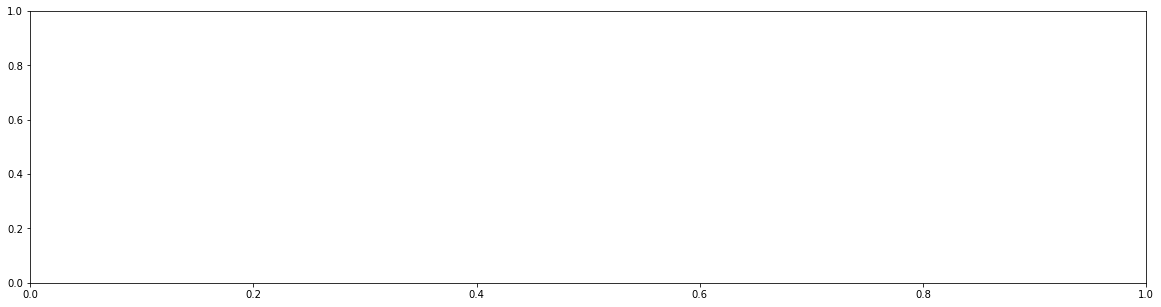

PID: P18, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


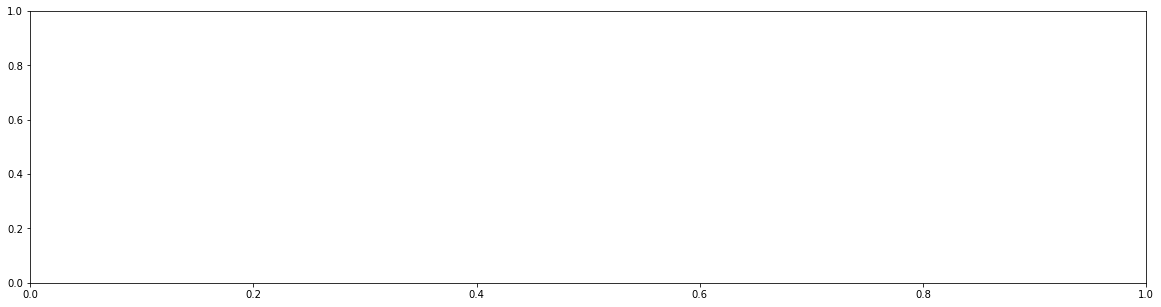

PID: P18, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


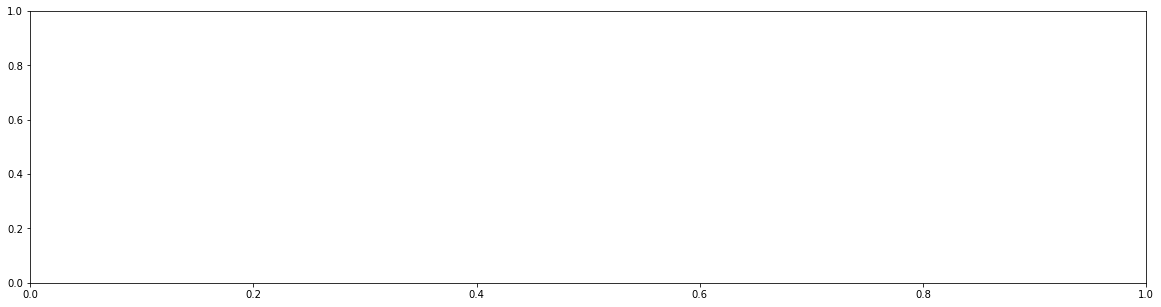

PID: P18, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


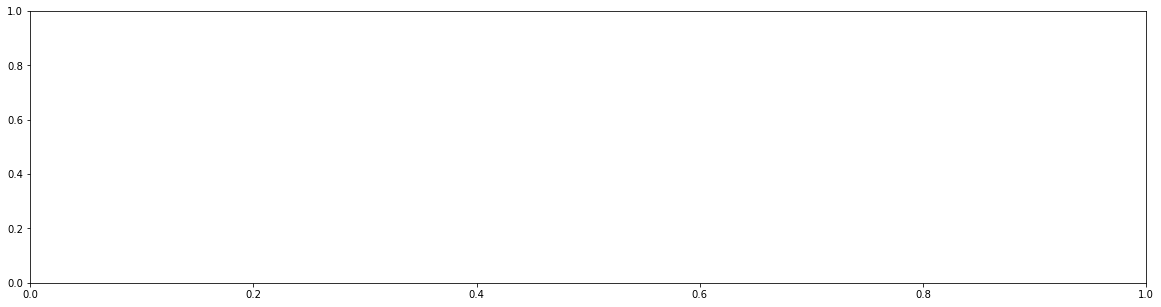

PID: P19, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


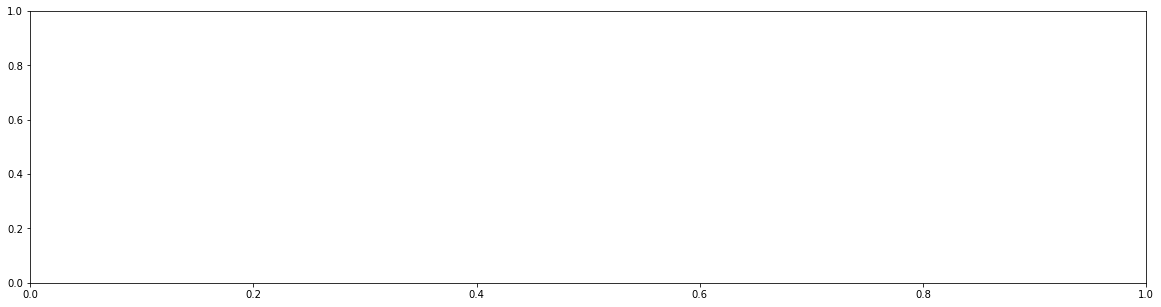

PID: P19, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


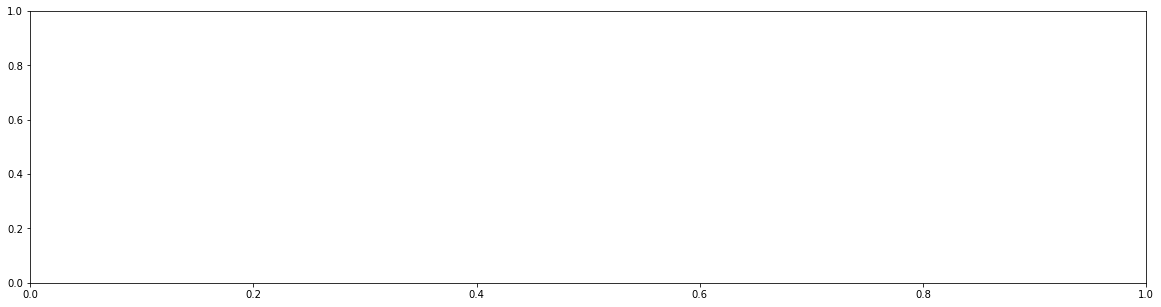

PID: P19, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


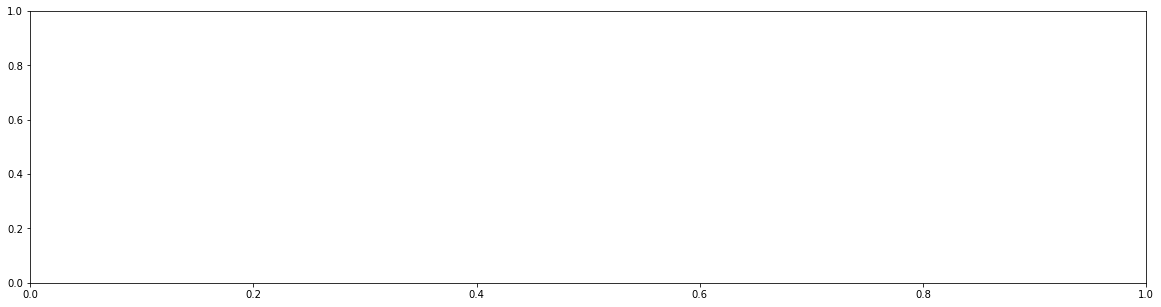

PID: P19, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


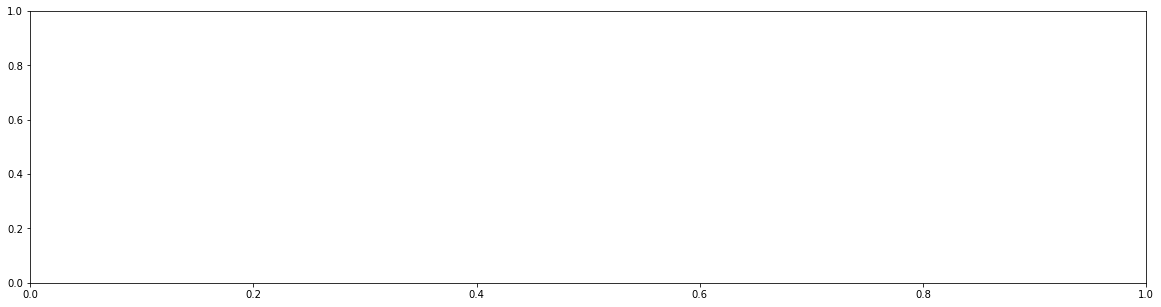

PID: P20, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


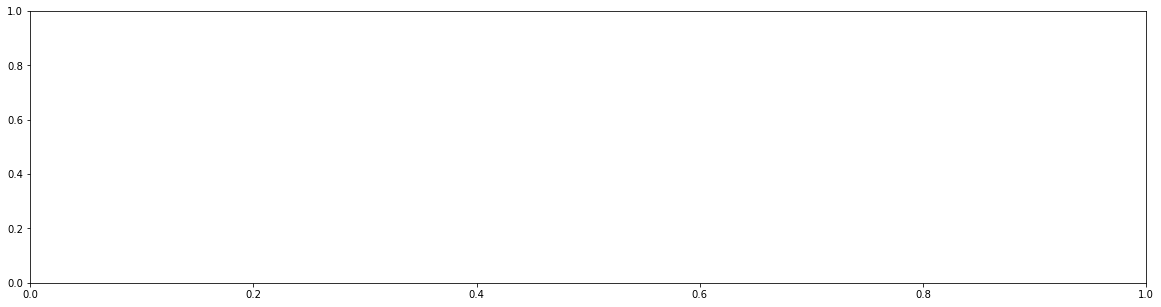

PID: P20, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


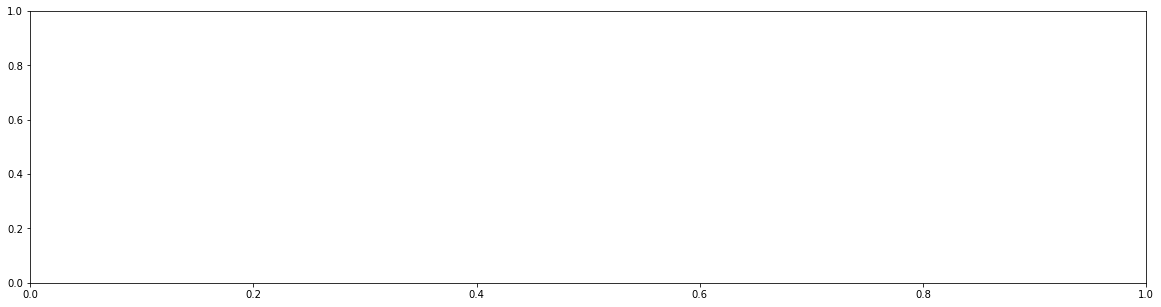

PID: P20, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


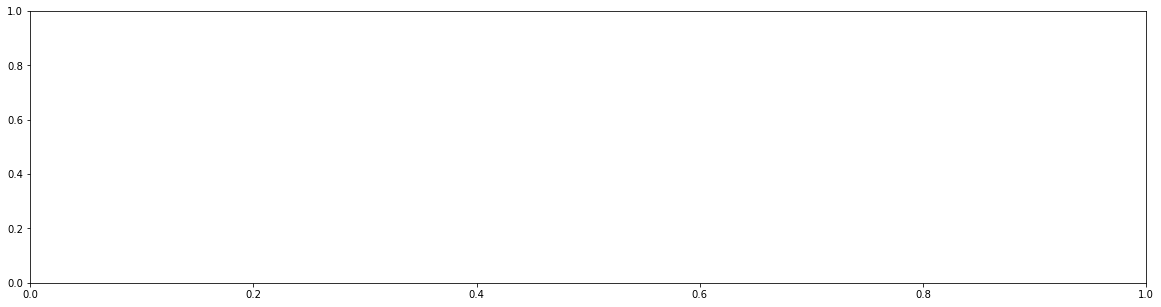

PID: P20, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


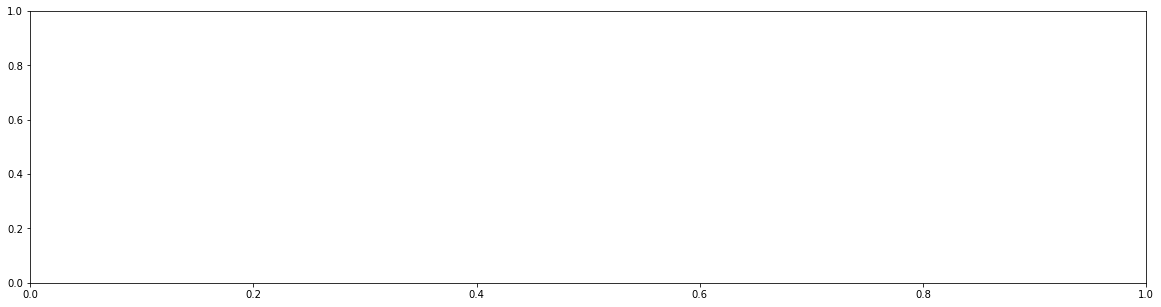

PID: P21, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


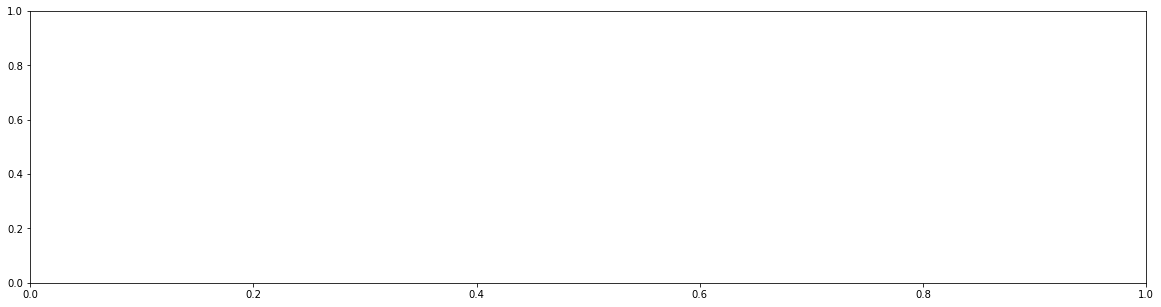

PID: P21, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


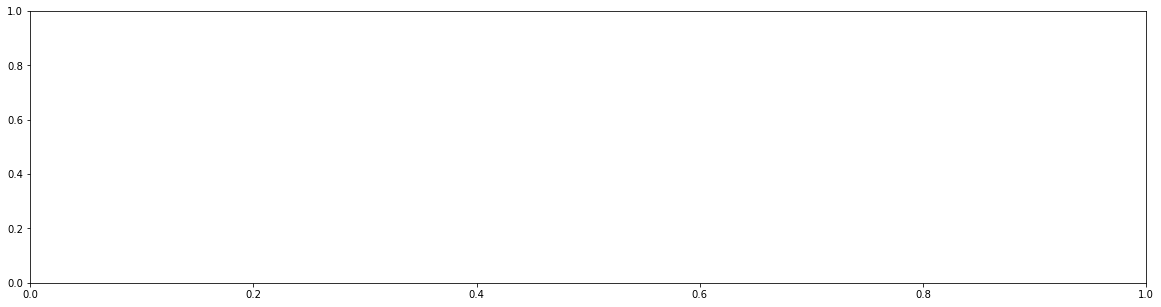

PID: P21, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


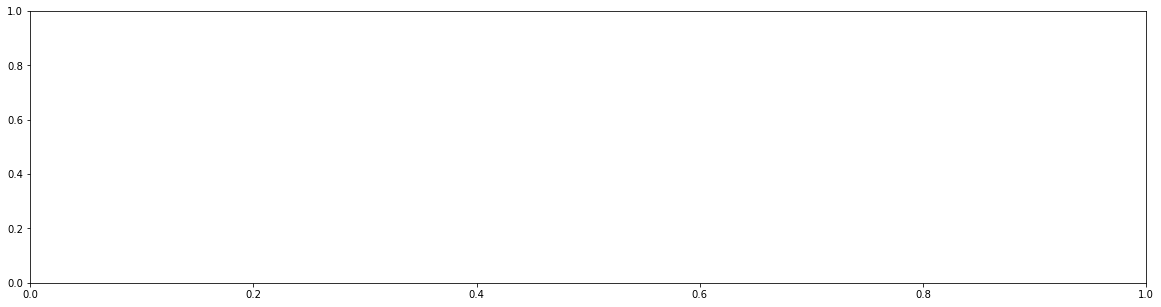

PID: P21, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


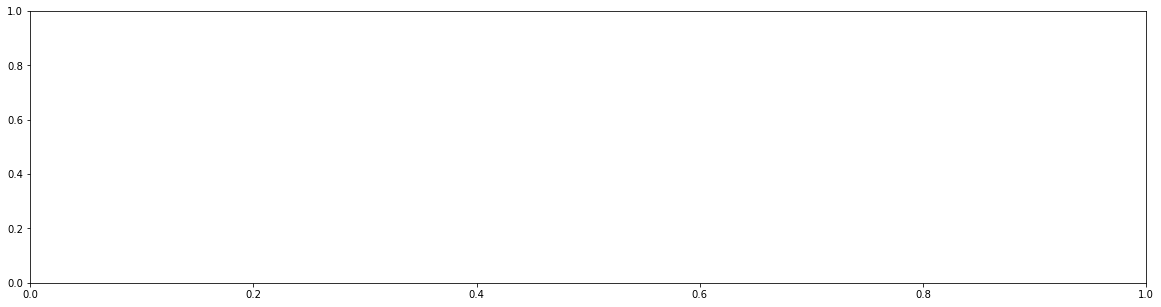

PID: P22, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


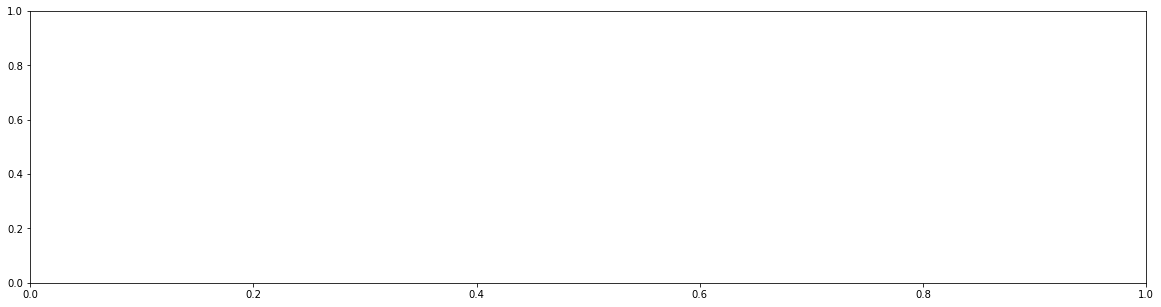

PID: P22, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


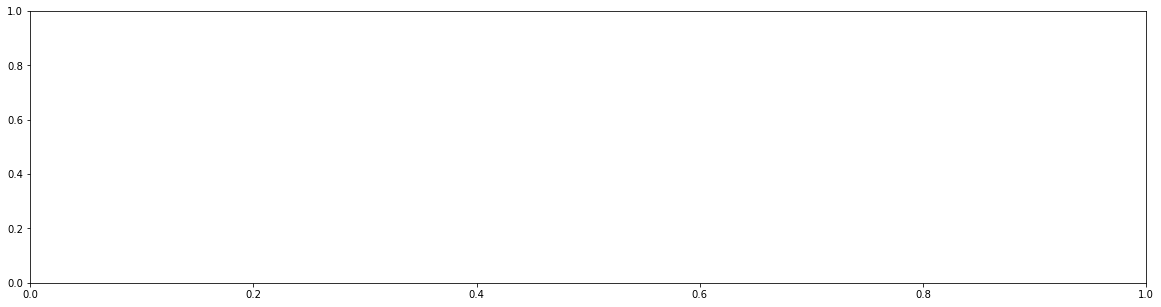

PID: P22, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


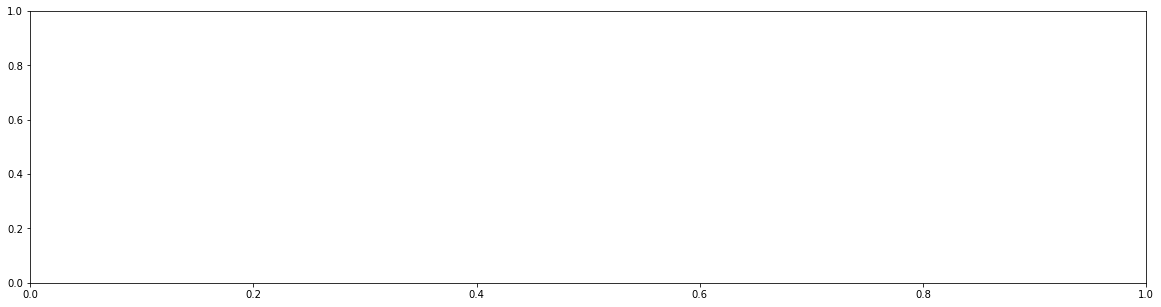

PID: P22, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


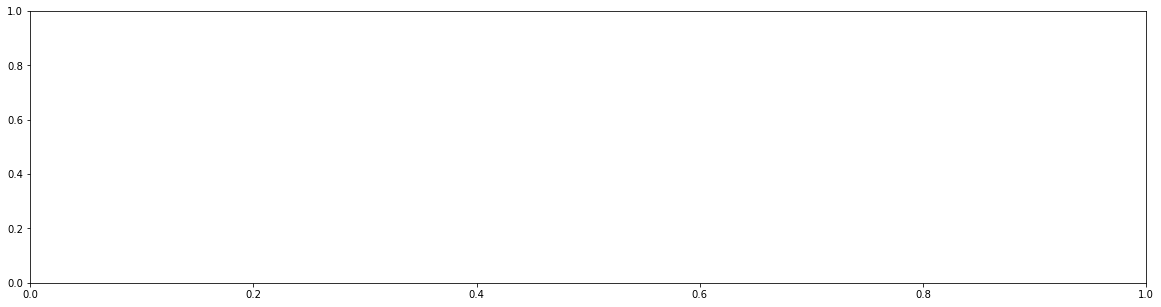

PID: P23, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


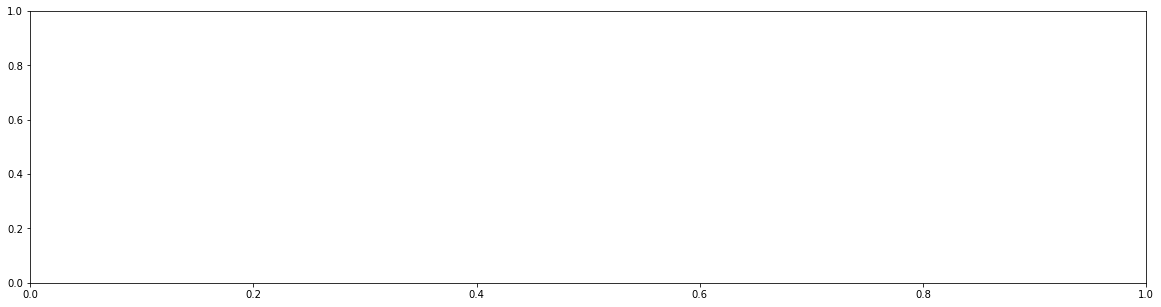

PID: P23, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


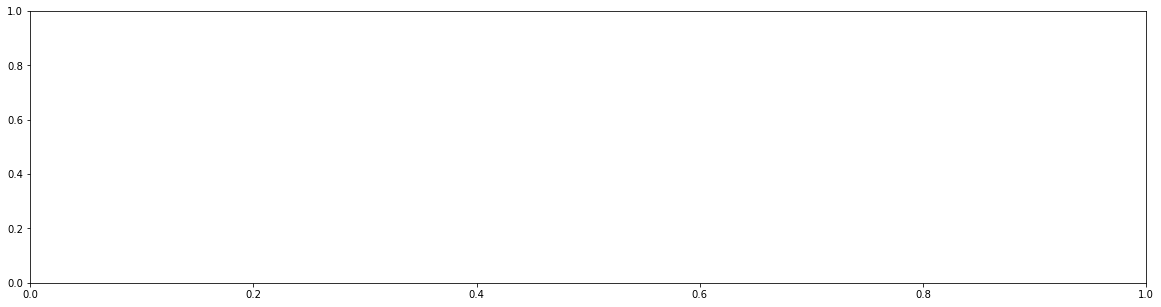

PID: P23, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


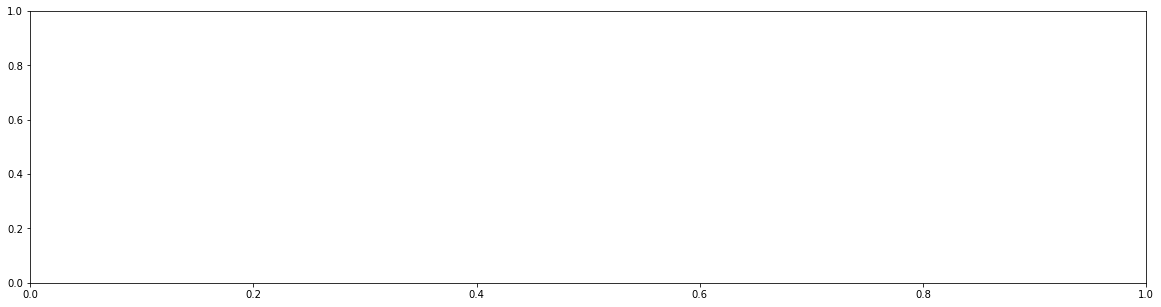

PID: P23, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


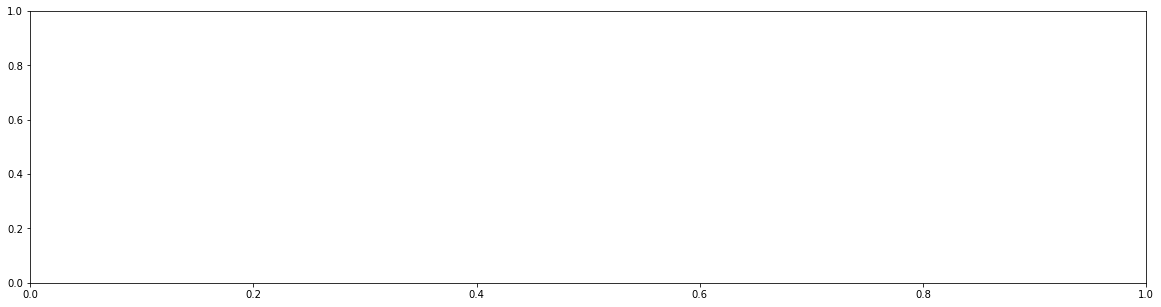

PID: P24, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


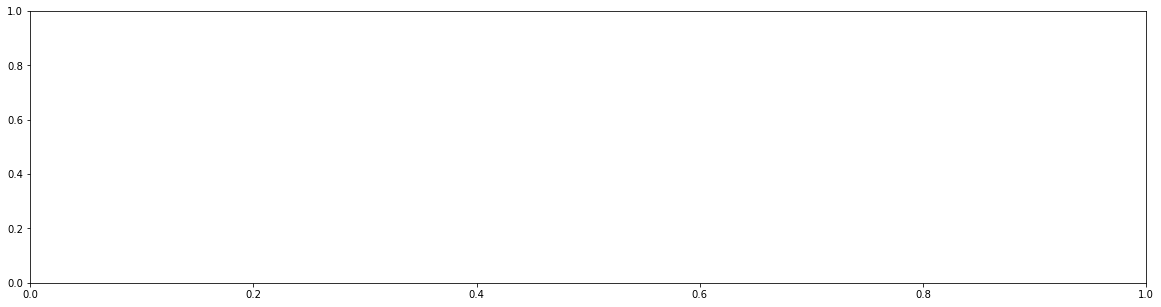

PID: P24, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


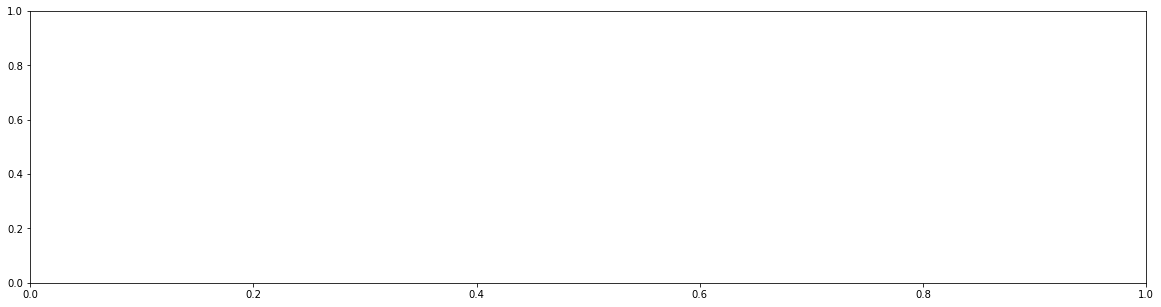

PID: P24, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


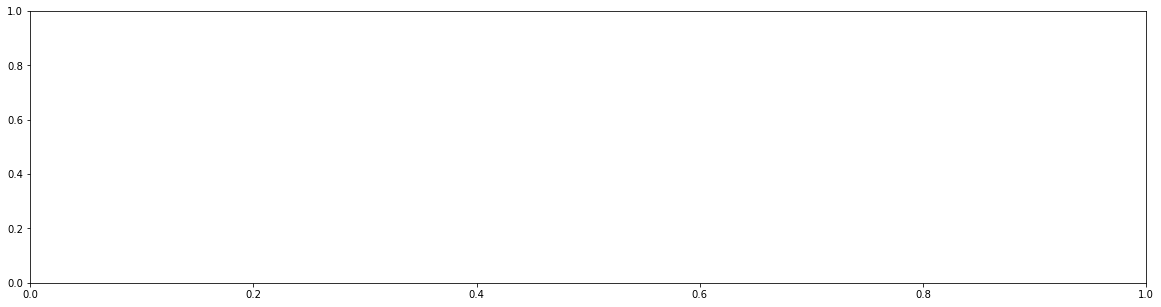

PID: P24, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


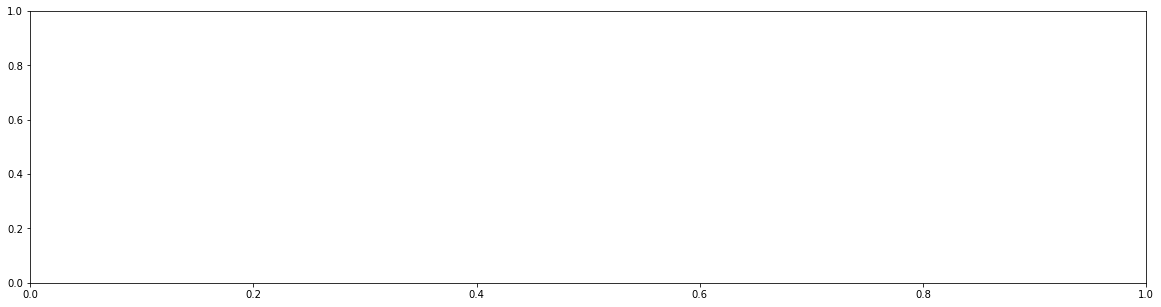

PID: P25, Feature: KISS, Image Shape: (480, 640, 3), Label: Healthy


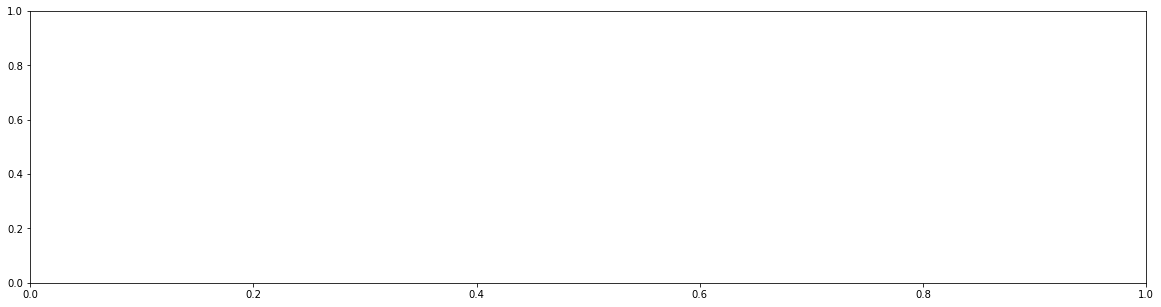

PID: P25, Feature: NORMAL, Image Shape: (480, 640, 3), Label: Healthy


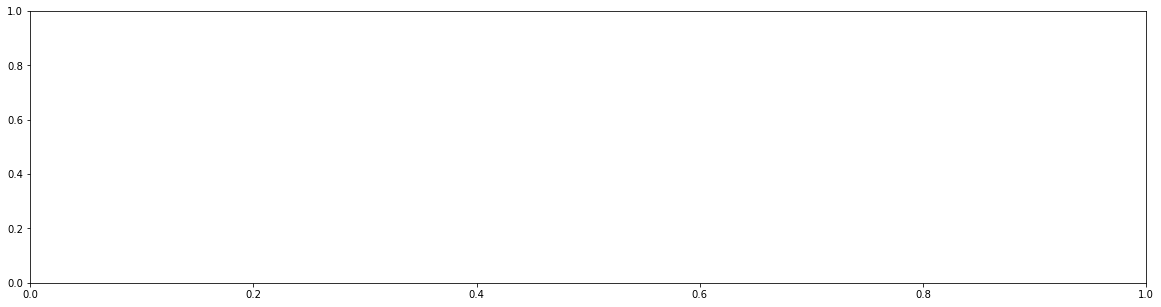

PID: P25, Feature: OPEN, Image Shape: (480, 640, 3), Label: Healthy


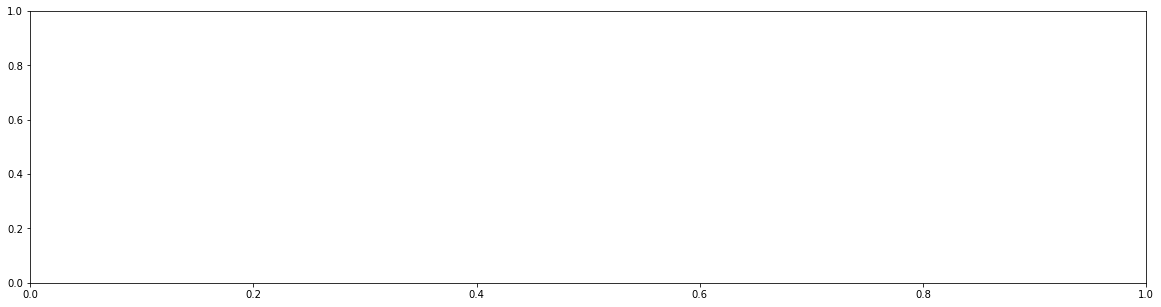

PID: P25, Feature: SPREAD, Image Shape: (480, 640, 3), Label: Healthy


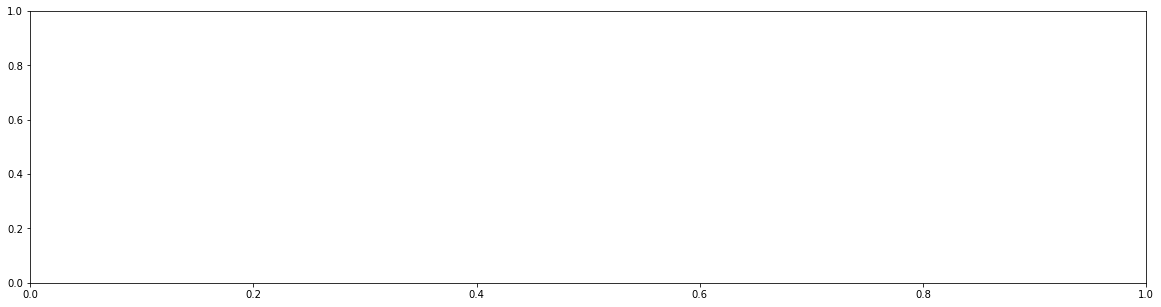

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from torchvision import models
import torch
import torchvision.transforms as transforms
from PIL import Image
import cv2
from skimage.filters import gaussian

# Define the paths to the Stroke and Healthy directories
stroke_dir = r"C:\Users\T00733937\Downloads\Final-results (1)\Final-results\Neuroface_Stroke\Stroke"
healthy_dir = r"C:\Users\T00733937\Downloads\Final-results (1)\Final-results\Neuroface_Stroke\Healthy"

# Initialize a list to store the image paths and corresponding metadata
image_paths = []

# Function to extract pid, feature name, and label from image filenames
def extract_metadata_from_path(image_path, label):
    filename = os.path.basename(image_path)
    print(filename)
    try:
        pid, feature = filename.split('_')
        feature = feature.split('.')[0]  # Remove the .jpg extension
    except ValueError:
        # Handle cases where the filename does not have the expected format
        print(f"Filename {filename} does not match the expected format.")
        return None, None, None
    
    return pid, feature, label

# Loop over the Stroke directory to get images
for root, dirs, files in os.walk(stroke_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(root, file)
            pid, feature, label = extract_metadata_from_path(image_path, 1)  # Label 1 for Stroke
            if pid and feature:
                image_paths.append((image_path, pid, feature, label))

# Loop over the Healthy directory to get images
for root, dirs, files in os.walk(healthy_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(root, file)
            pid, feature, label = extract_metadata_from_path(image_path, 0)  # Label 0 for Healthy
            if pid and feature:
                image_paths.append((image_path, pid, feature, label))

# Define a sharpening filter kernel
def sharpening_filter():
    kernel = np.array([[0, -1, 0],
                       [-1,  5, -1],
                       [0, -1, 0]])
    return kernel

# Apply the sharpening filter to the image
def sharpen_image(image):
    kernel = sharpening_filter()
    
    # For grayscale images
    if image.ndim == 2:
        sharpened = convolve(image, kernel)
    
    # For RGB images (3 channels)
    elif image.ndim == 3 and image.shape[2] == 3:
        sharpened = np.zeros_like(image)
        for i in range(3):  # Apply sharpening filter to each channel
            sharpened[:, :, i] = convolve(image[:, :, i], kernel)
    
    else:
        raise ValueError("Unsupported image shape")

    return np.clip(sharpened, 0, 1)  # Ensure pixel values are within [0, 1] range

# Function to load the DeepLabV3 model
def load_model():
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
    return model

# Function to predict and remove background from numpy array images
def remove_background(image_np, model):
    # Convert the numpy array to a PIL Image
    image = Image.fromarray(image_np.astype('uint8')).convert('RGB')

    # Define the transformations
    transform = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the transformations
    input_image = transform(image).unsqueeze(0)

    # Predict the segmentation mask
    with torch.no_grad():
        output = model(input_image)['out'][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

    # Resize the mask to the original image size
    output_predictions = cv2.resize(output_predictions, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Create a binary mask where the object of interest (e.g., person) is 1 and the background is 0
    mask = (output_predictions == 15).astype(np.uint8)

    # Apply the mask to remove the background
    image_np = image_np * mask[:, :, np.newaxis]

    return image_np

# Function to preprocess the images and store with PID and feature name
def preprocess_images(image_paths, model):
    preprocessed_data = []

    # Loop through each image path
    for image_path, pid, feature, label in image_paths:
        # Load the image
        image = Image.open(image_path).convert('RGB')
        
        # Convert image to numpy array
        image_np = np.array(image)

        # Background removal
        image_segmented = remove_background(image_np, model)

        # Normalize images
        image_segmented = image_segmented / 255.0

        # Denoise images using Gaussian filter
        image_denoised = gaussian(image_segmented, sigma=1, channel_axis=-1)

        # Sharpen images
        image_sharpened = sharpen_image(image_denoised)

        # Store the preprocessed image with the corresponding pid, feature name, and label
        preprocessed_data.append((pid, feature, image_sharpened, label))

    return preprocessed_data

# Load the segmentation model
model = load_model()

# Preprocess the images and store with PID, feature name, and label
preprocessed_data = preprocess_images(image_paths, model)

# Example of accessing the preprocessed data
for pid, feature, image, label in preprocessed_data:
    print(f'PID: {pid}, Feature: {feature}, Image Shape: {image.shape}, Label: {"Stroke" if label == 1 else "Healthy"}')

    # Randomly select an image index
#     random_index = random.randint(0, image.shape[0] - 1)

    # Plot original, segmented, and sharpened images
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))

    # Sharpened image
#     axs[0].imshow(image)
#     axs[0].set_title('Sharpened Image')
#     axs[0].axis('off')

    plt.show()

    



In [8]:
print(combined_df.head())

NameError: name 'combined_df' is not defined

In [10]:
# Display the first few rows of the preprocessed data
print("Features (X):\n", X.head())
print("\nLabels (y):\n", y.head())


Features (X):
    pid       age gender  nhiss  systolic  distolic   glucose smoking  \
0  P01  0.160368      0      5 -0.474838  1.392294  1.555078       1   
1  P02  0.828568      1     19 -0.008294  1.898582  0.942945       0   
2  P03  1.793746      1     18  2.635455 -0.379716  1.281572       2   
3  P04 -2.660922      1      1 -0.060132  1.265721 -0.177128       2   
4  P05 -0.210854      0     12  1.339500 -0.189858  1.529030       0   

        bmi  cholestrol  
0  1.965753    1.049361  
1  0.327625    1.110512  
2  1.380707    0.376694  
3  0.561644    1.232816  
4  0.678653    1.905483  

Labels (y):
 0    1
1    1
2    1
3    1
4    1
Name: risk, dtype: category
Categories (2, int64): [0, 1]


In [11]:
from sklearn.model_selection import train_test_split

# Split the combined DataFrame into training and testing sets
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")


NameError: name 'combined_df' is not defined

In [12]:
import pandas as pd
import numpy as np

# Example preprocessed data structure: [(pid, feature, image, label), ...]
# Assuming preprocessed_data is available and already preprocessed

# Initialize a dictionary to hold the images for each patient with corresponding features
grouped_images = {}

for pid, feature, image, label in preprocessed_data:
    if pid not in grouped_images:
        grouped_images[pid] = {}
    grouped_images[pid][feature] = image  # Store images by their feature names

# Function to combine images and tabular data into a pandas DataFrame
def combine_images_tabular_to_df(grouped_images, tabular_data, labels):
    combined_data = []
 
    for pid, features_dict in grouped_images.items():
        # Find the corresponding row in the tabular data
        tabular_row = tabular_data[tabular_data['pid'] == pid]
        
        if tabular_row.empty:
            print(f"No tabular data found for PID: {pid}")
            continue

        # Retrieve and convert images corresponding to each feature into np.float32 arrays
        image_kiss = np.array(features_dict.get('KISS'), dtype=np.float32) if 'KISS' in features_dict else None
        image_normal = np.array(features_dict.get('NORMAL'), dtype=np.float32) if 'NORMAL' in features_dict else None
        image_spread = np.array(features_dict.get('SPREAD'), dtype=np.float32) if 'SPREAD' in features_dict else None
        image_open = np.array(features_dict.get('OPEN'), dtype=np.float32) if 'OPEN' in features_dict else None

        # Combine the data into a dictionary, including the tabular features as individual columns
        combined_row = {
            'pid': pid,
            'image_kiss': image_kiss if image_kiss is not None else np.array([]),
            'image_normal': image_normal if image_normal is not None else np.array([]),
            'image_spread': image_spread if image_spread is not None else np.array([]),
            'image_open': image_open if image_open is not None else np.array([]),
            'label': np.float32(labels[tabular_row.index[0]])  # Ensure label is float32
        }

        # Add the tabular features to the dictionary
        for col in tabular_data.columns:
            if col != 'pid':  # Exclude the pid column itself
                combined_row[col] = np.float32(tabular_row[col].values[0])  # Ensure feature values are float32

        combined_data.append(combined_row)

    # Convert list of dictionaries to DataFrame
    df = pd.DataFrame(combined_data)
    print(df)
    # Ensure all columns with arrays are properly handled
    for column in df.columns:
        if df[column].apply(lambda x: isinstance(x, np.ndarray)).any():
            # Ensure that columns containing numpy arrays are properly handled
            df[column] = df[column].apply(lambda x: x.astype(np.float32) if isinstance(x, np.ndarray) else x)

    return df

# Combine the images with the corresponding tabular data into a DataFrame
combined_df = combine_images_tabular_to_df(grouped_images, X, y)

# Verify the data types after conversion
print(combined_df.info())


    pid                                         image_kiss  \
0   P01  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
1   P02  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2   P03  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3   P04  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4   P05  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
5   P06  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
6   P07  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
7   P08  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
8   P09  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
9   P10  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
10  P11  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
11  P12  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
12  P13  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
13  P14  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
14  P15  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
15  P16 

In [14]:
import numpy as np

# # Ensure that image columns are converted to numpy arrays of type float32
# def convert_images_to_numpy(df):
#     image_columns = ['image_kiss', 'image_normal', 'image_spread', 'image_open']
#     for col in image_columns:
#         df[col] = df[col].apply(lambda x: np.array(x, dtype=np.float32) if x is not None else None)
#     return df

# # Handle missing values by removing rows with any missing images
# def handle_missing_values(df):
#     # Drop rows where any of the image columns is None
#     df = df.dropna(subset=['image_kiss', 'image_normal', 'image_spread', 'image_open'])
#     return df

# # Convert images to numpy arrays and handle missing values
# combined_df = convert_images_to_numpy(combined_df)
# combined_df = handle_missing_values(combined_df)

# Verify the data types after conversion
print(combined_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pid           25 non-null     object 
 1   image_kiss    25 non-null     object 
 2   image_normal  25 non-null     object 
 3   image_spread  25 non-null     object 
 4   image_open    25 non-null     object 
 5   label         25 non-null     float32
 6   age           25 non-null     float32
 7   gender        25 non-null     float32
 8   nhiss         25 non-null     float32
 9   systolic      25 non-null     float32
 10  distolic      25 non-null     float32
 11  glucose       25 non-null     float32
 12  smoking       25 non-null     float32
 13  bmi           25 non-null     float32
 14  cholestrol    25 non-null     float32
dtypes: float32(10), object(5)
memory usage: 2.1+ KB
None


In [15]:
# # Inspect the first few rows of the image columns
# print(combined_df['image_kiss'].head())
# print(combined_df['image_normal'].head())
# print(combined_df['image_spread'].head())
# print(combined_df['image_open'].head())
# Access the first value in the 'image_kiss' column
first_value = combined_df['image_kiss'].iloc[0].dtype
print(combined_df['image_kiss'].dtype)
# Print the first value
print(first_value)


object
float32


In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pid           25 non-null     object 
 1   image_kiss    25 non-null     object 
 2   image_normal  25 non-null     object 
 3   image_spread  25 non-null     object 
 4   image_open    25 non-null     object 
 5   label         25 non-null     float32
 6   age           25 non-null     float32
 7   gender        25 non-null     float32
 8   nhiss         25 non-null     float32
 9   systolic      25 non-null     float32
 10  distolic      25 non-null     float32
 11  glucose       25 non-null     float32
 12  smoking       25 non-null     float32
 13  bmi           25 non-null     float32
 14  cholestrol    25 non-null     float32
dtypes: float32(10), object(5)
memory usage: 2.1+ KB


In [17]:
import numpy as np

# Define the columns you want to convert
image_columns = ['image_kiss', 'image_normal', 'image_spread', 'image_open']

# Function to convert each value in the specified columns to a numpy float32 array
def convert_columns_to_float32(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: np.array(x, dtype=np.float32) if isinstance(x, np.ndarray) else np.nan)
    return df

# Apply the conversion function to the specified columns
combined_df = convert_columns_to_float32(combined_df, image_columns)

# Verify the conversion by checking the first few rows of each column
print(combined_df['image_kiss'].head())
print(combined_df['image_normal'].head())
print(combined_df['image_spread'].head())
print(combined_df['image_open'].head())


0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
3    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: image_kiss, dtype: object
0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
3    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: image_normal, dtype: object
0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
3    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
Name: image_spread, dtype: object
0    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1    [[[0.0, 0.0, 0.

In [18]:
import numpy as np

# List of image columns
image_columns = ['image_kiss', 'image_normal', 'image_spread', 'image_open']

# Function to ensure all arrays in the specified columns are np.float32
def ensure_float32_columns(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: np.array(x, dtype=np.float32) if isinstance(x, (list, np.ndarray)) else np.nan)
    return df

# Apply the function to the combined_df DataFrame
combined_df = ensure_float32_columns(combined_df, image_columns)

# Verify the conversion by checking the dtype of arrays in each column
for col in image_columns:
    print(f"Column: {col}, dtype of first element: {combined_df[col].iloc[0].dtype}")

# Additionally, check the DataFrame info to confirm the dtypes of columns
print(combined_df.info())


Column: image_kiss, dtype of first element: float32
Column: image_normal, dtype of first element: float32
Column: image_spread, dtype of first element: float32
Column: image_open, dtype of first element: float32
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pid           25 non-null     object 
 1   image_kiss    25 non-null     object 
 2   image_normal  25 non-null     object 
 3   image_spread  25 non-null     object 
 4   image_open    25 non-null     object 
 5   label         25 non-null     float32
 6   age           25 non-null     float32
 7   gender        25 non-null     float32
 8   nhiss         25 non-null     float32
 9   systolic      25 non-null     float32
 10  distolic      25 non-null     float32
 11  glucose       25 non-null     float32
 12  smoking       25 non-null     float32
 13  bmi           25 non-null     float

In [19]:
print(combined_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pid           25 non-null     object 
 1   image_kiss    25 non-null     object 
 2   image_normal  25 non-null     object 
 3   image_spread  25 non-null     object 
 4   image_open    25 non-null     object 
 5   label         25 non-null     float32
 6   age           25 non-null     float32
 7   gender        25 non-null     float32
 8   nhiss         25 non-null     float32
 9   systolic      25 non-null     float32
 10  distolic      25 non-null     float32
 11  glucose       25 non-null     float32
 12  smoking       25 non-null     float32
 13  bmi           25 non-null     float32
 14  cholestrol    25 non-null     float32
dtypes: float32(10), object(5)
memory usage: 2.1+ KB
None


Epoch [1/10], Train Loss: 0.8576, Validation Loss: 1.1242
Epoch [2/10], Train Loss: 0.9657, Validation Loss: 0.7651
Epoch [3/10], Train Loss: 0.6363, Validation Loss: 0.6525
Epoch [4/10], Train Loss: 0.5614, Validation Loss: 0.6208
Epoch [5/10], Train Loss: 0.4530, Validation Loss: 0.6494
Epoch [6/10], Train Loss: 0.4146, Validation Loss: 0.6397
Epoch [7/10], Train Loss: 0.3531, Validation Loss: 0.4813
Epoch [8/10], Train Loss: 0.2406, Validation Loss: 0.4628
Epoch [9/10], Train Loss: 0.2015, Validation Loss: 0.3328
Epoch [10/10], Train Loss: 0.1403, Validation Loss: 0.3014


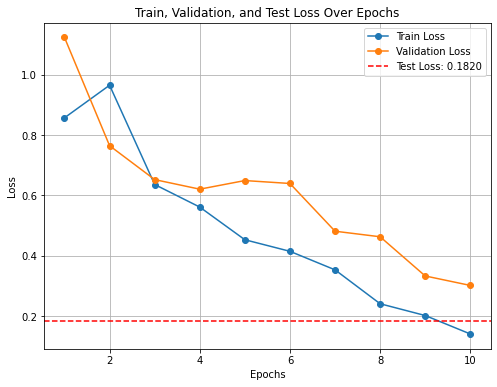

Epoch [1/10], Train Loss: 2.1374, Validation Loss: 1.1196
Epoch [2/10], Train Loss: 0.8559, Validation Loss: 0.8983
Epoch [3/10], Train Loss: 0.7497, Validation Loss: 0.6580
Epoch [4/10], Train Loss: 0.6749, Validation Loss: 0.6439
Epoch [5/10], Train Loss: 0.5865, Validation Loss: 0.6140
Epoch [6/10], Train Loss: 0.5605, Validation Loss: 0.5697
Epoch [7/10], Train Loss: 0.4860, Validation Loss: 0.6022
Epoch [8/10], Train Loss: 0.4360, Validation Loss: 0.4848
Epoch [9/10], Train Loss: 0.5457, Validation Loss: 0.4313
Epoch [10/10], Train Loss: 0.2027, Validation Loss: 0.3938


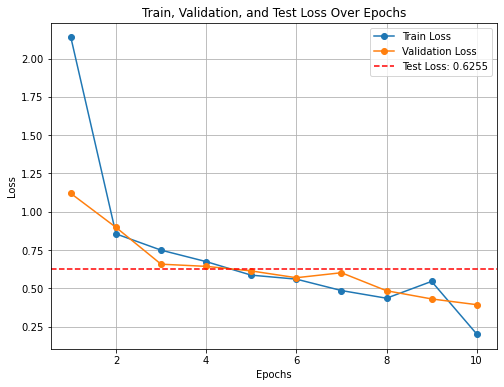

In [22]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------ Define Dataset ------------------------------ #
class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose and reshape
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to tensor
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to tensor
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# ------------------------------ Define Models ------------------------------ #
class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # Based on calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

# ------------------------------ Load and Prepare Data ------------------------------ #
# Load your dataset into a Pandas DataFrame (Ensure 'combined_df' is defined)
# Example: combined_df = pd.read_csv("your_data.csv")

# Split data into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create dataset objects
train_dataset = MultimodalDataset(train_df)
val_dataset = MultimodalDataset(val_df)
test_dataset = MultimodalDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ------------------------------ Training the Model ------------------------------ #
# Initialize model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Compute average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Compute validation loss
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            outputs = model(images, tabular_data).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# ------------------------------ Compute Test Loss ------------------------------ #
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)

# ------------------------------ Plot Losses ------------------------------ #
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o")
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label=f"Test Loss: {avg_test_loss:.4f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train, Validation, and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------ Define Dataset ------------------------------ #
class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose and reshape
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to tensor
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to tensor
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# ------------------------------ Define Models ------------------------------ #
class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # Based on calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

# ------------------------------ Load and Prepare Data ------------------------------ #
# Load your dataset into a Pandas DataFrame (Ensure 'combined_df' is defined)
# Example: combined_df = pd.read_csv("your_data.csv")

# Split data into train (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Create dataset objects
train_dataset = MultimodalDataset(train_df)
val_dataset = MultimodalDataset(val_df)
test_dataset = MultimodalDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ------------------------------ Training the Model ------------------------------ #
# Initialize model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    # Compute average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Compute validation loss
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            outputs = model(images, tabular_data).squeeze()
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# ------------------------------ Compute Test Loss ------------------------------ #
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)

# ------------------------------ Plot Losses ------------------------------ #
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="o")
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label=f"Test Loss: {avg_test_loss:.4f}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train, Validation, and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
##############   Transfer learning ################

Using device: cpu
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5/5

Final Metrics (Average Over Folds):
Average Accuracy: 0.8000
Average Precision: 0.0000
Average Recall: 0.0000
Average F1-score: 0.0000


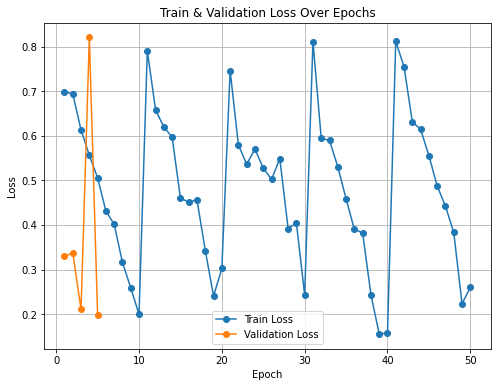

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------ Image Model with Transfer Learning ------------------------------ #
class ImageModelTL(nn.Module):
    def __init__(self):
        super(ImageModelTL, self).__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Freeze early layers
        for param in base_model.parameters():
            param.requires_grad = False  

        # Modify last layer to output 128 features
        base_model.fc = nn.Linear(base_model.fc.in_features, 128)
        self.model = base_model

    def forward(self, x):
        batch_size, num_images, channels, height, width = x.shape  # Expected shape: [batch, 4, 3, 224, 224]
        x = x.view(batch_size * num_images, channels, height, width)  # Flatten images
        features = self.model(x)  # ResNet output [batch * 4, 128]
        features = features.view(batch_size, num_images, -1)  # Reshape back to [batch, 4, 128]
        return torch.mean(features, dim=1)  # Aggregate features: [batch, 128]

# ------------------------------ Tabular Data Model ------------------------------ #
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# ------------------------------ Multimodal Model ------------------------------ #
class MultimodalModelTL(nn.Module):
    def __init__(self, tabular_dim):
        super(MultimodalModelTL, self).__init__()
        self.image_model = ImageModelTL()
        self.tabular_model = TabularModel(tabular_dim)
        self.fc1 = nn.Linear(128 + 16, 64)  # Fuse Image + Tabular features
        self.fc2 = nn.Linear(64, 1)  # Binary classification

    def forward(self, images, tabular_data):
        img_features = self.image_model(images)  # Shape: [batch, 128]
        tab_features = self.tabular_model(tabular_data)  # Shape: [batch, 16]
        fused = torch.cat((img_features, tab_features), dim=1)  # Shape: [batch, 144]
        x = F.relu(self.fc1(fused))
        return torch.sigmoid(self.fc2(x))  # Binary classification output

# ------------------------------ Define Dataset ------------------------------ #
class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((224, 224)), dtype=np.float32)  # ResNet requires 224x224

        # Load images and process
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 224, 224, 3]
        images = images.transpose(0, 3, 1, 2)  # Change to [4, 3, 224, 224]
        images = torch.tensor(images, dtype=torch.float32)

        # Convert tabular data to tensor
        tabular_data = torch.tensor(
            np.array(row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']), dtype=np.float32)
        )

        # Convert label to tensor
        label = torch.tensor(row['label'], dtype=torch.float32)

        return images, tabular_data, label

# ------------------------------ K-Fold Cross-Validation ------------------------------ #
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

metrics_list = []
conf_matrix_sum = np.zeros((2, 2))
train_losses, val_losses = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(combined_df)):
    print(f"Fold {fold + 1}/{k_folds}")

    train_df, test_df = combined_df.iloc[train_idx], combined_df.iloc[test_idx]

    train_dataset = MultimodalDataset(train_df)
    test_dataset = MultimodalDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModelTL(input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10):
        model.train()
        running_train_loss = 0.0
        for images, tabular_data, labels in train_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_losses.append(running_train_loss / len(train_loader))

    # ------------------------------ Evaluation ------------------------------ #
    model.eval()
    true_labels, pred_labels = [], []
    running_val_loss = 0.0

    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            preds = (outputs > 0.5).float().cpu().numpy()
            true_labels.extend(labels.cpu().numpy().flatten())
            pred_labels.extend(preds.flatten())

    val_losses.append(running_val_loss / len(test_loader))
    report = classification_report(true_labels, pred_labels, output_dict=True)
    metrics_list.append(report)
    conf_matrix_sum += confusion_matrix(true_labels, pred_labels)

# ------------------------------ Extract & Compute Final Metrics ------------------------------ #
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for report in metrics_list:
    accuracy_scores.append(report["accuracy"])  # Extract accuracy

    # Check if class "1" exists in the report (Handle missing key error)
    if "1" in report:
        precision_scores.append(report["1"]["precision"])
        recall_scores.append(report["1"]["recall"])
        f1_scores.append(report["1"]["f1-score"])
    else:
        precision_scores.append(0.0)
        recall_scores.append(0.0)
        f1_scores.append(0.0)

# Compute the mean for each metric
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Print the final averaged metrics
print("\nFinal Metrics (Average Over Folds):")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")

# ------------------------------ Plot Train & Validation Loss ------------------------------ #
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train & Validation Loss Over Epochs")
plt.grid(True)
plt.show()


In [ ]:
#model distillation


🔹 Fold 1/5


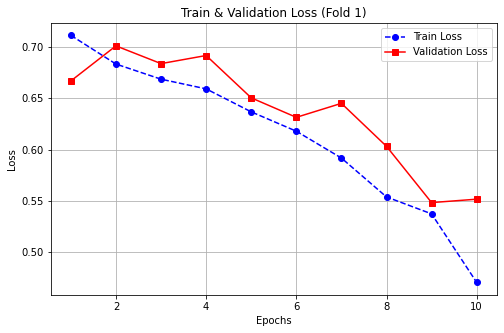


🔹 Classification Report for Fold 1:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


🔹 Fold 2/5


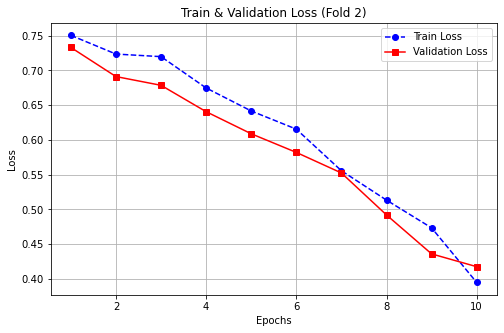


🔹 Classification Report for Fold 2:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


🔹 Fold 3/5


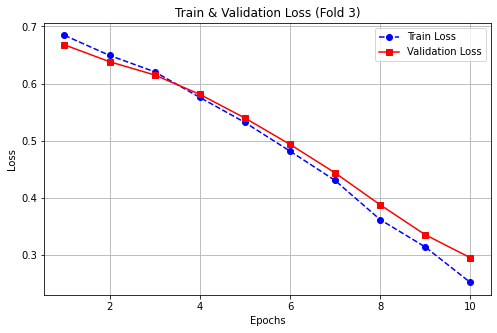


🔹 Classification Report for Fold 3:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.75      0.86         4

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5


🔹 Fold 4/5


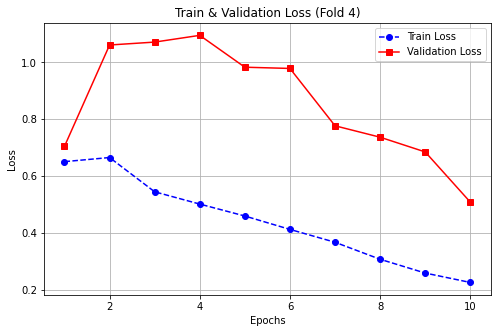


🔹 Classification Report for Fold 4:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


🔹 Fold 5/5


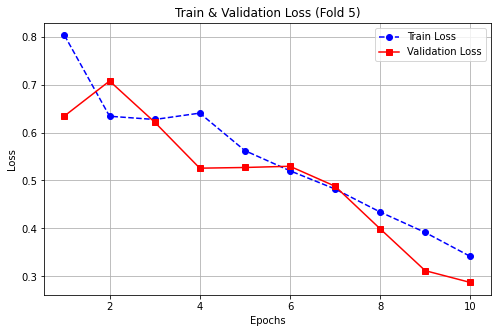


🔹 Classification Report for Fold 5:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


✅ Final Metrics (Average Over All Folds):
Average Accuracy: 0.9600
Average Precision: 0.0000
Average Recall: 0.0000
Average F1-score: 0.0000


In [100]:
# ------------------------------ Train & Validate Model with K-Fold ------------------------------ #
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_losses_per_fold = []
val_losses_per_fold = []
metrics_list = []

num_epochs = 10

for fold, (train_idx, test_idx) in enumerate(kf.split(combined_df)):
    print(f"\n🔹 Fold {fold + 1}/{k_folds}")

    train_df, test_df = combined_df.iloc[train_idx], combined_df.iloc[test_idx]

    train_dataset = MultimodalDataset(train_df)
    test_dataset = MultimodalDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalStudent(input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, tabular_data, labels in train_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ------------------------------ Validation ------------------------------ #
        model.eval()
        running_val_loss = 0.0
        true_labels, pred_labels = [], []

        with torch.no_grad():
            for images, tabular_data, labels in test_loader:
                images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
                outputs = model(images, tabular_data)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                preds = (outputs > 0.5).float().cpu().numpy()
                true_labels.extend(labels.cpu().numpy().flatten())
                pred_labels.extend(preds.flatten())

        avg_val_loss = running_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)

    # Compute Classification Report for Current Fold
    report = classification_report(true_labels, pred_labels, output_dict=True)
    metrics_list.append(report)

    # ------------------------------ Plot Train & Validation Loss for This Fold ------------------------------ #
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", linestyle="--", marker="o", color="blue")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", linestyle="-", marker="s", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Train & Validation Loss (Fold {fold + 1})")
    plt.grid(True)
    plt.show()

    print(f"\n🔹 Classification Report for Fold {fold + 1}:\n", classification_report(true_labels, pred_labels))

# ------------------------------ Compute & Print Final Average Classification Report ------------------------------ #
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for report in metrics_list:
    accuracy_scores.append(report["accuracy"])
    precision_scores.append(report["1"]["precision"] if "1" in report else 0)
    recall_scores.append(report["1"]["recall"] if "1" in report else 0)
    f1_scores.append(report["1"]["f1-score"] if "1" in report else 0)

avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print("\n✅ Final Metrics (Average Over All Folds):")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")

In [101]:
import numpy as np

# Classification report metrics for each fold
metrics = [
    {"accuracy": 1.00, "precision": 1.00, "recall": 1.00, "f1-score": 1.00},  # Fold 1
    {"accuracy": 1.00, "precision": 1.00, "recall": 1.00, "f1-score": 1.00},  # Fold 2
    {"accuracy": 0.80, "precision": 0.75, "recall": 0.88, "f1-score": 0.76},  # Fold 3
    {"accuracy": 1.00, "precision": 1.00, "recall": 1.00, "f1-score": 1.00},  # Fold 4
    {"accuracy": 1.00, "precision": 1.00, "recall": 1.00, "f1-score": 1.00},  # Fold 5
]

# Compute average metrics
avg_accuracy = np.mean([m["accuracy"] for m in metrics])
avg_precision = np.mean([m["precision"] for m in metrics])
avg_recall = np.mean([m["recall"] for m in metrics])
avg_f1_score = np.mean([m["f1-score"] for m in metrics])

avg_accuracy, avg_precision, avg_recall, avg_f1_score


(0.96, 0.95, 0.976, 0.952)

In [ ]:
#transformer model

In [58]:
!pip install torch torchvision transformers sklearn matplotlib numpy seaborn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from transformers import ViTModel
import pandas as pd

# Set device (Use GPU if available, else fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------ Handle Missing Values ------------------------------ #
combined_df = combined_df.fillna(0)  # Replace NaN with 0

# ------------------------------ Vision Transformer Model ------------------------------ #
class ImageTransformerModel(nn.Module):
    def __init__(self):
        super(ImageTransformerModel, self).__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.fc = nn.Linear(768, 128)  # Output from ViT is 768-dim

    def forward(self, x):
        outputs = self.vit(x)
        img_features = self.fc(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token representation
        return img_features

# ------------------------------ Tabular Transformer Model ------------------------------ #
class TabularTransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(TabularTransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=128, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer_encoder(x)
        return x.squeeze(1)

# ------------------------------ Multimodal Transformer Model ------------------------------ #
class MultimodalTransformerModel(nn.Module):
    def __init__(self, tabular_feature_dim):
        super(MultimodalTransformerModel, self).__init__()
        self.image_model = ImageTransformerModel()
        self.tabular_model = TabularTransformerModel(input_dim=tabular_feature_dim)

        self.fc_fusion = nn.Linear(128 + 64, 64)
        self.fc_output = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        img_features = self.image_model(images)
        tab_features = self.tabular_model(tabular_data)

        fused = torch.cat((img_features, tab_features), dim=1)
        x = F.relu(self.fc_fusion(fused))
        x = self.fc_output(x)  # Linear output
        x = torch.sigmoid(x)  # Apply sigmoid before returning
        return x

# ------------------------------ Dataset Class ------------------------------ #
class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract tabular features correctly
        tabular_features = row.drop(["pid", "label"]).values

        # Ensure all elements are flattened and converted to float, handling NaNs
        try:
            tabular_data = np.array(
                [float(np.nan_to_num(x, nan=0.0)) if not isinstance(x, (list, np.ndarray)) else float(np.nanmean(x))
                 for x in tabular_features],
                dtype=np.float32
            )
            tabular_data = torch.tensor(tabular_data, dtype=torch.float32)
        except Exception as e:
            print(f"Error converting row {idx}: {tabular_features}")
            raise e

        # Convert label to tensor (float for BCE Loss)
        label = torch.tensor(float(row["label"]), dtype=torch.float32).unsqueeze(0)  # Ensure shape [1]

        return tabular_data, label

# ------------------------------ Train-Test Split ------------------------------ #
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)

train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ------------------------------ Model Training ------------------------------ #
input_dim = train_df.drop(columns=["pid", "label"]).shape[1]
print(f"Detected input_dim for Tabular Model: {input_dim}")  # Debugging print

model = MultimodalTransformerModel(tabular_feature_dim=input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 Regularization

num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for tabular_data, labels in train_loader:
        tabular_data, labels = tabular_data.to(device), labels.to(device).view(-1, 1).float()  # Ensure labels are float

        # Create dummy images (if only tabular data is available)
        batch_size = tabular_data.shape[0]
        dummy_images = torch.zeros((batch_size, 3, 224, 224)).to(device)

        optimizer.zero_grad()
        outputs = model(dummy_images, tabular_data)

        # Apply Clamping and Sigmoid to ensure outputs are valid probabilities
        outputs = torch.clamp(outputs, min=1e-7, max=1 - 1e-7)

        # Ensure outputs are valid before computing loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

# ------------------------------ Model Evaluation ------------------------------ #
model.eval()
true_labels, pred_labels = [], []

with torch.no_grad():
    for tabular_data, labels in test_loader:
        tabular_data, labels = tabular_data.to(device), labels.to(device).view(-1, 1).float()
        batch_size = tabular_data.shape[0]
        dummy_images = torch.zeros((batch_size, 3, 224, 224)).to(device)

        outputs = model(dummy_images, tabular_data)
        outputs = torch.sigmoid(outputs)  # Ensure valid range

        preds = (outputs > 0.5).float().cpu().numpy()

        true_labels.extend(labels.cpu().numpy().flatten())
        pred_labels.extend(preds.flatten())

# ------------------------------ Compute Final Metrics ------------------------------ #
report = classification_report(true_labels, pred_labels, output_dict=True)

accuracy = report["accuracy"]
precision = report["1"]["precision"] if "1" in report else 0
recall = report["1"]["recall"] if "1" in report else 0
f1_score = report["1"]["f1-score"] if "1" in report else 0

print("\nFinal Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# ------------------------------ Plot Loss Curve ------------------------------ #
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", linestyle="--", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


Using device: cpu
Detected input_dim for Tabular Model: 13


C:\Users\T00733937\AppData\Local\Temp\ipykernel_5076\1200234696.py:83: RuntimeWarning: Mean of empty slice
  [float(np.nan_to_num(x, nan=0.0)) if not isinstance(x, (list, np.ndarray)) else float(np.nanmean(x))


RuntimeError: all elements of input should be between 0 and 1

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()

        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()

        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions",all_predictions)
print("all_labels",all_labels)
# Example: Print out some of the predictions vs actual labels
# for i in range(10):  # Print the first 10 predictions
#     print(f"Prediction: {all_predictions[i]}, Actual: {all_labels[i]}")

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")


Epoch [1/10], Loss: 1.1065
Epoch [2/10], Loss: 0.8181
Epoch [3/10], Loss: 0.6743
Epoch [4/10], Loss: 0.6794
Epoch [5/10], Loss: 0.5458
Epoch [6/10], Loss: 0.5962
Epoch [7/10], Loss: 0.3664
Epoch [8/10], Loss: 0.3661
Epoch [9/10], Loss: 0.2714
Epoch [10/10], Loss: 0.2077
outputs------------------------- tensor([0.8061, 0.3483, 0.5611, 0.2850, 0.6971])
predictions--------------------- tensor([1., 0., 1., 0., 1.])
all_predictions [1.0, 0.0, 1.0, 0.0, 1.0]
all_labels [1.0, 0.0, 1.0, 0.0, 1.0]
Accuracy: 1.0000


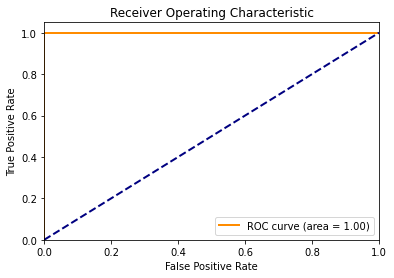

In [48]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


import matplotlib.pyplot as plt

class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
#         print("ImageModel---__init__--self.conv1   ", self.conv1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
#         print("ImageModel---__init__--self.conv2   ", self.conv2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         print("ImageModel---__init__--self.pool   ", self.pool)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size
#         print("ImageModel---__init__--self.fc1   ", self.fc1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         print("ImageModel---forward--self.pool(F.relu(self.conv1(x)))    ", x.shape)
#         self.visualize_feature_maps(x, 'After Conv1 + Pooling')

        x = self.pool(F.relu(self.conv2(x)))
#         print("ImageModel---forward--self.pool(F.relu(self.conv2(x)))   ", x.shape)
#         self.visualize_feature_maps(x, 'After Conv2 + Pooling')

        x = x.view(x.size(0), -1)  # Flatten the output
#         print("ImageModel---forward--x.view(x.size(0), -1)   ", x.shape)

        x = F.relu(self.fc1(x))
#         print("ImageModel---forward--F.relu(self.fc1(x))   ", x.shape)
        return x

    def visualize_feature_maps(self, feature_maps, title):
        # Assuming the feature maps are in shape (batch_size, num_features, height, width)
        num_feature_maps = feature_maps.shape[1]

        plt.figure(figsize=(15, 15))
        for i in range(min(num_feature_maps, 16)):  # Display up to 16 feature maps
            feature_map = feature_maps[0, i].detach().cpu().numpy()

            # Normalize the feature map to the range [0, 1]
            feature_map -= feature_map.min()
            feature_map /= feature_map.max()

            plt.subplot(4, 4, i + 1)
            plt.imshow(feature_map, cmap='viridis')
            plt.axis('off')
        plt.suptitle(title)
        plt.show()



class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
#         print("TabularModel---__init__--self.fc1   ",self.fc1)
        self.fc2 = nn.Linear(64, 32)
#         print("TabularModel---__init__--self.fc2   ",self.fc2)
        self.fc3 = nn.Linear(32, 16)
#         print("TabularModel---__init__--self.fc3   ",self.fc3 )

    def forward(self, x):
        x = F.relu(self.fc1(x))
#         print("TabularModel---forward--F.relu(self.fc1(x))   ",x.shape)
        x = F.relu(self.fc2(x))
#         print("TabularModel---forward--F.relu(self.fc2(x))   ",x.shape)
        x = F.relu(self.fc3(x))
#         print("TabularModel--forward--F.relu(self.fc3(x))   ",x.shape)
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
#         print("MultimodalModel---__init__--self.image_model   ",self.image_model)
        self.tabular_model = TabularModel(input_dim)
#         print("MultimodalModel---__init__--self.tabular_model  ",self.tabular_model)
        self.fc1 = nn.Linear(128 + 16, 64)
#         print("MultimodalModel---__init__--self.fc1  ",self.fc1)
        self.fc2 = nn.Linear(64, 1)
#         print("MultimodalModel---__init__--self.fc2",self.fc2)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
#         print("MultimodalModel---forward--image_features   ",image_features.shape)
        tabular_features = self.tabular_model(tabular_data)
#         print("MultimodalModel---forward--tabular_features   ",tabular_features.shape)
        combined = torch.cat((image_features, tabular_features), dim=1)
#         print("MultimodalModel---forward--combined   ",combined.shape)
        x = F.relu(self.fc1(combined))
#         print("MultimodalModel---forward--x.shape   ",x.shape)
        x = torch.sigmoid(self.fc2(x))
#         print("MultimodalModel--forward--x.shape   ",x.shape)
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()
        print("outputs-------------------------",outputs)
        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()
        print("predictions---------------------",predictions)
        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions",all_predictions)
print("all_labels",all_labels)
# Example: Print out some of the predictions vs actual labels
# for i in range(10):  # Print the first 10 predictions
# print(f"Prediction: {all_predictions[i]}, Actual: {all_labels[i]}")

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [43]:
!pip install torchviz


Defaulting to user installation because normal site-packages is not writeable
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=8daf4e99021732748e50f361ef148423b1df872bdd8a1af89689b4ed73a09721
  Stored in directory: c:\users\t00760303\appdata\local\pip\cache\wheels\29\65\6e\db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [27]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.5, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()

        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()

        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions",all_predictions)
print("all_labels",all_labels)
# Example: Print out some of the predictions vs actual labels
# for i in range(10):  # Print the first 10 predictions
#     print(f"Prediction: {all_predictions[i]}, Actual: {all_labels[i]}")

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")


Epoch [1/10], Loss: 1.2953
Epoch [2/10], Loss: 1.0957
Epoch [3/10], Loss: 0.8293
Epoch [4/10], Loss: 0.6714
Epoch [5/10], Loss: 0.6287
Epoch [6/10], Loss: 0.5779
Epoch [7/10], Loss: 0.5890
Epoch [8/10], Loss: 0.5289
Epoch [9/10], Loss: 0.4645
Epoch [10/10], Loss: 0.4155
all_predictions [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
all_labels [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
Accuracy: 0.7692


In [39]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold
import numpy as np
from PIL import Image
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

# Ensure the columns are categorical
combined_df['smoking'] = combined_df['smoking'].astype('category')
combined_df['gender'] = combined_df['gender'].astype('category')

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Separate categorical and numerical columns
        categorical_columns = ['smoking', 'gender']
        numerical_columns = row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open', 'smoking', 'gender']).index.tolist()
        
        # Convert numerical data to np.float32
        numerical_data = np.array(row[numerical_columns].values, dtype=np.float32)
        numerical_data = torch.tensor(numerical_data)
        print(numerical_data)
        # Convert categorical data to int64 (ensure they're categorical)
        categorical_data = []
        for col in categorical_columns:
            if pd.api.types.is_categorical_dtype(self.data[col]):
                categorical_data.append(row[col].cat.codes)
            else:
                categorical_data.append(row[col])  # Fallback if not categorical
        
        categorical_data = np.array(categorical_data, dtype=np.int64)
        categorical_data = torch.tensor(categorical_data)

        # Combine numerical and categorical data
        tabular_data = torch.cat([numerical_data, categorical_data.float()], dim=0)  # Convert categorical to float for concatenation
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label






# Prepare K-Fold cross-validation
kf = KFold(n_splits=8, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_index, test_index) in enumerate(kf.split(combined_df)):
    print(f"Fold {fold + 1}")

    # Split the data into training and testing sets for the current fold
    train_df = combined_df.iloc[train_index]
    test_df = combined_df.iloc[test_index]

    train_dataset = MultimodalDataset(train_df)
    test_dataset = MultimodalDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # Initialize the model, loss function, and optimizer for each fold
    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 10 
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, tabular_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images, tabular_data).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Put the model in evaluation mode
    model.eval()

    # Disable gradient computation for inference
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            outputs = model(images, tabular_data).squeeze()
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            predictions = (outputs >= 0.5).float()
            all_predictions.extend(predictions.tolist())
            all_labels.extend(labels.tolist())

    correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
    accuracy = correct / len(all_predictions)
    fold_accuracies.append(accuracy)
    print(f'  Fold {fold + 1} Accuracy: {accuracy:.4f}')

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy across all folds: {mean_accuracy:.4f}')



Fold 1


AttributeError: 'numpy.float64' object has no attribute 'cat'

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()

        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()

        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions",all_predictions)
print("all_labels",all_labels)
# Example: Print out some of the predictions vs actual labels
# for i in range(10):  # Print the first 10 predictions
#     print(f"Prediction: {all_predictions[i]}, Actual: {all_labels[i]}")

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")


Epoch [1/10], Loss: 1.1065
Epoch [2/10], Loss: 0.8181
Epoch [3/10], Loss: 0.6743
Epoch [4/10], Loss: 0.6794
Epoch [5/10], Loss: 0.5458
Epoch [6/10], Loss: 0.5962
Epoch [7/10], Loss: 0.3664
Epoch [8/10], Loss: 0.3661
Epoch [9/10], Loss: 0.2715
Epoch [10/10], Loss: 0.2077
all_predictions [1.0, 0.0, 1.0, 0.0, 1.0]
all_labels [1.0, 0.0, 1.0, 0.0, 1.0]
Accuracy: 1.0000


In [37]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define the Tabular Model (With Dropout for Regularization)
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.3)  # Dropout to prevent overfitting
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.fc_out = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Dropout Applied
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc_out(x))  # Probability output


# Prepare Dataset (Only Tabular Data)
class TabularDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract tabular data (drop non-tabular columns)
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)

        # Extract label
        label = torch.tensor(row['label'], dtype=torch.float32)

        return tabular_data, label


# Define Cross-Validation Setup (Stratified K-Fold to maintain class distribution)
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

all_fold_accuracies = []
all_fold_precisions = []
all_fold_recalls = []
all_fold_f1_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(combined_df, combined_df['label'])):
    print(f"\n Fold {fold + 1}/{k_folds}:")

    train_df = combined_df.iloc[train_idx]
    test_df = combined_df.iloc[test_idx]

    train_dataset = TabularDataset(train_df)
    test_dataset = TabularDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Increased batch size
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Initialize Model, Loss, and Optimizer
    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    tabular_model = TabularModel(input_dim=input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(tabular_model.parameters(), lr=0.0005, weight_decay=1e-5)  #  Lower LR + L2 Regularization

    # Train Tabular Model
    num_epochs = 15  #  Increased training epochs for better generalization
    for epoch in range(num_epochs):
        tabular_model.train()
        running_loss = 0.0
        for tabular_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = tabular_model(tabular_data).squeeze()

            # Ensure outputs is always a tensor
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate Model
    tabular_model.eval()
    all_predictions, all_labels = [], []

    with torch.no_grad():
        for tabular_data, labels in test_loader:
            outputs = tabular_model(tabular_data).squeeze()

            # Ensure outputs is always a tensor
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            predictions = (outputs >= 0.5).float()

            # Convert to lists properly
            all_predictions.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Calculate Accuracy, Precision, Recall, and F1-score for the Fold
    fold_accuracy = sum([pred == label for pred, label in zip(all_predictions, all_labels)]) / len(all_predictions)
    fold_precision = precision_score(all_labels, all_predictions, zero_division=0)
    fold_recall = recall_score(all_labels, all_predictions, zero_division=0)
    fold_f1 = f1_score(all_labels, all_predictions, zero_division=0)

    all_fold_accuracies.append(fold_accuracy)
    all_fold_precisions.append(fold_precision)
    all_fold_recalls.append(fold_recall)
    all_fold_f1_scores.append(fold_f1)

    print(f" Fold {fold+1} Metrics: Accuracy={fold_accuracy:.4f}, Precision={fold_precision:.4f}, Recall={fold_recall:.4f}, F1-score={fold_f1:.4f}")

# Print Average Metrics Across All Folds
print("\n Final Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(all_fold_accuracies):.4f} ± {np.std(all_fold_accuracies):.4f}")
print(f"Average Precision: {np.mean(all_fold_precisions):.4f} ± {np.std(all_fold_precisions):.4f}")
print(f"Average Recall: {np.mean(all_fold_recalls):.4f} ± {np.std(all_fold_recalls):.4f}")
print(f"Average F1-score: {np.mean(all_fold_f1_scores):.4f} ± {np.std(all_fold_f1_scores):.4f}")



 Fold 1/5:
  Epoch [1/15], Loss: 0.7219
  Epoch [2/15], Loss: 0.7173
  Epoch [3/15], Loss: 0.6746
  Epoch [4/15], Loss: 0.6746
  Epoch [5/15], Loss: 0.6428
  Epoch [6/15], Loss: 0.6194
  Epoch [7/15], Loss: 0.6228
  Epoch [8/15], Loss: 0.6292
  Epoch [9/15], Loss: 0.5843
  Epoch [10/15], Loss: 0.5785
  Epoch [11/15], Loss: 0.5585
  Epoch [12/15], Loss: 0.5455
  Epoch [13/15], Loss: 0.5309
  Epoch [14/15], Loss: 0.5316
  Epoch [15/15], Loss: 0.4969
 Fold 1 Metrics: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1-score=1.0000

 Fold 2/5:
  Epoch [1/15], Loss: 0.6938
  Epoch [2/15], Loss: 0.6947
  Epoch [3/15], Loss: 0.6585
  Epoch [4/15], Loss: 0.6527
  Epoch [5/15], Loss: 0.5979
  Epoch [6/15], Loss: 0.6162
  Epoch [7/15], Loss: 0.5917
  Epoch [8/15], Loss: 0.5956
  Epoch [9/15], Loss: 0.5787
  Epoch [10/15], Loss: 0.5310
  Epoch [11/15], Loss: 0.5253
  Epoch [12/15], Loss: 0.5447
  Epoch [13/15], Loss: 0.4926
  Epoch [14/15], Loss: 0.4404
  Epoch [15/15], Loss: 0.4747
 Fold 2 Met

In [35]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define the Image Model
class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))  # Probability output


# Prepare Dataset (Only Image Data)
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)

        # Extract label
        label = torch.tensor(row['label'], dtype=torch.float32)

        return images, label


# Define the Cross-Validation Setup
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

all_fold_accuracies = []
all_fold_precisions = []
all_fold_recalls = []
all_fold_f1_scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(combined_df)):
    print(f"\nFold {fold + 1}/{k_folds}:")

    train_df = combined_df.iloc[train_idx]
    test_df = combined_df.iloc[test_idx]

    train_dataset = ImageDataset(train_df)
    test_dataset = ImageDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # Initialize Model, Loss, and Optimizer
    output_size = 32 * 120 * 160  # Assuming CNN output size
    image_model = ImageModel(output_size=output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(image_model.parameters(), lr=0.001)

    # Train Image Model
    num_epochs = 10
    for epoch in range(num_epochs):
        image_model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = image_model(images).squeeze()

            # Ensure outputs is always a tensor
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Evaluate Model
    image_model.eval()
    all_predictions, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = image_model(images).squeeze()

            # Ensure outputs is always a tensor
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            predictions = (outputs >= 0.5).float()

            # Convert to lists properly
            all_predictions.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    # Calculate Accuracy, Precision, Recall, and F1-score for the Fold
    fold_accuracy = sum([pred == label for pred, label in zip(all_predictions, all_labels)]) / len(all_predictions)
    fold_precision = precision_score(all_labels, all_predictions, zero_division=0)
    fold_recall = recall_score(all_labels, all_predictions, zero_division=0)
    fold_f1 = f1_score(all_labels, all_predictions, zero_division=0)

    all_fold_accuracies.append(fold_accuracy)
    all_fold_precisions.append(fold_precision)
    all_fold_recalls.append(fold_recall)
    all_fold_f1_scores.append(fold_f1)

    print(f" Fold {fold+1} Metrics: Accuracy={fold_accuracy:.4f}, Precision={fold_precision:.4f}, Recall={fold_recall:.4f}, F1-score={fold_f1:.4f}")

# Print Average Metrics Across All Folds
print("\n Final Cross-Validation Results:")
print(f"Average Accuracy: {np.mean(all_fold_accuracies):.4f} ± {np.std(all_fold_accuracies):.4f}")
print(f"Average Precision: {np.mean(all_fold_precisions):.4f} ± {np.std(all_fold_precisions):.4f}")
print(f"Average Recall: {np.mean(all_fold_recalls):.4f} ± {np.std(all_fold_recalls):.4f}")
print(f"Average F1-score: {np.mean(all_fold_f1_scores):.4f} ± {np.std(all_fold_f1_scores):.4f}")



Fold 1/5:
  Epoch [1/10], Loss: 4.7018
  Epoch [2/10], Loss: 0.7057
  Epoch [3/10], Loss: 0.6944
  Epoch [4/10], Loss: 0.7351
  Epoch [5/10], Loss: 0.6807
  Epoch [6/10], Loss: 0.6957
  Epoch [7/10], Loss: 0.6604
  Epoch [8/10], Loss: 0.5753
  Epoch [9/10], Loss: 0.5675
  Epoch [10/10], Loss: 0.5375
 Fold 1 Metrics: Accuracy=0.8000, Precision=0.7500, Recall=1.0000, F1-score=0.8571

Fold 2/5:
  Epoch [1/10], Loss: 1.3992
  Epoch [2/10], Loss: 0.8084
  Epoch [3/10], Loss: 0.7672
  Epoch [4/10], Loss: 0.5327
  Epoch [5/10], Loss: 0.5020
  Epoch [6/10], Loss: 0.4777
  Epoch [7/10], Loss: 0.4680
  Epoch [8/10], Loss: 0.4092
  Epoch [9/10], Loss: 0.4041
  Epoch [10/10], Loss: 0.4112
 Fold 2 Metrics: Accuracy=0.8000, Precision=0.8000, Recall=1.0000, F1-score=0.8889

Fold 3/5:
  Epoch [1/10], Loss: 1.8573
  Epoch [2/10], Loss: 1.1239
  Epoch [3/10], Loss: 0.6943
  Epoch [4/10], Loss: 0.7211
  Epoch [5/10], Loss: 0.6706
  Epoch [6/10], Loss: 0.6875
  Epoch [7/10], Loss: 0.6037
  Epoch [8/10], 

In [105]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
from sklearn.model_selection import KFold
import numpy as np
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)
        self.fc2 = nn.Linear(128, 1)  # **Added final classification layer**

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # **Output single probability**
        return x


class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc_out = nn.Linear(16, 1)  # Final output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc_out(x))  # Correct final layer
        return x


class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x


class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        images = np.stack([image_kiss, image_normal, image_spread, image_open])
        images = images.transpose(0, 3, 1, 2)
        images = images.reshape(-1, images.shape[2], images.shape[3])
        images = torch.tensor(images)

        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)

        label = torch.tensor(row['label'], dtype=torch.float32)

        return images, tabular_data, label


def train_model(model, train_loader, num_epochs=10, is_multimodal=False, is_image_model=False):
    model.train()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, tabular_data, labels in train_loader:
            optimizer.zero_grad()
            
            # Forward pass: Choose the correct input
            if is_multimodal:
                outputs = model(images, tabular_data).squeeze()
            elif is_image_model:
                outputs = model(images).squeeze()  # Image model takes only images
            else:
                outputs = model(tabular_data).squeeze()  # Tabular model takes only tabular data
            
            # Ensure outputs is a tensor
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader, model_type="multimodal"):
    """
    Evaluates the model on the test data.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_loader (DataLoader): The DataLoader for test data.
        model_type (str): "image", "tabular", or "multimodal".

    Returns:
        float: Accuracy score.
    """
    model.eval()
    all_predictions, all_labels = [], []
    
    with torch.no_grad():
        for images, tabular_data, labels in test_loader:
            if model_type == "multimodal":
                outputs = model(images, tabular_data).squeeze()  # Use both inputs
            elif model_type == "image":
                outputs = model(images).squeeze()  # Only use image data
            elif model_type == "tabular":
                outputs = model(tabular_data).squeeze()  # Only use tabular data
            else:
                raise ValueError("Invalid model_type. Choose from ['image', 'tabular', 'multimodal']")

            # Ensure outputs are properly shaped
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)

            outputs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predictions = (outputs >= 0.5).float()

            all_predictions.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
    accuracy = correct / len(all_predictions)
    return accuracy


# K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

image_accuracies, tabular_accuracies, multimodal_accuracies = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(combined_df)):
    print(f"\nFold {fold + 1}/{k_folds}:")

    train_df = combined_df.iloc[train_idx]
    test_df = combined_df.iloc[test_idx]

    train_dataset = MultimodalDataset(train_df)
    test_dataset = MultimodalDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]

    # Train Image Model
    print("Training Image Model...")
    image_model = ImageModel(output_size=32 * 120 * 160)
    train_model(image_model, train_loader, is_image_model=True)
    image_accuracy = evaluate_model(image_model, test_loader, model_type="image")
    image_accuracies.append(image_accuracy)
    print(f"Image Model Accuracy: {image_accuracy:.4f}")

    # Train Tabular Model
    print("Training Tabular Model...")
    tabular_model = TabularModel(input_dim=input_dim)
    train_model(tabular_model, train_loader)
    tabular_accuracy = evaluate_model(tabular_model, test_loader, model_type="tabular")
    tabular_accuracies.append(tabular_accuracy)
    print(f"Tabular Model Accuracy: {tabular_accuracy:.4f}")

    # Train Multimodal Model
    print("Training Multimodal Model...")
    multimodal_model = MultimodalModel(input_dim=input_dim)
    train_model(multimodal_model, train_loader, is_multimodal=True)
    multimodal_accuracy = evaluate_model(multimodal_model, test_loader, model_type="multimodal")
    multimodal_accuracies.append(multimodal_accuracy)
    print(f"Multimodal Model Accuracy: {multimodal_accuracy:.4f}")

    
    
# Final Results
print("\nFinal Cross-Validation Results:")
print(f"Average Image Model Accuracy: {np.mean(image_accuracies):.4f}")
print(f"Average Tabular Model Accuracy: {np.mean(tabular_accuracies):.4f}")
print(f"Average Multimodal Model Accuracy: {np.mean(multimodal_accuracies):.4f}")



Fold 1/5:
Training Image Model...
Epoch [1/10], Loss: 4.7018
Epoch [2/10], Loss: 0.7057
Epoch [3/10], Loss: 0.6944
Epoch [4/10], Loss: 0.7351
Epoch [5/10], Loss: 0.6807
Epoch [6/10], Loss: 0.6957
Epoch [7/10], Loss: 0.6604
Epoch [8/10], Loss: 0.5753
Epoch [9/10], Loss: 0.5675
Epoch [10/10], Loss: 0.5375
Image Model Accuracy: 0.6000
Training Tabular Model...
Epoch [1/10], Loss: 0.5958
Epoch [2/10], Loss: 0.5258
Epoch [3/10], Loss: 0.4722
Epoch [4/10], Loss: 0.4218
Epoch [5/10], Loss: 0.3858
Epoch [6/10], Loss: 0.3483
Epoch [7/10], Loss: 0.3173
Epoch [8/10], Loss: 0.2899
Epoch [9/10], Loss: 0.2673
Epoch [10/10], Loss: 0.2449
Tabular Model Accuracy: 0.6000
Training Multimodal Model...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x2 and 144x64)

In [103]:
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F
# from sklearn.model_selection import train_test_split, KFold
# import numpy as np
# from PIL import Image
# import random

# # Set random seeds for reproducibility
# random.seed(42)
# np.random.seed(42)
# torch.manual_seed(42)

# class ImageModel(nn.Module):
#     def __init__(self, output_size):
#         super(ImageModel, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)  # Flatten the output
#         x = F.relu(self.fc1(x))
#         return x

# class TabularModel(nn.Module):
#     def __init__(self, input_dim):
#         super(TabularModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         return x

# class MultimodalModel(nn.Module):
#     def __init__(self, input_dim):
#         super(MultimodalModel, self).__init__()
#         output_size = 32 * 120 * 160  # Adjusted based on your input image size
#         self.image_model = ImageModel(output_size=output_size)
#         self.tabular_model = TabularModel(input_dim)
#         self.fc1 = nn.Linear(128 + 16, 64)
#         self.fc2 = nn.Linear(64, 1)

#     def forward(self, images, tabular_data):
#         image_features = self.image_model(images)
#         tabular_features = self.tabular_model(tabular_data)
#         combined = torch.cat((image_features, tabular_features), dim=1)
#         x = F.relu(self.fc1(combined))
#         x = torch.sigmoid(self.fc2(x))
#         return x

# class MultimodalDataset(Dataset):
#     def __init__(self, dataframe):
#         self.data = dataframe

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]

#         def load_image(image_array):
#             image = Image.fromarray(np.uint8(image_array))
#             if image.mode != 'RGB':
#                 image = image.convert('RGB')
#             return np.array(image.resize((640, 480)), dtype=np.float32)

#         # Load images, resize to (480, 640), and convert to np.float32
#         image_kiss = load_image(row['image_kiss'])
#         image_normal = load_image(row['image_normal'])
#         image_spread = load_image(row['image_spread'])
#         image_open = load_image(row['image_open'])

#         # Ensure all images have the same shape
#         assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
#             "All images must have the same shape!"
        
#         # Stack images
#         images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
#         # Transpose and reshape images to [12, 480, 640]
#         images = images.transpose(0, 3, 1, 2).reshape(-1, images.shape[2], images.shape[3])
#         images = torch.tensor(images)  # Convert to torch tensor
        
#         # Convert tabular data to np.float32
#         tabular_data = torch.tensor(row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values, dtype=torch.float32)
        
#         # Convert label to np.float32
#         label = torch.tensor(row['label'], dtype=torch.float32)
        
#         return images, tabular_data, label

# Split data into train and test sets
train_df, test_df = train_test_split(combined_df, test_size=0.1, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Fold {fold + 1}")

    # Create the training and validation datasets for the current fold
    train_fold_df = train_df.iloc[train_index]
    val_fold_df = train_df.iloc[val_index]

    train_dataset = MultimodalDataset(train_fold_df)
    val_dataset = MultimodalDataset(val_fold_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # Initialize the model, loss function, and optimizer for each fold
    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, tabular_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation loop
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            predictions = (outputs >= 0.5).float()
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    correct = sum([pred == label for pred, label in zip(val_predictions, val_labels)])
    accuracy = correct / len(val_predictions)
    fold_accuracies.append(accuracy)
    print(f'Fold {fold + 1} Validation Accuracy: {accuracy:.4f}')

# Average accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Cross-Validation Accuracy: {mean_accuracy:.4f}')

# Now test on the test dataset
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, tabular_data, labels in DataLoader(MultimodalDataset(test_df), batch_size=4, shuffle=False):
        outputs = model(images, tabular_data).view(-1)
        predictions = (outputs >= 0.5).float()
        test_predictions.extend(predictions.tolist())
        test_labels.extend(labels.tolist())

correct = sum([pred == label for pred, label in zip(test_predictions, test_labels)])
test_accuracy = correct / len(test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")


Fold 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x16 and 64x32)

In [104]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Split data into train and test sets
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Fold {fold + 1}")

    # Create the training and validation datasets for the current fold
    train_fold_df = train_df.iloc[train_index]
    val_fold_df = train_df.iloc[val_index]

    train_dataset = MultimodalDataset(train_fold_df)
    val_dataset = MultimodalDataset(val_fold_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # Initialize the model, loss function, and optimizer for each fold
    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, tabular_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation loop
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            predictions = (outputs >= 0.5).float()
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    # Calculate metrics
    accuracy = accuracy_score(val_labels, val_predictions)
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)

    # Append metrics for this fold
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    # Print classification report for this fold
    print(f'Fold {fold + 1} Classification Report:')
    print(classification_report(val_labels, val_predictions))

    print(f'Fold {fold + 1} Validation Accuracy: {accuracy:.4f}')
    print(f'Fold {fold + 1} Validation Precision: {precision:.4f}')
    print(f'Fold {fold + 1} Validation Recall: {recall:.4f}')
    print(f'Fold {fold + 1} Validation F1 Score: {f1:.4f}')

# Average metrics across all folds
mean_accuracy = np.mean(fold_accuracies)
mean_precision = np.mean(fold_precisions)
mean_recall = np.mean(fold_recalls)
mean_f1_score = np.mean(fold_f1_scores)

print(f'\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}')
print(f'Mean Cross-Validation Precision: {mean_precision:.4f}')
print(f'Mean Cross-Validation Recall: {mean_recall:.4f}')
print(f'Mean Cross-Validation F1 Score: {mean_f1_score:.4f}')

# Now test on the test dataset
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, tabular_data, labels in DataLoader(MultimodalDataset(test_df), batch_size=4, shuffle=False):
        outputs = model(images, tabular_data).view(-1)
        predictions = (outputs >= 0.5).float()
        test_predictions.extend(predictions.tolist())
        test_labels.extend(labels.tolist())

# Calculate and print metrics for the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1_score = f1_score(test_labels, test_predictions)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Print test classification report
print('\nTest Classification Report:')
print(classification_report(test_labels, test_predictions))


Fold 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x16 and 64x32)

CV 0.3

In [50]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Split data into train and test sets
train_df, test_df = train_test_split(combined_df, test_size=0.3, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Fold {fold + 1}")

    # Create the training and validation datasets for the current fold
    train_fold_df = train_df.iloc[train_index]
    val_fold_df = train_df.iloc[val_index]

    train_dataset = MultimodalDataset(train_fold_df)
    val_dataset = MultimodalDataset(val_fold_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # Initialize the model, loss function, and optimizer for each fold
    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, tabular_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation loop
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            predictions = (outputs >= 0.5).float()
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    # Calculate metrics
    accuracy = accuracy_score(val_labels, val_predictions)
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)

    # Append metrics for this fold
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    # Print classification report for this fold
    print(f'Fold {fold + 1} Classification Report:')
    print(classification_report(val_labels, val_predictions))

    print(f'Fold {fold + 1} Validation Accuracy: {accuracy:.4f}')
    print(f'Fold {fold + 1} Validation Precision: {precision:.4f}')
    print(f'Fold {fold + 1} Validation Recall: {recall:.4f}')
    print(f'Fold {fold + 1} Validation F1 Score: {f1:.4f}')

# Average metrics across all folds
mean_accuracy = np.mean(fold_accuracies)
mean_precision = np.mean(fold_precisions)
mean_recall = np.mean(fold_recalls)
mean_f1_score = np.mean(fold_f1_scores)

print(f'\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}')
print(f'Mean Cross-Validation Precision: {mean_precision:.4f}')
print(f'Mean Cross-Validation Recall: {mean_recall:.4f}')
print(f'Mean Cross-Validation F1 Score: {mean_f1_score:.4f}')

# Now test on the test dataset
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, tabular_data, labels in DataLoader(MultimodalDataset(test_df), batch_size=4, shuffle=False):
        outputs = model(images, tabular_data).view(-1)
        predictions = (outputs >= 0.5).float()
        test_predictions.extend(predictions.tolist())
        test_labels.extend(labels.tolist())

# Calculate and print metrics for the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1_score = f1_score(test_labels, test_predictions)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Print test classification report
print('\nTest Classification Report:')
print(classification_report(test_labels, test_predictions))


Fold 1
Fold 1 Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.50      0.67         2

    accuracy                           0.75         4
   macro avg       0.83      0.75      0.73         4
weighted avg       0.83      0.75      0.73         4

Fold 1 Validation Accuracy: 0.7500
Fold 1 Validation Precision: 1.0000
Fold 1 Validation Recall: 0.5000
Fold 1 Validation F1 Score: 0.6667
Fold 2
Fold 2 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Fold 2 Validation Accuracy: 1.0000
Fold 2 Validation Precision: 1.0000
Fold 2 Validation Recall: 1.0000
Fold 2 Validation F1 Score: 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Fold 4 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

Fold 4 Validation Accuracy: 1.0000
Fold 4 Validation Precision: 0.0000
Fold 4 Validation Recall: 0.0000
Fold 4 Validation F1 Score: 0.0000
Fold 5
Fold 5 Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.80         3

    accuracy                           0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3

Fold 5 Validation Accuracy: 0.6667
Fold 5 Validation Precision: 1.0000
Fold 5 Validation Recall: 0.6667
Fold 5 Validation F1 Score: 0.8000

Mean Cross-Validation Accuracy: 0.8833
Mean Cross-Vali

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Test Accuracy: 0.8750
Test Precision: 1.0000
Test Recall: 0.8333
Test F1 Score: 0.9091

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8



In [ ]:
###################### CV 

In [37]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Split data into train and test sets
train_df, test_df = train_test_split(combined_df, test_size=0.5, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Fold {fold + 1}")

    # Create the training and validation datasets for the current fold
    train_fold_df = train_df.iloc[train_index]
    val_fold_df = train_df.iloc[val_index]

    train_dataset = MultimodalDataset(train_fold_df)
    val_dataset = MultimodalDataset(val_fold_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # Initialize the model, loss function, and optimizer for each fold
    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, tabular_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation loop
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            predictions = (outputs >= 0.5).float()
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    # Calculate metrics
    accuracy = accuracy_score(val_labels, val_predictions)
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)

    # Append metrics for this fold
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)

    # Print classification report for this fold
    print(f'Fold {fold + 1} Classification Report:')
    print(classification_report(val_labels, val_predictions))

    print(f'Fold {fold + 1} Validation Accuracy: {accuracy:.4f}')
    print(f'Fold {fold + 1} Validation Precision: {precision:.4f}')
    print(f'Fold {fold + 1} Validation Recall: {recall:.4f}')
    print(f'Fold {fold + 1} Validation F1 Score: {f1:.4f}')

# Average metrics across all folds
mean_accuracy = np.mean(fold_accuracies)
mean_precision = np.mean(fold_precisions)
mean_recall = np.mean(fold_recalls)
mean_f1_score = np.mean(fold_f1_scores)

print(f'\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}')
print(f'Mean Cross-Validation Precision: {mean_precision:.4f}')
print(f'Mean Cross-Validation Recall: {mean_recall:.4f}')
print(f'Mean Cross-Validation F1 Score: {mean_f1_score:.4f}')

# Now test on the test dataset
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, tabular_data, labels in DataLoader(MultimodalDataset(test_df), batch_size=4, shuffle=False):
        outputs = model(images, tabular_data).view(-1)
        predictions = (outputs >= 0.5).float()
        test_predictions.extend(predictions.tolist())
        test_labels.extend(labels.tolist())

# Calculate and print metrics for the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1_score = f1_score(test_labels, test_predictions)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Print test classification report
print('\nTest Classification Report:')
print(classification_report(test_labels, test_predictions))


Fold 1
Epoch [1/30], Loss: 1.2018
Epoch [2/30], Loss: 0.6082
Epoch [3/30], Loss: 1.4908
Epoch [4/30], Loss: 0.6322
Epoch [5/30], Loss: 1.0110
Epoch [6/30], Loss: 0.8527
Epoch [7/30], Loss: 0.6690
Epoch [8/30], Loss: 0.7171
Epoch [9/30], Loss: 0.5335
Epoch [10/30], Loss: 0.5773
Epoch [11/30], Loss: 0.5367
Epoch [12/30], Loss: 0.5235
Epoch [13/30], Loss: 0.4884
Epoch [14/30], Loss: 0.4774
Epoch [15/30], Loss: 0.4873
Epoch [16/30], Loss: 0.2790
Epoch [17/30], Loss: 0.4178
Epoch [18/30], Loss: 0.2354
Epoch [19/30], Loss: 0.3488
Epoch [20/30], Loss: 0.2268
Epoch [21/30], Loss: 0.2510
Epoch [22/30], Loss: 0.1545
Epoch [23/30], Loss: 0.1312
Epoch [24/30], Loss: 0.1581
Epoch [25/30], Loss: 0.1362
Epoch [26/30], Loss: 0.0697
Epoch [27/30], Loss: 0.0622
Epoch [28/30], Loss: 0.0300
Epoch [29/30], Loss: 0.0260
Epoch [30/30], Loss: 0.0168


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.p

Fold 1 Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         1.0       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

Fold 1 Validation Accuracy: 0.6667
Fold 1 Validation Precision: 0.0000
Fold 1 Validation Recall: 0.0000
Fold 1 Validation F1 Score: 0.0000
Fold 2
Epoch [1/30], Loss: 2.2114
Epoch [2/30], Loss: 0.7891
Epoch [3/30], Loss: 0.7830
Epoch [4/30], Loss: 0.5048
Epoch [5/30], Loss: 0.6932
Epoch [6/30], Loss: 0.7800
Epoch [7/30], Loss: 0.5854
Epoch [8/30], Loss: 0.8001
Epoch [9/30], Loss: 0.5876
Epoch [10/30], Loss: 0.5642
Epoch [11/30], Loss: 0.5907
Epoch [12/30], Loss: 0.6336
Epoch [13/30], Loss: 0.5170
Epoch [14/30], Loss: 0.4524
Epoch [15/30], Loss: 0.3593
Epoch [16/30], Loss: 0.4170
Epoch [17/30], Loss: 0.2860
Epoch [18/30], Loss: 0.2901
Ep

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Fold 5 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Fold 5 Validation Accuracy: 1.0000
Fold 5 Validation Precision: 0.0000
Fold 5 Validation Recall: 0.0000
Fold 5 Validation F1 Score: 0.0000

Mean Cross-Validation Accuracy: 0.9333
Mean Cross-Validation Precision: 0.6000
Mean Cross-Validation Recall: 0.6000
Mean Cross-Validation F1 Score: 0.6000

Test Accuracy: 0.8462
Test Precision: 1.0000
Test Recall: 0.7778
Test F1 Score: 0.8750

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         4
         1.0       1.00      0.78      0.88         9

    accuracy                           0.85        13
   macro avg       0.83      0.89      0.84        13
weighted avg 

In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()

        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()

        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions",all_predictions)
print("all_labels",all_labels)
# Example: Print out some of the predictions vs actual labels
# for i in range(10):  # Print the first 10 predictions
#     print(f"Prediction: {all_predictions[i]}, Actual: {all_labels[i]}")

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")


Epoch [1/10], Loss: 1.1065
Epoch [2/10], Loss: 0.8181
Epoch [3/10], Loss: 0.6743
Epoch [4/10], Loss: 0.6794
Epoch [5/10], Loss: 0.5458
Epoch [6/10], Loss: 0.5962
Epoch [7/10], Loss: 0.3664
Epoch [8/10], Loss: 0.3661
Epoch [9/10], Loss: 0.2714
Epoch [10/10], Loss: 0.2077
all_predictions [1.0, 0.0, 1.0, 0.0, 1.0]
all_labels [1.0, 0.0, 1.0, 0.0, 1.0]
Accuracy: 1.0000


In [69]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image



class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        
        return images, tabular_data, label

# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()

        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()

        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions",all_predictions)
print("all_labels",all_labels)
# Example: Print out some of the predictions vs actual labels
# for i in range(10):  # Print the first 10 predictions
#     print(f"Prediction: {all_predictions[i]}, Actual: {all_labels[i]}")

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")


Epoch [1/10], Loss: 1.4786
Epoch [2/10], Loss: 1.2068
Epoch [3/10], Loss: 0.7705
Epoch [4/10], Loss: 0.6128
Epoch [5/10], Loss: 0.5770
Epoch [6/10], Loss: 0.5697
Epoch [7/10], Loss: 0.4087
Epoch [8/10], Loss: 0.3769
Epoch [9/10], Loss: 0.3012
Epoch [10/10], Loss: 0.2658
all_predictions [1.0, 0.0, 1.0, 1.0, 1.0]
all_labels [1.0, 0.0, 1.0, 0.0, 1.0]
Accuracy: 0.8000


In [46]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image



class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        print("images",images.shape)
        print("tabular_data",tabular_data.shape)
        print("label",label)

        return images, tabular_data, label

# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()

        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()

        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions",all_predictions)
print("all_labels",all_labels)
# Example: Print out some of the predictions vs actual labels
# for i in range(10):  # Print the first 10 predictions
#     print(f"Prediction: {all_predictions[i]}, Actual: {all_labels[i]}")

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")


images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(1.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(0.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(0.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(0.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(1.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(0.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(1.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(0.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(1.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(1.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(0.)
images torch.Size([12, 480, 640])
tabular_data torch.Size([9])
label tensor(0.)
images torch.Size([12, 480, 640])
tabula

Using device: cpu

🔹 Fold 1/5

🔹 Classification Report for Fold 1:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


🔹 Fold 2/5

🔹 Classification Report for Fold 2:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


🔹 Fold 3/5

🔹 Classification Report for Fold 3:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.75      0.86         4

    accuracy  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1


🔹 Classification Report for Fold 4:
               precision    recall  f1-score   support

         0.0       1.00      0.20      0.33         5
         1.0       0.00      0.00      0.00         0

    accuracy                           0.20         5
   macro avg       0.50      0.10      0.17         5
weighted avg       1.00      0.20      0.33         5


🔹 Fold 5/5

🔹 Classification Report for Fold 5:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



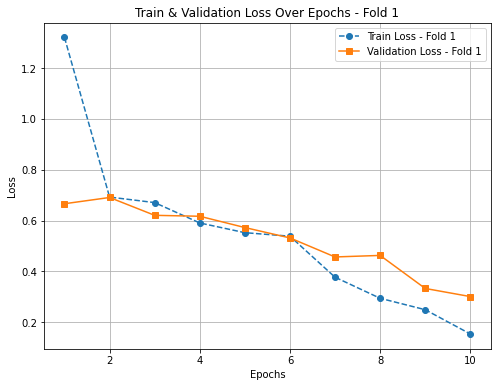

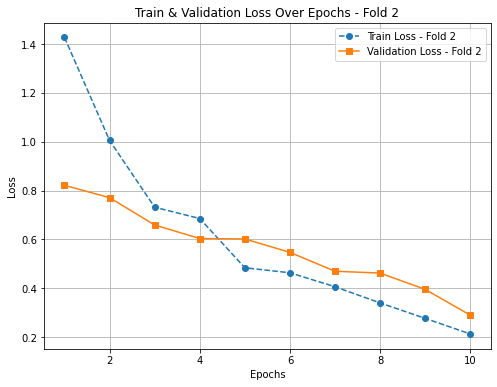

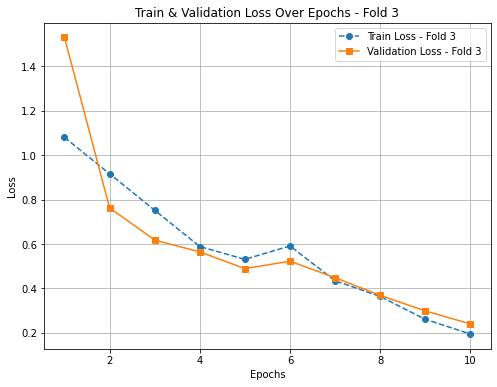

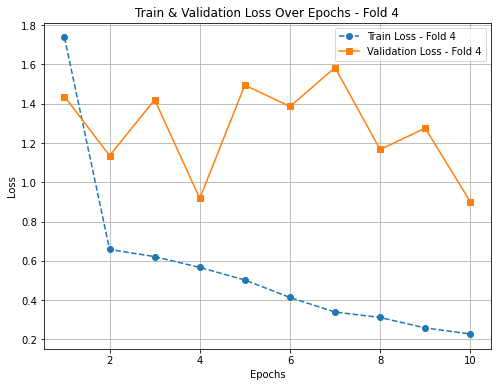

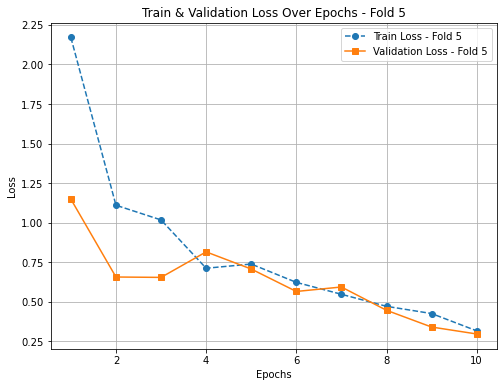

In [68]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------ Device Setup ------------------------------ #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------ Image Model ------------------------------ #
class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

# ------------------------------ Tabular Model ------------------------------ #
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# ------------------------------ Multimodal Model ------------------------------ #
class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # Adjust based on your actual feature size
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

# ------------------------------ Dataset Class ------------------------------ #
class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Ensure all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images, dtype=torch.float32)

        tabular_data = torch.tensor(
            np.array(row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']), dtype=np.float32)
        )

        label = torch.tensor(row['label'], dtype=torch.float32)

        return images, tabular_data, label

# ------------------------------ K-Fold Cross Validation ------------------------------ #
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_losses_per_fold = []
val_losses_per_fold = []
metrics_list = []
num_epochs = 10

for fold, (train_idx, test_idx) in enumerate(kf.split(combined_df)):
    print(f"\n🔹 Fold {fold + 1}/{k_folds}")

    train_df, test_df = combined_df.iloc[train_idx], combined_df.iloc[test_idx]

    train_dataset = MultimodalDataset(train_df)
    test_dataset = MultimodalDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, tabular_data, labels in train_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ------------------------------ Validation ------------------------------ #
        model.eval()
        running_val_loss = 0.0
        true_labels, pred_labels = [], []

        with torch.no_grad():
            for images, tabular_data, labels in test_loader:
                images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
                outputs = model(images, tabular_data)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                preds = (outputs > 0.5).float().cpu().numpy()
                true_labels.extend(labels.cpu().numpy().flatten())
                pred_labels.extend(preds.flatten())

        avg_val_loss = running_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)

    # Store classification report
    report = classification_report(true_labels, pred_labels, output_dict=True)
    metrics_list.append(report)
    print(f"\n🔹 Classification Report for Fold {fold + 1}:\n", classification_report(true_labels, pred_labels))

# ------------------------------ Plot Train & Validation Loss for Each Fold ------------------------------ #
for fold in range(k_folds):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses_per_fold[fold], label=f"Train Loss - Fold {fold+1}", linestyle="--", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses_per_fold[fold], label=f"Validation Loss - Fold {fold+1}", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Train & Validation Loss Over Epochs - Fold {fold+1}")
    plt.grid(True)
    plt.show()


In [31]:
# Split data into train and test sets
train_df, test_df = train_test_split(combined_df, test_size=0.1, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(train_df)):
    print(f"Fold {fold + 1}")

    # Create the training and validation datasets for the current fold
    train_fold_df = train_df.iloc[train_index]
    val_fold_df = train_df.iloc[val_index]

    train_dataset = MultimodalDataset(train_fold_df)
    val_dataset = MultimodalDataset(val_fold_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    # Initialize the model, loss function, and optimizer for each fold
    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, tabular_data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation loop
    model.eval()
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, tabular_data, labels in val_loader:
            outputs = model(images, tabular_data).view(-1)  # Ensure the output shape matches the labels
            predictions = (outputs >= 0.5).float()
            val_predictions.extend(predictions.tolist())
            val_labels.extend(labels.tolist())

    correct = sum([pred == label for pred, label in zip(val_predictions, val_labels)])
    accuracy = correct / len(val_predictions)
    fold_accuracies.append(accuracy)
    print(f'Fold {fold + 1} Validation Accuracy: {accuracy:.4f}')

# Average accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Cross-Validation Accuracy: {mean_accuracy:.4f}')

# Now test on the test dataset
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for images, tabular_data, labels in DataLoader(MultimodalDataset(test_df), batch_size=4, shuffle=False):
        outputs = model(images, tabular_data).view(-1)
        predictions = (outputs >= 0.5).float()
        test_predictions.extend(predictions.tolist())
        test_labels.extend(labels.tolist())

correct = sum([pred == label for pred, label in zip(test_predictions, test_labels)])
test_accuracy = correct / len(test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")


Fold 1
Epoch [1/30], Loss: 1.2374
Epoch [2/30], Loss: 0.7454
Epoch [3/30], Loss: 0.5165
Epoch [4/30], Loss: 0.5926
Epoch [5/30], Loss: 0.5011
Epoch [6/30], Loss: 0.3945
Epoch [7/30], Loss: 0.4024
Epoch [8/30], Loss: 0.2082
Epoch [9/30], Loss: 0.1558
Epoch [10/30], Loss: 0.1458
Epoch [11/30], Loss: 0.0681
Epoch [12/30], Loss: 0.0456
Epoch [13/30], Loss: 0.0235
Epoch [14/30], Loss: 0.0316
Epoch [15/30], Loss: 0.0153
Epoch [16/30], Loss: 0.0118
Epoch [17/30], Loss: 0.0060
Epoch [18/30], Loss: 0.0053
Epoch [19/30], Loss: 0.0029
Epoch [20/30], Loss: 0.0021
Epoch [21/30], Loss: 0.0017
Epoch [22/30], Loss: 0.0015
Epoch [23/30], Loss: 0.0014
Epoch [24/30], Loss: 0.0012
Epoch [25/30], Loss: 0.0011
Epoch [26/30], Loss: 0.0012
Epoch [27/30], Loss: 0.0014
Epoch [28/30], Loss: 0.0008
Epoch [29/30], Loss: 0.0010
Epoch [30/30], Loss: 0.0007
Fold 1 Validation Accuracy: 1.0000
Fold 2
Epoch [1/30], Loss: 0.8568
Epoch [2/30], Loss: 1.4616
Epoch [3/30], Loss: 0.8735
Epoch [4/30], Loss: 0.8491
Epoch [5/30]

Using device: cpu

🔹 Fold 1/5

🔹 Classification Report for Fold 1:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


🔹 Fold 2/5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr


🔹 Classification Report for Fold 2:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5


🔹 Fold 3/5

🔹 Classification Report for Fold 3:
               precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.75      0.86         4

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5


🔹 Fold 4/5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1


🔹 Classification Report for Fold 4:
               precision    recall  f1-score   support

         0.0       1.00      0.20      0.33         5
         1.0       0.00      0.00      0.00         0

    accuracy                           0.20         5
   macro avg       0.50      0.10      0.17         5
weighted avg       1.00      0.20      0.33         5


🔹 Fold 5/5

🔹 Classification Report for Fold 5:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



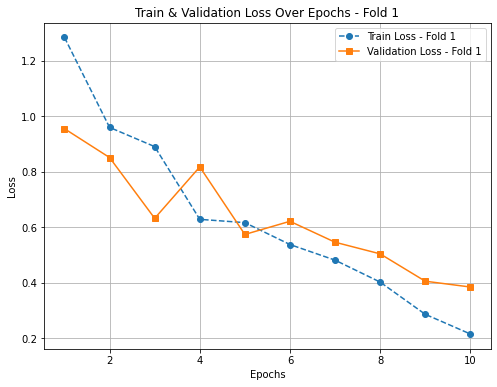

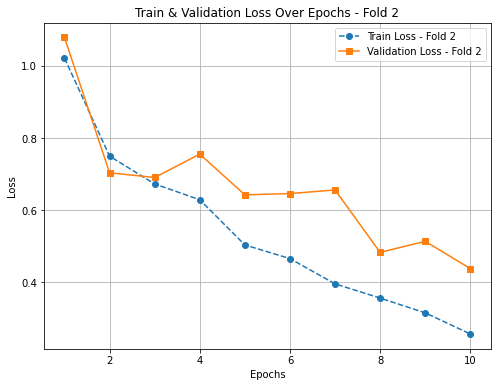

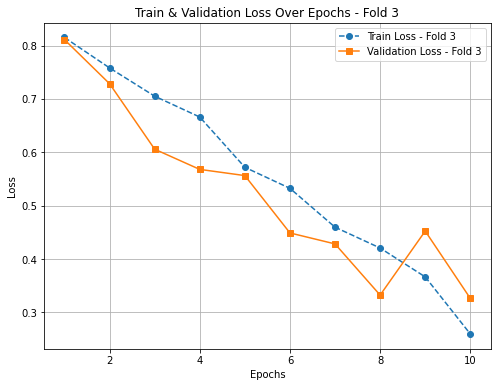

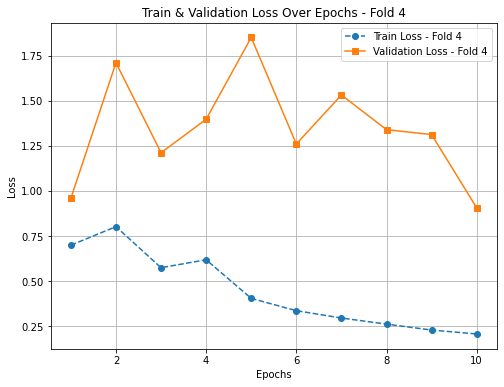

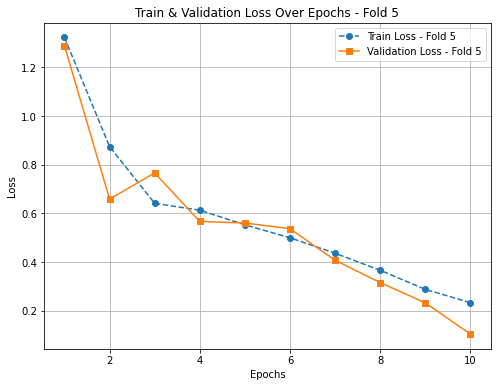

In [109]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------ Device Setup ------------------------------ #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------ Image Model ------------------------------ #
class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

# ------------------------------ Tabular Model ------------------------------ #
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# ------------------------------ Multimodal Model ------------------------------ #
class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # Adjust based on your actual feature size
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

# ------------------------------ Dataset Class ------------------------------ #
class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Ensure all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images, dtype=torch.float32)

        tabular_data = torch.tensor(
            np.array(row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']), dtype=np.float32)
        )

        label = torch.tensor(row['label'], dtype=torch.float32)

        return images, tabular_data, label

# ------------------------------ K-Fold Cross Validation ------------------------------ #
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_losses_per_fold = []
val_losses_per_fold = []
metrics_list = []
num_epochs = 10

for fold, (train_idx, test_idx) in enumerate(kf.split(combined_df)):
    print(f"\n🔹 Fold {fold + 1}/{k_folds}")

    train_df, test_df = combined_df.iloc[train_idx], combined_df.iloc[test_idx]

    train_dataset = MultimodalDataset(train_df)
    test_dataset = MultimodalDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
    model = MultimodalModel(input_dim=input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, tabular_data, labels in train_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ------------------------------ Validation ------------------------------ #
        model.eval()
        running_val_loss = 0.0
        true_labels, pred_labels = [], []

        with torch.no_grad():
            for images, tabular_data, labels in test_loader:
                images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
                outputs = model(images, tabular_data)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                preds = (outputs > 0.5).float().cpu().numpy()
                true_labels.extend(labels.cpu().numpy().flatten())
                pred_labels.extend(preds.flatten())

        avg_val_loss = running_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

    train_losses_per_fold.append(train_losses)
    val_losses_per_fold.append(val_losses)

    # Store classification report
    report = classification_report(true_labels, pred_labels, output_dict=True)
    metrics_list.append(report)
    print(f"\n🔹 Classification Report for Fold {fold + 1}:\n", classification_report(true_labels, pred_labels))

# ------------------------------ Plot Train & Validation Loss for Each Fold ------------------------------ #
for fold in range(k_folds):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses_per_fold[fold], label=f"Train Loss - Fold {fold+1}", linestyle="--", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses_per_fold[fold], label=f"Validation Loss - Fold {fold+1}", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Train & Validation Loss Over Epochs - Fold {fold+1}")
    plt.grid(True)
    plt.show()


In [107]:
import numpy as np

# Classification metrics for each fold
metrics = [
    {"accuracy": 1.00, "precision": 1.00, "recall": 1.00, "f1-score": 1.00},  # Fold 1
    {"accuracy": 0.80, "precision": 0.40, "recall": 0.50, "f1-score": 0.44},  # Fold 2
    {"accuracy": 0.60, "precision": 0.67, "recall": 0.75, "f1-score": 0.58},  # Fold 3
    {"accuracy": 0.20, "precision": 0.50, "recall": 0.10, "f1-score": 0.17},  # Fold 4
    {"accuracy": 1.00, "precision": 1.00, "recall": 1.00, "f1-score": 1.00},  # Fold 5
]

# Compute average metrics
avg_accuracy = np.mean([m["accuracy"] for m in metrics])
avg_precision = np.mean([m["precision"] for m in metrics])
avg_recall = np.mean([m["recall"] for m in metrics])
avg_f1_score = np.mean([m["f1-score"] for m in metrics])

avg_accuracy, avg_precision, avg_recall, avg_f1_score


(0.72, 0.714, 0.67, 0.638)

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------ Device Setup ------------------------------ #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------ Updated Image Model ------------------------------ #
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 60 * 80, 256)
        self.fc2 = nn.Linear(256, 128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batchnorm(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

# ------------------------------ Updated Tabular Model ------------------------------ #
class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc_out = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# ------------------------------ Updated Multimodal Model ------------------------------ #
class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        self.image_model = ImageModel()
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        print(f"Image Features Shape: {image_features.shape}")
        print(f"Tabular Features Shape: {tabular_features.shape}")
        combined = torch.cat((image_features, tabular_features), dim=1)
        print(f"Combined Features Shape: {combined.shape}")
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# ------------------------------ Dataset Class ------------------------------ #
class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        images = np.stack([image_kiss, image_normal, image_spread, image_open])
        images = images.transpose(0, 3, 1, 2)
        images = images.reshape(-1, images.shape[2], images.shape[3])
        images = torch.tensor(images, dtype=torch.float32)

        tabular_data = torch.tensor(
            np.array(row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']), dtype=np.float32)
        )

        label = torch.tensor(row['label'], dtype=torch.float32)

        return images, tabular_data, label

# ------------------------------ Training Function ------------------------------ #
def train_and_evaluate(train_df, test_df, input_dim, num_epochs=20):
    train_dataset = MultimodalDataset(train_df)
    test_dataset = MultimodalDataset(test_df)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    model = MultimodalModel(input_dim=input_dim).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for images, tabular_data, labels in train_loader:
            images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        true_labels, pred_labels = [], []

        with torch.no_grad():
            for images, tabular_data, labels in test_loader:
                images, tabular_data, labels = images.to(device), tabular_data.to(device), labels.to(device).view(-1, 1)
                outputs = model(images, tabular_data)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                preds = (outputs > 0.5).float().cpu().numpy()
                true_labels.extend(labels.cpu().numpy().flatten())
                pred_labels.extend(preds.flatten())

        avg_val_loss = running_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    return classification_report(true_labels, pred_labels, output_dict=True)

# ------------------------------ K-Fold Cross Validation ------------------------------ #
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics_list = [train_and_evaluate(combined_df.iloc[train_idx], combined_df.iloc[test_idx], combined_df.shape[1] - 5) for train_idx, test_idx in kf.split(combined_df)]


Using device: cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x9 and 10x128)

In [11]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image



class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        # Convert label to np.float32
        label = torch.tensor(row['label'], dtype=torch.float32)
        print("images",images.shape)
        print("tabular_data",tabular_data.shape)
        print("label",label)

        return images, tabular_data, label

In [13]:
import torch
import os

# Specify the path where you want to save the model
model_save_path = r"C:\Users\T00760303\Downloads\multimodal_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

# Get the absolute path of the saved model
absolute_path = os.path.abspath(model_save_path)

print(f"Model saved to {absolute_path}")


Model saved to C:\Users\T00760303\Downloads\multimodal_model.pth


App testing

In [14]:
# Load the trained model
input_dim = 9  # Adjust this according to the number of tabular features
model = MultimodalModel(input_dim=input_dim)
model.load_state_dict(torch.load(r"C:\Users\T00760303\Downloads\multimodal_model.pth"))
model.eval()

C:\Users\T00760303\AppData\Local\Temp\ipykernel_11568\30728326.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\T00760303\Down

MultimodalModel(
  (image_model): ImageModel(
    (conv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=614400, out_features=128, bias=True)
  )
  (tabular_model): TabularModel(
    (fc1): Linear(in_features=9, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=16, bias=True)
  )
  (fc1): Linear(in_features=144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [15]:
# # Load the trained model
# input_dim = 9  # Adjust this according to the number of tabular features
# model = MultimodalModel(input_dim=input_dim)
# model.load_state_dict(torch.load(r'C:\Users\T00760303.MYTRU\Downloads\multimodal_model.pth'))
# model.eval()

# Function to load the DeepLabV3 model
def load_segmentation_model():
    return models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

segmentation_model = load_segmentation_model()

# Preprocessing functions
def remove_background(image_np, model):
    image = Image.fromarray(image_np.astype('uint8')).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_image)['out'][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()
    output_predictions = cv2.resize(output_predictions, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask = (output_predictions == 15).astype(np.uint8)
    return image_np * mask[:, :, np.newaxis]

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    if image.ndim == 2:
        sharpened = convolve(image, kernel)
    elif image.ndim == 3 and image.shape[2] == 3:
        sharpened = np.zeros_like(image)
        for i in range(3):
            sharpened[:, :, i] = convolve(image[:, :, i], kernel)
    else:
        raise ValueError("Unsupported image shape")
    return np.clip(sharpened, 0, 1)

def preprocess_image(image, model):
    image_segmented = remove_background(image, model)
    image_segmented = image_segmented / 255.0
    image_denoised = gaussian(image_segmented, sigma=1, channel_axis=-1)
    return sharpen_image(image_denoised)

# Function to get user input
def get_user_input():
    age = float(input("Enter your age: "))
    gender = input("Enter your gender (male/female): ").lower()
    nhiss = float(input("Enter your NIHSS score: "))
    systolic = float(input("Enter your systolic blood pressure: "))
    distolic = float(input("Enter your distolic blood pressure: "))
    glucose = float(input("Enter your glucose level: "))
    smoking = input("Enter your smoking status (0: never, 1: former, 2: current): ")
    bmi = float(input("Enter your BMI: "))
    cholestrol = float(input("Enter your cholesterol level: "))

    gender = 0 if gender == 'male' else 1
    smoking = int(smoking)

    return {
        'age': age,
        'gender': gender,
        'nhiss': nhiss,
        'systolic': systolic,
        'distolic': distolic,
        'glucose': glucose,
        'smoking': smoking,
        'bmi': bmi,
        'cholestrol': cholestrol
    }

# Function to capture images from webcam
def capture_image_from_webcam():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        cv2.imshow('Webcam Capture', frame)
        cv2.waitKey(1000)
        cv2.destroyWindow('Webcam Capture')
    cap.release()
    cv2.destroyAllWindows()
    return frame

# Function to upload an image from file
def upload_image():
    file_path = input("Enter the path of the image to upload: ")
    if os.path.exists(file_path):
        image = cv2.imread(file_path)
        return image
    else:
        print("File not found. Please try again.")
        return upload_image()

# Function to get images with option for webcam or upload
def get_images_with_labels():
    images = {}
    labels = ['image_kiss', 'image_normal', 'image_spread', 'image_open']
    
    for label in labels:
        choice = input(f"Do you want to capture {label} using webcam or upload an image? (webcam 0/upload 1): ").lower()
        
        if choice == '0':
            print(f"Please prepare to capture {label} image.")
            input(f"Press Enter to capture {label} using the webcam...")
            images[label] = capture_image_from_webcam()
        
        elif choice == '1':
            print(f"Please upload the {label} image.")
            images[label] = upload_image()
        
        else:
            print("Invalid choice. Please select either 'webcam' or 'upload'.")
            return get_images_with_labels()
    
    return images

# Combine image and tabular data
def combine_image_tabular(image_dict, tabular_data):
    combined_data = {}
    for feature, image in image_dict.items():
        combined_data[f'{feature}'] = image
    for key, value in tabular_data.items():
        combined_data[key] = value
    return pd.DataFrame([combined_data])

# Predict function
def predict(image_dict, tabular_data, model):
    # Preprocess images
    preprocessed_images = {label: preprocess_image(image, segmentation_model) for label, image in image_dict.items()}
    
    combined_data = combine_image_tabular(preprocessed_images, tabular_data)
    
    # Show the DataFrame to the user
    print("\nMerged and Preprocessed DataFrame:")
    print(combined_data)
    
    # Save the combined data to a CSV file
    save_data_to_csv(combined_data)
    
    dataset = MultimodalDataset(combined_data)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images, tabular_data, _ in dataloader:
            output = model(images, tabular_data).view(-1)
            prediction = (output >= 0.5).float().item()
            return "Stroke Detected" if prediction == 1 else "No Stroke Detected"

# Function to save data to CSV
def save_data_to_csv(data):
    file_path = r'C:\Users\T00760303.MYTRU\Downloads\user_data.csv'
    if not os.path.isfile(file_path):
        data.to_csv(file_path, index=False)
    else:
        data.to_csv(file_path, mode='a', header=False, index=False)



In [ ]:
C:\Users\T00760303.MYTRU\OneDrive - Thompson Rivers University\new day\Neuroface_Stroke - Copy\Stroke\P01_KISS.jpg

In [ ]:
#############################    Test  

In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Define your model classes as provided earlier

class ImageModel(nn.Module):
    def __init__(self, output_size):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(output_size, 128)  # Adjusted based on the actual output size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        return x

class TabularModel(nn.Module):
    def __init__(self, input_dim):
        super(TabularModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class MultimodalModel(nn.Module):
    def __init__(self, input_dim):
        super(MultimodalModel, self).__init__()
        output_size = 32 * 120 * 160  # This is based on the above calculations
        self.image_model = ImageModel(output_size=output_size)
        self.tabular_model = TabularModel(input_dim)
        self.fc1 = nn.Linear(128 + 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, images, tabular_data):
        image_features = self.image_model(images)
        tabular_features = self.tabular_model(tabular_data)
        combined = torch.cat((image_features, tabular_features), dim=1)
        x = F.relu(self.fc1(combined))
        x = torch.sigmoid(self.fc2(x))
        return x

class MultimodalDataset(Dataset):
    def __init__(self, dataframe, is_inference=False):
        self.data = dataframe
        self.is_inference = is_inference

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        def load_image(image_array):
            image = Image.fromarray(np.uint8(image_array))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            return np.array(image.resize((640, 480)), dtype=np.float32)

        # Load images, resize to (480, 640), and convert to np.float32
        image_kiss = load_image(row['image_kiss'])
        image_normal = load_image(row['image_normal'])
        image_spread = load_image(row['image_spread'])
        image_open = load_image(row['image_open'])

        # Check if all images have the same shape
        assert image_kiss.shape == image_normal.shape == image_spread.shape == image_open.shape, \
            "All images must have the same shape!"
        
        # Stack images
        images = np.stack([image_kiss, image_normal, image_spread, image_open])  # Shape: [4, 480, 640, 3]
        
        # Transpose the images to have shape (4, 3, 480, 640) and then reshape to (12, 480, 640)
        images = images.transpose(0, 3, 1, 2)  # Shape: [4, 3, 480, 640]
        images = images.reshape(-1, images.shape[2], images.shape[3])  # Shape: [12, 480, 640]
        images = torch.tensor(images)  # Convert to a torch tensor
        
        # Convert tabular data to np.float32
        tabular_data = np.array(
            row.drop(['image_kiss', 'image_normal', 'image_spread', 'image_open']).values,
            dtype=np.float32
        )
        tabular_data = torch.tensor(tabular_data)
        
        if self.is_inference:
            return images, tabular_data
        else:
            label = torch.tensor(row['label'], dtype=torch.float32)
            return images, tabular_data, label


# Prepare the DataLoader
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42)
train_dataset = MultimodalDataset(train_df)
test_dataset = MultimodalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize the model, loss function, and optimizer
input_dim = train_df.drop(columns=['pid', 'label', 'image_kiss', 'image_normal', 'image_spread', 'image_open']).shape[1]
model = MultimodalModel(input_dim=input_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, tabular_data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images, tabular_data).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the trained model
torch.save(model.state_dict(), 'multimodal_model_1.pth')

# Put the model in evaluation mode
model.eval()

# Disable gradient computation for inference
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, tabular_data, labels in test_loader:
        # Get model outputs
        outputs = model(images, tabular_data).squeeze()

        # Ensure outputs is a 1D tensor, even if the batch size is 1
        if outputs.dim() == 0:
            outputs = outputs.unsqueeze(0)

        # Apply a threshold to get binary predictions (e.g., threshold=0.5)
        predictions = (outputs >= 0.5).float()

        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())
print("all_predictions", all_predictions)
print("all_labels", all_labels)

# Optionally, you can compute accuracy or other metrics
correct = sum([pred == label for pred, label in zip(all_predictions, all_labels)])
accuracy = correct / len(all_predictions)
print(f"Accuracy: {accuracy:.4f}")


In [30]:
# # Load the trained model
# input_dim = 9  # Adjust this according to the number of tabular features
# model = MultimodalModel(input_dim=input_dim)
# model.load_state_dict(torch.load(r'C:\Users\T00760303.MYTRU\Downloads\multimodal_model.pth'))
# model.eval()

# Function to load the DeepLabV3 model
def load_segmentation_model():
    return models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

segmentation_model = load_segmentation_model()

# Preprocessing functions
def remove_background(image_np, model):
    image = Image.fromarray(image_np.astype('uint8')).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_image)['out'][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()
    output_predictions = cv2.resize(output_predictions, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)
    mask = (output_predictions == 15).astype(np.uint8)
    return image_np * mask[:, :, np.newaxis]

def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    if image.ndim == 2:
        sharpened = convolve(image, kernel)
    elif image.ndim == 3 and image.shape[2] == 3:
        sharpened = np.zeros_like(image)
        for i in range(3):
            sharpened[:, :, i] = convolve(image[:, :, i], kernel)
    else:
        raise ValueError("Unsupported image shape")
    return np.clip(sharpened, 0, 1)

def preprocess_image(image, model):
    image_segmented = remove_background(image, model)
    image_segmented = image_segmented / 255.0
    image_denoised = gaussian(image_segmented, sigma=1, channel_axis=-1)
    return sharpen_image(image_denoised)

# Function to get user input
def get_user_input():
    age = float(input("Enter your age: "))
    gender = input("Enter your gender (male/female): ").lower()
    nhiss = float(input("Enter your NIHSS score: "))
    systolic = float(input("Enter your systolic blood pressure: "))
    distolic = float(input("Enter your distolic blood pressure: "))
    glucose = float(input("Enter your glucose level: "))
    smoking = input("Enter your smoking status (0: never, 1: former, 2: current): ")
    bmi = float(input("Enter your BMI: "))
    cholestrol = float(input("Enter your cholesterol level: "))

    gender = 0 if gender == 'male' else 1
    smoking = int(smoking)

    return {
        'age': age,
        'gender': gender,
        'nhiss': nhiss,
        'systolic': systolic,
        'distolic': distolic,
        'glucose': glucose,
        'smoking': smoking,
        'bmi': bmi,
        'cholestrol': cholestrol
    }

# Function to capture images from webcam
def capture_image_from_webcam():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    if ret:
        cv2.imshow('Webcam Capture', frame)
        cv2.waitKey(1000)
        cv2.destroyWindow('Webcam Capture')
    cap.release()
    cv2.destroyAllWindows()
    return frame

# Function to upload an image from file
def upload_image():
    file_path = input("Enter the path of the image to upload: ")
    if os.path.exists(file_path):
        image = cv2.imread(file_path)
        return image
    else:
        print("File not found. Please try again.")
        return upload_image()

# Function to get images with option for webcam or upload
def get_images_with_labels():
    images = {}
    labels = ['image_kiss', 'image_normal', 'image_spread', 'image_open']
    
    for label in labels:
        choice = input(f"Do you want to capture {label} using webcam or upload an image? (webcam 0/upload 1): ").lower()
        
        if choice == '0':
            print(f"Please prepare to capture {label} image.")
            input(f"Press Enter to capture {label} using the webcam...")
            images[label] = capture_image_from_webcam()
        
        elif choice == '1':
            print(f"Please upload the {label} image.")
            images[label] = upload_image()
        
        else:
            print("Invalid choice. Please select either 'webcam' or 'upload'.")
            return get_images_with_labels()
    
    return images

# Combine image and tabular data
def combine_image_tabular(image_dict, tabular_data):
    combined_data = {}
    for feature, image in image_dict.items():
        combined_data[f'{feature}'] = image
    for key, value in tabular_data.items():
        combined_data[key] = value
    return pd.DataFrame([combined_data])

# Predict
def predict(image_dict, tabular_data, model):
    # Preprocess images
    preprocessed_images = {label: preprocess_image(image, segmentation_model) for label, image in image_dict.items()}
    
    combined_data = combine_image_tabular(preprocessed_images, tabular_data)
    
    # Show the DataFrame to the user
    print("\nMerged and Preprocessed DataFrame:")
    print(combined_data)
    
    # Save the combined data to a CSV file
    save_data_to_csv(combined_data)
    
    dataset = MultimodalDataset(combined_data, is_inference=True)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images, tabular_data in dataloader:
            output = model(images, tabular_data).view(-1)
            
            prediction = (output >= 0.47).float().item()
            return "Stroke Detected" if prediction == 1 else "No Stroke Detected"

# Function to save data to CSV
def save_data_to_csv(data):
    file_path = r'C:\Users\T00760303\Downloads\user_data.csv'
    if not os.path.isfile(file_path):
        data.to_csv(file_path, index=False)
    else:
        data.to_csv(file_path, mode='a', header=False, index=False)




In [39]:
# Main execution
if __name__ == "__main__":
    # Capture or upload images
    images = get_images_with_labels()

    # Get user input
    user_input = get_user_input()

    # Predict
    result = predict(images, user_input, model)
    print(f"Prediction: {result}")

Do you want to capture image_kiss using webcam or upload an image? (webcam 0/upload 1): C:\Users\T00760303.MYTRU\OneDrive - Thompson Rivers University\Neuroface_Stroke\Healthy\P16_KISS.jpg
Invalid choice. Please select either 'webcam' or 'upload'.
Do you want to capture image_kiss using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_kiss image.
Enter the path of the image to upload: C:\Users\T00760303.MYTRU\OneDrive - Thompson Rivers University\Neuroface_Stroke\Healthy\P16_KISS.jpg
Do you want to capture image_normal using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_normal image.
Enter the path of the image to upload: C:\Users\T00760303.MYTRU\OneDrive - Thompson Rivers University\Neuroface_Stroke\Healthy\P16_NORMAL.jpg
Do you want to capture image_spread using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_spread image.
Enter the path of the image to upload: C:\Users\T00760303.MYTRU\OneDrive - Thompson 

In [40]:
model

MultimodalModel(
  (image_model): ImageModel(
    (conv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=614400, out_features=128, bias=True)
  )
  (tabular_model): TabularModel(
    (fc1): Linear(in_features=9, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=16, bias=True)
  )
  (fc1): Linear(in_features=144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [21]:
# Main execution
if __name__ == "__main__":
    # Capture or upload images
    images = get_images_with_labels()

    # Get user input
    user_input = get_user_input()

    # Predict
    result = predict(images, user_input, model)
    print(f"Prediction: {result}")

Do you want to capture image_kiss using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_kiss image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Stroke\P02_KISS.jpg
Do you want to capture image_normal using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_normal image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Stroke\P02_NORMAL.jpg
Do you want to capture image_spread using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_spread image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Stroke\P02_SPREAD.jpg
Do you want to capture image_open using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_open image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - T

In [42]:
# Main execution
if __name__ == "__main__":
    # Capture or upload images
    images = get_images_with_labels()

    # Get user input
    user_input = get_user_input()

    # Predict
    result = predict(images, user_input, model)
    print(f"Prediction: {result}")

Do you want to capture image_kiss using webcam or upload an image? (webcam 0/upload 1): 0
Please prepare to capture image_kiss image.
Press Enter to capture image_kiss using the webcam...
Do you want to capture image_normal using webcam or upload an image? (webcam 0/upload 1): 0
Please prepare to capture image_normal image.
Press Enter to capture image_normal using the webcam...
Do you want to capture image_spread using webcam or upload an image? (webcam 0/upload 1): 0
Please prepare to capture image_spread image.
Press Enter to capture image_spread using the webcam...
Do you want to capture image_open using webcam or upload an image? (webcam 0/upload 1): 0
Please prepare to capture image_open image.
Press Enter to capture image_open using the webcam...
Enter your age: 22
Enter your gender (male/female): female
Enter your NIHSS score: 8
Enter your systolic blood pressure: 120
Enter your distolic blood pressure: 83
Enter your glucose level: 200
Enter your smoking status (0: never, 1: fo

In [27]:
# Main execution
if __name__ == "__main__":
    # Capture or upload images
    images = get_images_with_labels()

    # Get user input
    user_input = get_user_input()

    # Predict
    result = predict(images, user_input, model)
    print(f"Prediction: {result}")


Do you want to capture image_kiss using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_kiss image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Stroke\P02_KISS.jpg
Do you want to capture image_normal using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_normal image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Stroke\P02_NORMAL.jpg
Do you want to capture image_spread using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_spread image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Stroke\P02_SPREAD.jpg
Do you want to capture image_open using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_open image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - T

In [ ]:
"C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Stroke\P02_KISS.jpg"

In [31]:
# Main execution
if __name__ == "__main__":
    # Capture or upload images
    images = get_images_with_labels()

    # Get user input
    user_input = get_user_input()

    # Predict
    result = predict(images, user_input, model)
    print(f"Prediction: {result}")

Do you want to capture image_kiss using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_kiss image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Healthy\P17_KISS.jpg
Do you want to capture image_normal using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_normal image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Healthy\P17_NORMAL.jpg
Do you want to capture image_spread using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_spread image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Healthy\P17_SPREAD.jpg
Do you want to capture image_open using webcam or upload an image? (webcam 0/upload 1): 1
Please upload the image_open image.
Enter the path of the image to upload: C:\Users\T00760303\OneDrive 

In [ ]:
C:\Users\T00760303\OneDrive - Thompson Rivers University\17th\Neuroface_Stroke\Healthy\P17_KISS.jpg